# **Import Libraries & Dependencies**

In [1]:
!pip install optuna
!pip install category_encoders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.4/413.4 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 925.0 kB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder , StandardScaler , RobustScaler , OrdinalEncoder , LabelEncoder
from category_encoders import BinaryEncoder
from sklearn.model_selection import cross_val_score , KFold , cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score
import optuna
import joblib

# **Read & Explore Data**


In [3]:
df = pd.read_excel('/content/Data_Train.xlsx')
df

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302
...,...,...,...,...,...,...,...,...,...,...,...
10678,Air Asia,9/04/2019,Kolkata,Banglore,CCU → BLR,19:55,22:25,2h 30m,non-stop,No info,4107
10679,Air India,27/04/2019,Kolkata,Banglore,CCU → BLR,20:45,23:20,2h 35m,non-stop,No info,4145
10680,Jet Airways,27/04/2019,Banglore,Delhi,BLR → DEL,08:20,11:20,3h,non-stop,No info,7229
10681,Vistara,01/03/2019,Banglore,New Delhi,BLR → DEL,11:30,14:10,2h 40m,non-stop,No info,12648


In [4]:
#make data summary

def summary_data(dataframe) :

  summary = pd.DataFrame(dataframe.dtypes , columns=['Dtypes'])
  summary['Missing %'] = dataframe.isna().mean() * 100
  summary['Count'] = dataframe.count().values
  summary['Unique'] = dataframe.nunique().values


  return summary


summary_data(df).style.background_gradient(cmap='Blues')



,Dtypes,Missing %,Count,Unique
Airline,object,0.000000,10683,12
Date_of_Journey,object,0.000000,10683,44
Source,object,0.000000,10683,5
Destination,object,0.000000,10683,6
Route,object,0.009361,10682,128
Dep_Time,object,0.000000,10683,222
Arrival_Time,object,0.000000,10683,1343
Duration,object,0.000000,10683,368
Total_Stops,object,0.009361,10682,5
Additional_Info,object,0.000000,10683,10


In [5]:
# check duplicates
df.duplicated().sum()

220

In [6]:
# drop duplicates
df.drop_duplicates(inplace=True)
df.reset_index(drop=True , inplace=True)

In [7]:
# check for duplicates again :
df.duplicated().sum()

0

In [8]:
# dropping missing values (1 row) :
df.dropna(axis=0,inplace=True)
df.reset_index(drop=True , inplace=True)

In [9]:
# check for duplicates again
df.duplicated().sum()

0

We are good to go!

# **Univariate Analysis**

## Airlines

In [10]:
df['Airline'].value_counts()

Jet Airways                          3700
IndiGo                               2043
Air India                            1694
Multiple carriers                    1196
SpiceJet                              815
Vistara                               478
Air Asia                              319
GoAir                                 194
Multiple carriers Premium economy      13
Jet Airways Business                    6
Vistara Premium economy                 3
Trujet                                  1
Name: Airline, dtype: int64

Jet Airways Business & Vistera Premium Economy should be with their main categories

In [11]:
df['Airline'] = df['Airline'].str.replace('Jet Airways Business' , 'Jet Airways')
df['Airline'] = df['Airline'].str.replace('Vistara Premium economy' , 'Vistara')

In [12]:
df['Airline'].value_counts()

Jet Airways                          3706
IndiGo                               2043
Air India                            1694
Multiple carriers                    1196
SpiceJet                              815
Vistara                               481
Air Asia                              319
GoAir                                 194
Multiple carriers Premium economy      13
Trujet                                  1
Name: Airline, dtype: int64

<Axes: xlabel='count', ylabel='Airline'>

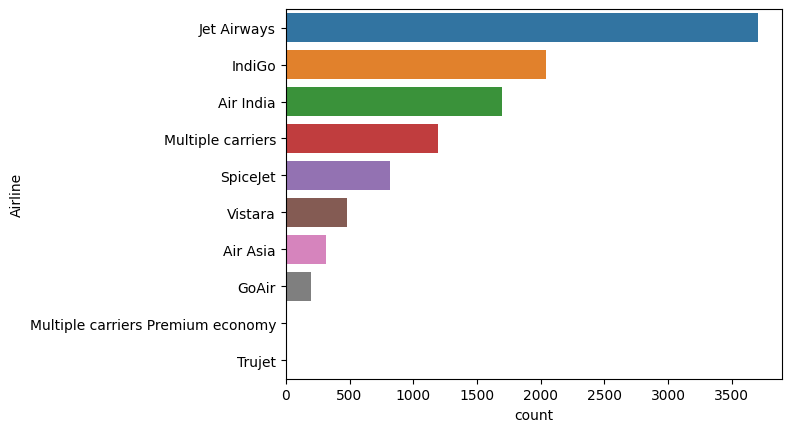

In [13]:
sns.countplot(data = df , y = 'Airline' , order=df['Airline'].value_counts().index)

In [14]:
df.drop(df[df.Airline == 'Trujet'].index , axis = 0 , inplace = True)
df.drop(df[df.Airline == 'Multiple carriers Premium economy'].index , axis = 0 , inplace = True)
df.reset_index(drop = True , inplace = True)

<Axes: xlabel='count', ylabel='Airline'>

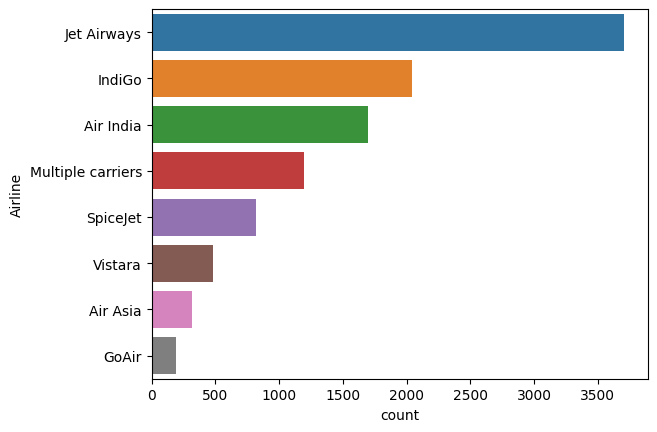

In [15]:
sns.countplot(data = df , y = 'Airline' , order=df['Airline'].value_counts().index)

## Date_of_Journey

In [16]:
# convert column tp datetime colunn :
df['Date_of_Journey'] = pd.to_datetime(df['Date_of_Journey'] , errors='coerce')

<ipython-input-16-fcb05814cb3c>:2: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df['Date_of_Journey'] = pd.to_datetime(df['Date_of_Journey'] , errors='coerce')


In [17]:
df

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,2019-03-24,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,2019-01-05,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,2019-09-06,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,2019-12-05,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,2019-01-03,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302
...,...,...,...,...,...,...,...,...,...,...,...
10443,Air Asia,2019-09-04,Kolkata,Banglore,CCU → BLR,19:55,22:25,2h 30m,non-stop,No info,4107
10444,Air India,2019-04-27,Kolkata,Banglore,CCU → BLR,20:45,23:20,2h 35m,non-stop,No info,4145
10445,Jet Airways,2019-04-27,Banglore,Delhi,BLR → DEL,08:20,11:20,3h,non-stop,No info,7229
10446,Vistara,2019-01-03,Banglore,New Delhi,BLR → DEL,11:30,14:10,2h 40m,non-stop,No info,12648


In [18]:
# split date into three columns for analysis
def split_date(d):
  return d.year , d.month , d.day_name()

df['Journey_Year'] , df['Journey_Month'] , df['Journey_Day'] = zip(*df['Date_of_Journey'].apply(split_date))

In [19]:
# extract seasons from month
def extract_season(month) :
  if month in [12,1,2] :
    return "Winter"
  elif month in [3,4,5] :
    return "Spring"
  elif month in [6,7,8] :
    return "Summer"
  else :
    return "Autumn"


df['Season'] = df['Journey_Month'].apply(extract_season)

In [20]:
df

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Journey_Year,Journey_Month,Journey_Day,Season
0,IndiGo,2019-03-24,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897,2019,3,Sunday,Spring
1,Air India,2019-01-05,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662,2019,1,Saturday,Winter
2,Jet Airways,2019-09-06,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882,2019,9,Friday,Autumn
3,IndiGo,2019-12-05,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218,2019,12,Thursday,Winter
4,IndiGo,2019-01-03,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302,2019,1,Thursday,Winter
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10443,Air Asia,2019-09-04,Kolkata,Banglore,CCU → BLR,19:55,22:25,2h 30m,non-stop,No info,4107,2019,9,Wednesday,Autumn
10444,Air India,2019-04-27,Kolkata,Banglore,CCU → BLR,20:45,23:20,2h 35m,non-stop,No info,4145,2019,4,Saturday,Spring
10445,Jet Airways,2019-04-27,Banglore,Delhi,BLR → DEL,08:20,11:20,3h,non-stop,No info,7229,2019,4,Saturday,Spring
10446,Vistara,2019-01-03,Banglore,New Delhi,BLR → DEL,11:30,14:10,2h 40m,non-stop,No info,12648,2019,1,Thursday,Winter


<Axes: xlabel='Journey_Year', ylabel='count'>

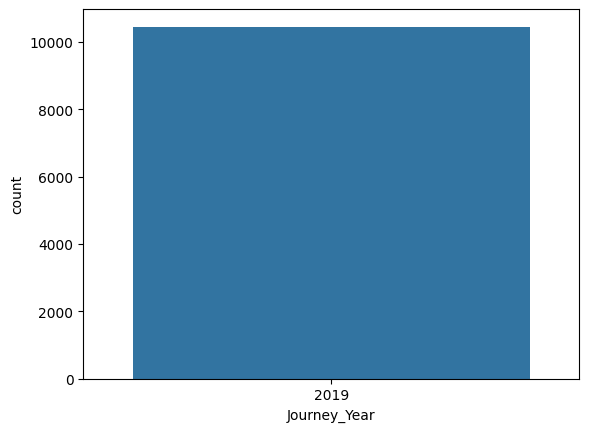

In [21]:
sns.countplot(data = df , x = 'Journey_Year')

<Axes: xlabel='Journey_Month', ylabel='count'>

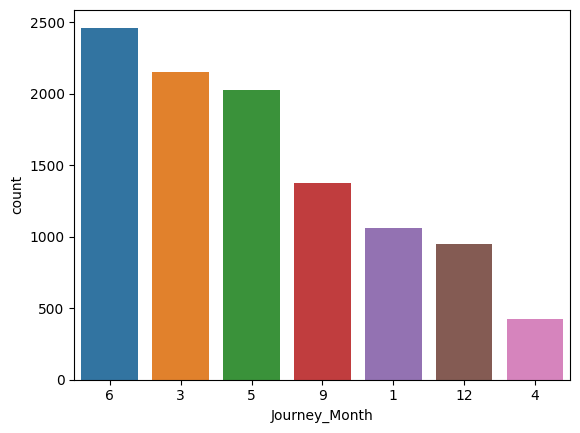

In [22]:
sns.countplot(data = df , x = 'Journey_Month' , order=df['Journey_Month'].value_counts().index)

<Axes: xlabel='count', ylabel='Journey_Day'>

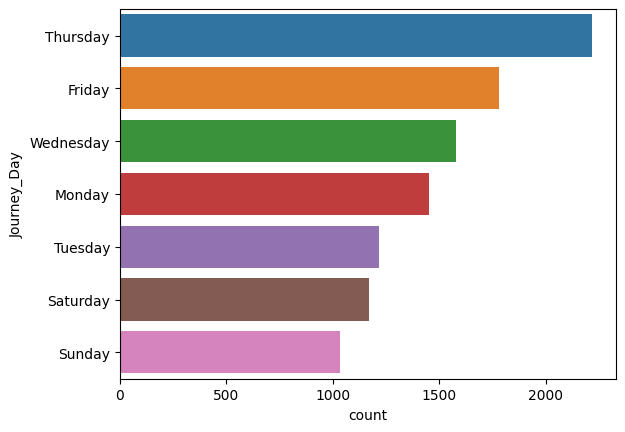

In [23]:
sns.countplot(data = df , y = 'Journey_Day' , order=df['Journey_Day'].value_counts().index)

<Axes: xlabel='Season', ylabel='count'>

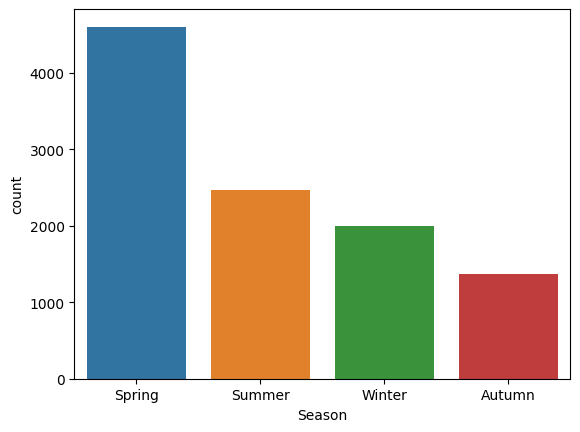

In [24]:
sns.countplot(data = df , x = 'Season' , order = df['Season'].value_counts().index)

## Source

In [25]:
df['Source'].unique()

array(['Banglore', 'Kolkata', 'Delhi', 'Chennai', 'Mumbai'], dtype=object)

<Axes: xlabel='Source', ylabel='count'>

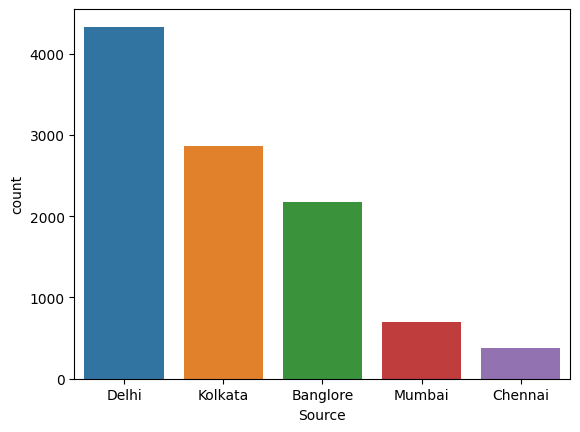

In [26]:
sns.countplot(data = df , x = 'Source' , order=df['Source'].value_counts().index)

## Destination

In [27]:
df['Destination'].unique()

array(['New Delhi', 'Banglore', 'Cochin', 'Kolkata', 'Delhi', 'Hyderabad'],
      dtype=object)

<Axes: xlabel='count', ylabel='Destination'>

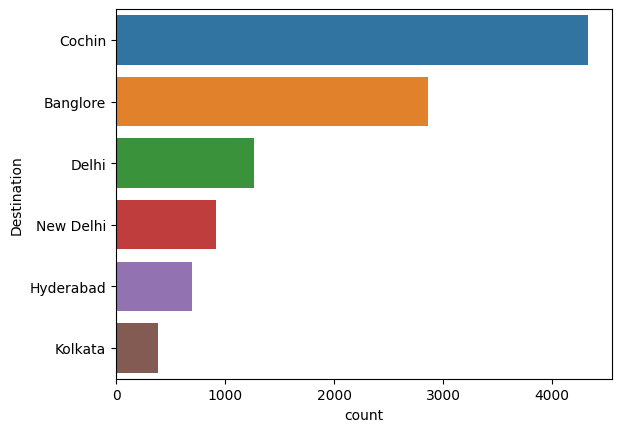

In [28]:
sns.countplot(data = df , y = 'Destination' , order=df['Destination'].value_counts().index)

## Route

We will use Route column to check if the total_stops column has any wrong entries

In [29]:
def count_stops(route) :
  route_list = route.split('→')
  if len(route_list) == 2 :
    return 'non-stop'
  elif len(route_list) == 3 :
    return '1 stop'
  elif len(route_list) == 4 :
    return '2 stops'
  elif len(route_list) == 5:
    return '3 stops'
  else :
    return '4 stops'

df['route_check'] = df['Route'].apply(count_stops)

In [30]:
df[df.Total_Stops != df.route_check]

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Journey_Year,Journey_Month,Journey_Day,Season,route_check


Looks like all total_stops entries are correctly entered.

## Dep_Time

In [31]:
df['Dep_Time'] = pd.to_datetime(df['Dep_Time']).dt.time

In [32]:
df

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Journey_Year,Journey_Month,Journey_Day,Season,route_check
0,IndiGo,2019-03-24,Banglore,New Delhi,BLR → DEL,22:20:00,01:10 22 Mar,2h 50m,non-stop,No info,3897,2019,3,Sunday,Spring,non-stop
1,Air India,2019-01-05,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50:00,13:15,7h 25m,2 stops,No info,7662,2019,1,Saturday,Winter,2 stops
2,Jet Airways,2019-09-06,Delhi,Cochin,DEL → LKO → BOM → COK,09:25:00,04:25 10 Jun,19h,2 stops,No info,13882,2019,9,Friday,Autumn,2 stops
3,IndiGo,2019-12-05,Kolkata,Banglore,CCU → NAG → BLR,18:05:00,23:30,5h 25m,1 stop,No info,6218,2019,12,Thursday,Winter,1 stop
4,IndiGo,2019-01-03,Banglore,New Delhi,BLR → NAG → DEL,16:50:00,21:35,4h 45m,1 stop,No info,13302,2019,1,Thursday,Winter,1 stop
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10443,Air Asia,2019-09-04,Kolkata,Banglore,CCU → BLR,19:55:00,22:25,2h 30m,non-stop,No info,4107,2019,9,Wednesday,Autumn,non-stop
10444,Air India,2019-04-27,Kolkata,Banglore,CCU → BLR,20:45:00,23:20,2h 35m,non-stop,No info,4145,2019,4,Saturday,Spring,non-stop
10445,Jet Airways,2019-04-27,Banglore,Delhi,BLR → DEL,08:20:00,11:20,3h,non-stop,No info,7229,2019,4,Saturday,Spring,non-stop
10446,Vistara,2019-01-03,Banglore,New Delhi,BLR → DEL,11:30:00,14:10,2h 40m,non-stop,No info,12648,2019,1,Thursday,Winter,non-stop


In [33]:
def hour_to_time(t) :
  if t.hour in [x for x in range(5,9)] :
    return 'Early Morning'
  elif t.hour in [x for x in range(9,12)] :
    return 'Late Morning'
  elif t.hour in [x for x in range(12,16)]:
    return 'Early Afternoon'
  elif t.hour in [16 , 17] :
    return 'Late Afternoon'
  elif t.hour in [18 , 19] :
    return 'Early Night'
  else :
    return 'Late Night'

In [34]:
df['Dep_Hour_time'] = df['Dep_Time'].apply(hour_to_time)

In [35]:
df

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Journey_Year,Journey_Month,Journey_Day,Season,route_check,Dep_Hour_time
0,IndiGo,2019-03-24,Banglore,New Delhi,BLR → DEL,22:20:00,01:10 22 Mar,2h 50m,non-stop,No info,3897,2019,3,Sunday,Spring,non-stop,Late Night
1,Air India,2019-01-05,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50:00,13:15,7h 25m,2 stops,No info,7662,2019,1,Saturday,Winter,2 stops,Early Morning
2,Jet Airways,2019-09-06,Delhi,Cochin,DEL → LKO → BOM → COK,09:25:00,04:25 10 Jun,19h,2 stops,No info,13882,2019,9,Friday,Autumn,2 stops,Late Morning
3,IndiGo,2019-12-05,Kolkata,Banglore,CCU → NAG → BLR,18:05:00,23:30,5h 25m,1 stop,No info,6218,2019,12,Thursday,Winter,1 stop,Early Night
4,IndiGo,2019-01-03,Banglore,New Delhi,BLR → NAG → DEL,16:50:00,21:35,4h 45m,1 stop,No info,13302,2019,1,Thursday,Winter,1 stop,Late Afternoon
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10443,Air Asia,2019-09-04,Kolkata,Banglore,CCU → BLR,19:55:00,22:25,2h 30m,non-stop,No info,4107,2019,9,Wednesday,Autumn,non-stop,Early Night
10444,Air India,2019-04-27,Kolkata,Banglore,CCU → BLR,20:45:00,23:20,2h 35m,non-stop,No info,4145,2019,4,Saturday,Spring,non-stop,Late Night
10445,Jet Airways,2019-04-27,Banglore,Delhi,BLR → DEL,08:20:00,11:20,3h,non-stop,No info,7229,2019,4,Saturday,Spring,non-stop,Early Morning
10446,Vistara,2019-01-03,Banglore,New Delhi,BLR → DEL,11:30:00,14:10,2h 40m,non-stop,No info,12648,2019,1,Thursday,Winter,non-stop,Late Morning


<Axes: xlabel='count', ylabel='Dep_Hour_time'>

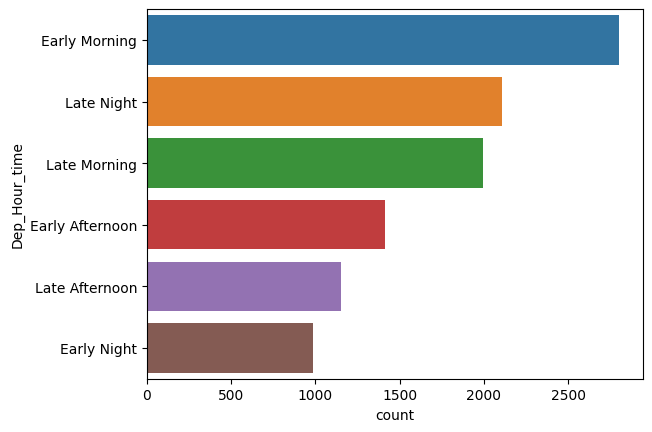

In [36]:
sns.countplot(data = df , y = 'Dep_Hour_time' , order = df['Dep_Hour_time'].value_counts().index)

## Arrival_Time

In [37]:
df['Arrival_Time'] = df['Arrival_Time'].apply(lambda x : x.split(' ')[0])

In [38]:
df

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Journey_Year,Journey_Month,Journey_Day,Season,route_check,Dep_Hour_time
0,IndiGo,2019-03-24,Banglore,New Delhi,BLR → DEL,22:20:00,01:10,2h 50m,non-stop,No info,3897,2019,3,Sunday,Spring,non-stop,Late Night
1,Air India,2019-01-05,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50:00,13:15,7h 25m,2 stops,No info,7662,2019,1,Saturday,Winter,2 stops,Early Morning
2,Jet Airways,2019-09-06,Delhi,Cochin,DEL → LKO → BOM → COK,09:25:00,04:25,19h,2 stops,No info,13882,2019,9,Friday,Autumn,2 stops,Late Morning
3,IndiGo,2019-12-05,Kolkata,Banglore,CCU → NAG → BLR,18:05:00,23:30,5h 25m,1 stop,No info,6218,2019,12,Thursday,Winter,1 stop,Early Night
4,IndiGo,2019-01-03,Banglore,New Delhi,BLR → NAG → DEL,16:50:00,21:35,4h 45m,1 stop,No info,13302,2019,1,Thursday,Winter,1 stop,Late Afternoon
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10443,Air Asia,2019-09-04,Kolkata,Banglore,CCU → BLR,19:55:00,22:25,2h 30m,non-stop,No info,4107,2019,9,Wednesday,Autumn,non-stop,Early Night
10444,Air India,2019-04-27,Kolkata,Banglore,CCU → BLR,20:45:00,23:20,2h 35m,non-stop,No info,4145,2019,4,Saturday,Spring,non-stop,Late Night
10445,Jet Airways,2019-04-27,Banglore,Delhi,BLR → DEL,08:20:00,11:20,3h,non-stop,No info,7229,2019,4,Saturday,Spring,non-stop,Early Morning
10446,Vistara,2019-01-03,Banglore,New Delhi,BLR → DEL,11:30:00,14:10,2h 40m,non-stop,No info,12648,2019,1,Thursday,Winter,non-stop,Late Morning


In [39]:
df['Arrival_Time'] = pd.to_datetime(df['Arrival_Time']).dt.time

In [40]:
df

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Journey_Year,Journey_Month,Journey_Day,Season,route_check,Dep_Hour_time
0,IndiGo,2019-03-24,Banglore,New Delhi,BLR → DEL,22:20:00,01:10:00,2h 50m,non-stop,No info,3897,2019,3,Sunday,Spring,non-stop,Late Night
1,Air India,2019-01-05,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50:00,13:15:00,7h 25m,2 stops,No info,7662,2019,1,Saturday,Winter,2 stops,Early Morning
2,Jet Airways,2019-09-06,Delhi,Cochin,DEL → LKO → BOM → COK,09:25:00,04:25:00,19h,2 stops,No info,13882,2019,9,Friday,Autumn,2 stops,Late Morning
3,IndiGo,2019-12-05,Kolkata,Banglore,CCU → NAG → BLR,18:05:00,23:30:00,5h 25m,1 stop,No info,6218,2019,12,Thursday,Winter,1 stop,Early Night
4,IndiGo,2019-01-03,Banglore,New Delhi,BLR → NAG → DEL,16:50:00,21:35:00,4h 45m,1 stop,No info,13302,2019,1,Thursday,Winter,1 stop,Late Afternoon
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10443,Air Asia,2019-09-04,Kolkata,Banglore,CCU → BLR,19:55:00,22:25:00,2h 30m,non-stop,No info,4107,2019,9,Wednesday,Autumn,non-stop,Early Night
10444,Air India,2019-04-27,Kolkata,Banglore,CCU → BLR,20:45:00,23:20:00,2h 35m,non-stop,No info,4145,2019,4,Saturday,Spring,non-stop,Late Night
10445,Jet Airways,2019-04-27,Banglore,Delhi,BLR → DEL,08:20:00,11:20:00,3h,non-stop,No info,7229,2019,4,Saturday,Spring,non-stop,Early Morning
10446,Vistara,2019-01-03,Banglore,New Delhi,BLR → DEL,11:30:00,14:10:00,2h 40m,non-stop,No info,12648,2019,1,Thursday,Winter,non-stop,Late Morning


In [41]:
df['Arrival_Hour_time'] = df['Arrival_Time'].apply(hour_to_time)

## Duration

In [42]:
df

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Journey_Year,Journey_Month,Journey_Day,Season,route_check,Dep_Hour_time,Arrival_Hour_time
0,IndiGo,2019-03-24,Banglore,New Delhi,BLR → DEL,22:20:00,01:10:00,2h 50m,non-stop,No info,3897,2019,3,Sunday,Spring,non-stop,Late Night,Late Night
1,Air India,2019-01-05,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50:00,13:15:00,7h 25m,2 stops,No info,7662,2019,1,Saturday,Winter,2 stops,Early Morning,Early Afternoon
2,Jet Airways,2019-09-06,Delhi,Cochin,DEL → LKO → BOM → COK,09:25:00,04:25:00,19h,2 stops,No info,13882,2019,9,Friday,Autumn,2 stops,Late Morning,Late Night
3,IndiGo,2019-12-05,Kolkata,Banglore,CCU → NAG → BLR,18:05:00,23:30:00,5h 25m,1 stop,No info,6218,2019,12,Thursday,Winter,1 stop,Early Night,Late Night
4,IndiGo,2019-01-03,Banglore,New Delhi,BLR → NAG → DEL,16:50:00,21:35:00,4h 45m,1 stop,No info,13302,2019,1,Thursday,Winter,1 stop,Late Afternoon,Late Night
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10443,Air Asia,2019-09-04,Kolkata,Banglore,CCU → BLR,19:55:00,22:25:00,2h 30m,non-stop,No info,4107,2019,9,Wednesday,Autumn,non-stop,Early Night,Late Night
10444,Air India,2019-04-27,Kolkata,Banglore,CCU → BLR,20:45:00,23:20:00,2h 35m,non-stop,No info,4145,2019,4,Saturday,Spring,non-stop,Late Night,Late Night
10445,Jet Airways,2019-04-27,Banglore,Delhi,BLR → DEL,08:20:00,11:20:00,3h,non-stop,No info,7229,2019,4,Saturday,Spring,non-stop,Early Morning,Late Morning
10446,Vistara,2019-01-03,Banglore,New Delhi,BLR → DEL,11:30:00,14:10:00,2h 40m,non-stop,No info,12648,2019,1,Thursday,Winter,non-stop,Late Morning,Early Afternoon


In [43]:
def fix_duration(duration):
  if len(duration.split(' ')) == 2 :
    return (int(duration.split(' ')[0][:-1]) * 60) + int(duration.split(' ')[1][:-1])
  else:
    if duration[-1] == 'h' :
      return int(duration[:-1]) * 60
    else :
      return int(duration[:-1])

In [44]:
df['Duration(Mins)'] = df['Duration'].apply(fix_duration)

In [45]:
df

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Journey_Year,Journey_Month,Journey_Day,Season,route_check,Dep_Hour_time,Arrival_Hour_time,Duration(Mins)
0,IndiGo,2019-03-24,Banglore,New Delhi,BLR → DEL,22:20:00,01:10:00,2h 50m,non-stop,No info,3897,2019,3,Sunday,Spring,non-stop,Late Night,Late Night,170
1,Air India,2019-01-05,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50:00,13:15:00,7h 25m,2 stops,No info,7662,2019,1,Saturday,Winter,2 stops,Early Morning,Early Afternoon,445
2,Jet Airways,2019-09-06,Delhi,Cochin,DEL → LKO → BOM → COK,09:25:00,04:25:00,19h,2 stops,No info,13882,2019,9,Friday,Autumn,2 stops,Late Morning,Late Night,1140
3,IndiGo,2019-12-05,Kolkata,Banglore,CCU → NAG → BLR,18:05:00,23:30:00,5h 25m,1 stop,No info,6218,2019,12,Thursday,Winter,1 stop,Early Night,Late Night,325
4,IndiGo,2019-01-03,Banglore,New Delhi,BLR → NAG → DEL,16:50:00,21:35:00,4h 45m,1 stop,No info,13302,2019,1,Thursday,Winter,1 stop,Late Afternoon,Late Night,285
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10443,Air Asia,2019-09-04,Kolkata,Banglore,CCU → BLR,19:55:00,22:25:00,2h 30m,non-stop,No info,4107,2019,9,Wednesday,Autumn,non-stop,Early Night,Late Night,150
10444,Air India,2019-04-27,Kolkata,Banglore,CCU → BLR,20:45:00,23:20:00,2h 35m,non-stop,No info,4145,2019,4,Saturday,Spring,non-stop,Late Night,Late Night,155
10445,Jet Airways,2019-04-27,Banglore,Delhi,BLR → DEL,08:20:00,11:20:00,3h,non-stop,No info,7229,2019,4,Saturday,Spring,non-stop,Early Morning,Late Morning,180
10446,Vistara,2019-01-03,Banglore,New Delhi,BLR → DEL,11:30:00,14:10:00,2h 40m,non-stop,No info,12648,2019,1,Thursday,Winter,non-stop,Late Morning,Early Afternoon,160


In [46]:
# Describe duration(mins) column :
df['Duration(Mins)'].describe()

count    10448.000000
mean       629.852125
std        500.981027
min          5.000000
25%        170.000000
50%        505.000000
75%        910.000000
max       2860.000000
Name: Duration(Mins), dtype: float64

We have min value of 5 mins which is not logical for a flight duration

<Axes: xlabel='Duration(Mins)'>

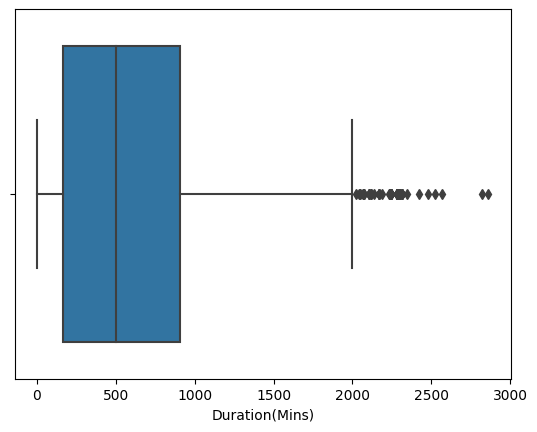

In [47]:
sns.boxplot(data = df , x = 'Duration(Mins)')

I considered the outliers in duration column is a reult of a possible layout stops which may occur naturally between flights

## Total_stops

In [48]:
df['Total_Stops'].value_counts()

1 stop      5611
non-stop    3475
2 stops     1318
3 stops       43
4 stops        1
Name: Total_Stops, dtype: int64

<Axes: xlabel='Total_Stops', ylabel='count'>

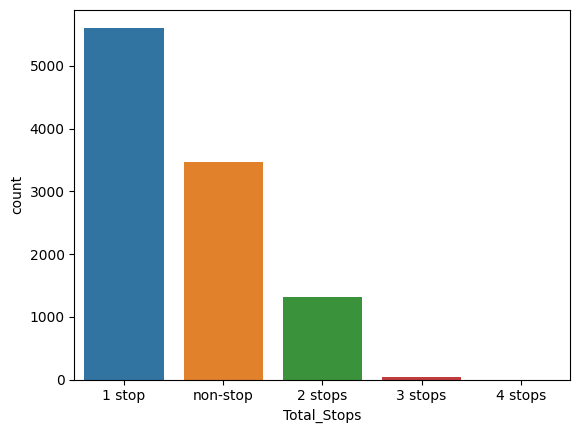

In [49]:
sns.countplot(data = df , x = 'Total_Stops' , order = df['Total_Stops'].value_counts().index)

In [50]:
df['Total_Stops'] = df['Total_Stops'].str.replace('4 stops' , '3 stops')
df['Total_Stops'] = df['Total_Stops'].str.replace('3 stops' , '3 or more')

## Additional_Info

In [51]:
df['Additional_Info'].value_counts()

No info                         8168
In-flight meal not included     1926
No check-in baggage included     318
1 Long layover                    19
Change airports                    7
Business class                     4
No Info                            3
1 Short layover                    1
Red-eye flight                     1
2 Long layover                     1
Name: Additional_Info, dtype: int64

# **Questions**

## What is the average price difference per Airline?

In [52]:
df.groupby('Airline')['Price'].mean().sort_values(ascending = False)

Airline
Jet Airways          11674.724771
Multiple carriers    10902.678094
Air India             9556.608028
Vistara               7808.596674
GoAir                 5861.056701
IndiGo                5668.469897
Air Asia              5590.260188
SpiceJet              4335.841718
Name: Price, dtype: float64

<Axes: xlabel='Airline'>

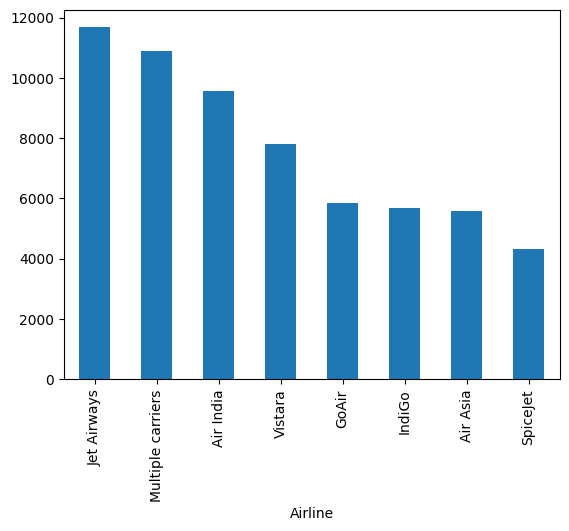

In [53]:
df.groupby('Airline')['Price'].mean().sort_values(ascending = False).plot(kind='bar')

## What is the average flight duration per Airline?

In [54]:
df.groupby('Airline')['Duration(Mins)'].mean().sort_values(ascending = False)

Airline
Air India            926.912633
Jet Airways          830.098489
Multiple carriers    625.769231
Vistara              596.548857
Air Asia             348.275862
GoAir                298.969072
IndiGo               285.956926
SpiceJet             178.515337
Name: Duration(Mins), dtype: float64

## What is the season with the most flights?

In [55]:
df['Season'].value_counts().to_frame().iloc[0]

Season    4605
Name: Spring, dtype: int64

## Does Season Affect Price?

<Axes: xlabel='Season', ylabel='Price'>

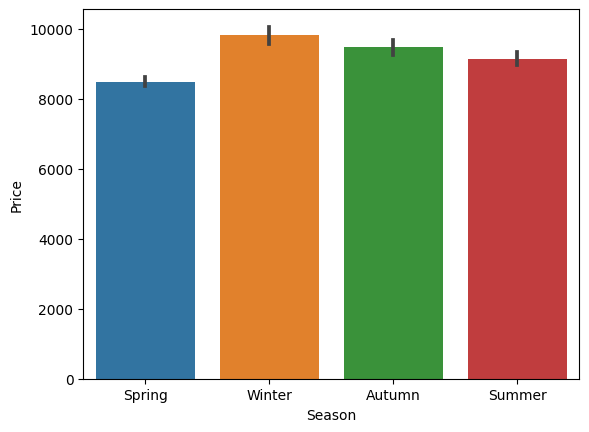

In [56]:
sns.barplot(data = df , x = 'Season' , y='Price')

Seems like flights occured in winter season has higher price , due to special winter events like christmas and flights occured in Spring have the lowest price

## does flight departure time affect price?

<Axes: xlabel='Price', ylabel='Dep_Hour_time'>

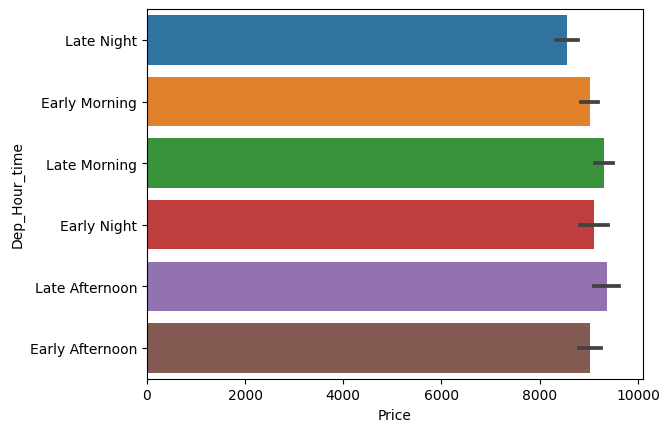

In [57]:
sns.barplot(data = df , y = 'Dep_Hour_time' , x ='Price')

Seems that flights which occured in Late Night have the lowest price and flights occured in Late Afternoon have the highest price

## What is the day time with most flights?

In [58]:
df['Dep_Hour_time'].value_counts().to_frame().iloc[0]

Dep_Hour_time    2802
Name: Early Morning, dtype: int64

## What is the average price difference per day time?

In [59]:
df.groupby('Dep_Hour_time')['Price'].mean().sort_values(ascending = False)

Dep_Hour_time
Late Afternoon     9359.935652
Late Morning       9300.723896
Early Night        9103.686992
Early Afternoon    9030.231586
Early Morning      9016.719843
Late Night         8548.938805
Name: Price, dtype: float64

Most expensive flights are those which occured in Late Afternoon

## Does flight duration affect price?

<Axes: xlabel='Duration(Mins)', ylabel='Price'>

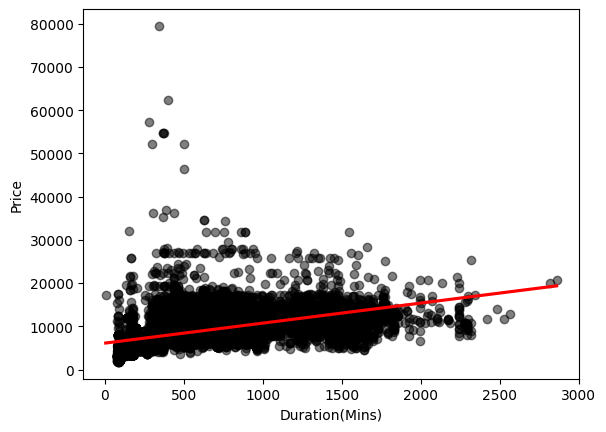

In [60]:
sns.regplot(data = df , x = 'Duration(Mins)' , y = 'Price', scatter_kws = {"color": "black", "alpha": 0.5},
            line_kws = {"color": "red"})

Duration and price have slight moderate positive correlation


## Does flight day affect price?

<Axes: xlabel='Price', ylabel='Journey_Day'>

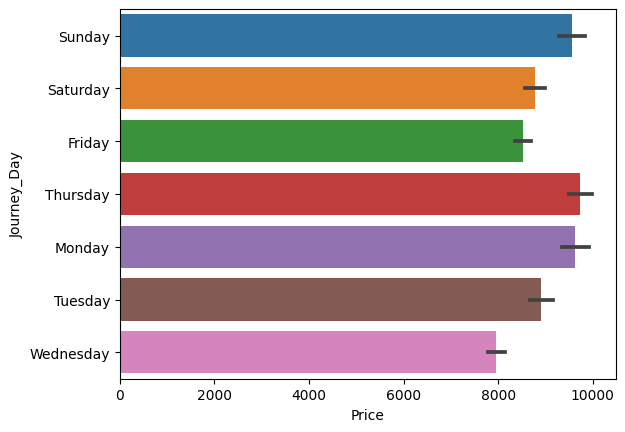

In [61]:
sns.barplot(data = df , y = 'Journey_Day' , x = 'Price')

Flights that take off and land on weekends, or Mondays and Fridays generally cost more. So aim for Tuesdays, Wednesdays and Thursdays


## Where are most flights originate from?

<Axes: xlabel='count', ylabel='Source'>

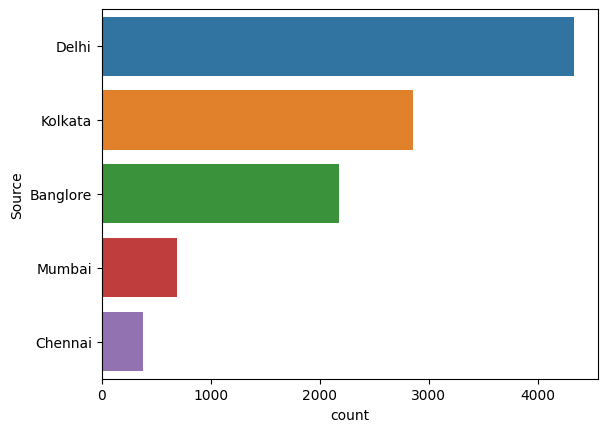

In [62]:
sns.countplot(data = df , y = 'Source' , order = df['Source'].value_counts().index)

looks like most flights originate from delhi and kolkata

## Where are most flights destination?

<Axes: xlabel='count', ylabel='Destination'>

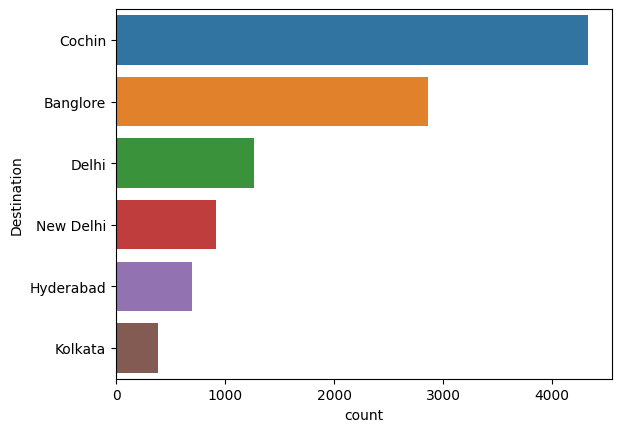

In [63]:
sns.countplot(data = df , y = 'Destination' , order = df['Destination'].value_counts().index)

Looks like most flights destinations are to cochin and bangalore

# **Machine Learning**

## Primary_Trial

In [64]:
ml_df = df.copy()

In [65]:
ml_df

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Journey_Year,Journey_Month,Journey_Day,Season,route_check,Dep_Hour_time,Arrival_Hour_time,Duration(Mins)
0,IndiGo,2019-03-24,Banglore,New Delhi,BLR → DEL,22:20:00,01:10:00,2h 50m,non-stop,No info,3897,2019,3,Sunday,Spring,non-stop,Late Night,Late Night,170
1,Air India,2019-01-05,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50:00,13:15:00,7h 25m,2 stops,No info,7662,2019,1,Saturday,Winter,2 stops,Early Morning,Early Afternoon,445
2,Jet Airways,2019-09-06,Delhi,Cochin,DEL → LKO → BOM → COK,09:25:00,04:25:00,19h,2 stops,No info,13882,2019,9,Friday,Autumn,2 stops,Late Morning,Late Night,1140
3,IndiGo,2019-12-05,Kolkata,Banglore,CCU → NAG → BLR,18:05:00,23:30:00,5h 25m,1 stop,No info,6218,2019,12,Thursday,Winter,1 stop,Early Night,Late Night,325
4,IndiGo,2019-01-03,Banglore,New Delhi,BLR → NAG → DEL,16:50:00,21:35:00,4h 45m,1 stop,No info,13302,2019,1,Thursday,Winter,1 stop,Late Afternoon,Late Night,285
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10443,Air Asia,2019-09-04,Kolkata,Banglore,CCU → BLR,19:55:00,22:25:00,2h 30m,non-stop,No info,4107,2019,9,Wednesday,Autumn,non-stop,Early Night,Late Night,150
10444,Air India,2019-04-27,Kolkata,Banglore,CCU → BLR,20:45:00,23:20:00,2h 35m,non-stop,No info,4145,2019,4,Saturday,Spring,non-stop,Late Night,Late Night,155
10445,Jet Airways,2019-04-27,Banglore,Delhi,BLR → DEL,08:20:00,11:20:00,3h,non-stop,No info,7229,2019,4,Saturday,Spring,non-stop,Early Morning,Late Morning,180
10446,Vistara,2019-01-03,Banglore,New Delhi,BLR → DEL,11:30:00,14:10:00,2h 40m,non-stop,No info,12648,2019,1,Thursday,Winter,non-stop,Late Morning,Early Afternoon,160


In [66]:
# drop unnecessary columns :
ml_df.drop(['Date_of_Journey','Route','Dep_Time' , 'Arrival_Time','Duration','Additional_Info','Journey_Year','Journey_Month','route_check'] , axis = 1 , inplace=True)
ml_df

,Airline,Source,Destination,Total_Stops,Price,Journey_Day,Season,Dep_Hour_time,Arrival_Hour_time,Duration(Mins)
0,IndiGo,Banglore,New Delhi,non-stop,3897,Sunday,Spring,Late Night,Late Night,170
1,Air India,Kolkata,Banglore,2 stops,7662,Saturday,Winter,Early Morning,Early Afternoon,445
2,Jet Airways,Delhi,Cochin,2 stops,13882,Friday,Autumn,Late Morning,Late Night,1140
3,IndiGo,Kolkata,Banglore,1 stop,6218,Thursday,Winter,Early Night,Late Night,325
4,IndiGo,Banglore,New Delhi,1 stop,13302,Thursday,Winter,Late Afternoon,Late Night,285
...,...,...,...,...,...,...,...,...,...,...
10443,Air Asia,Kolkata,Banglore,non-stop,4107,Wednesday,Autumn,Early Night,Late Night,150
10444,Air India,Kolkata,Banglore,non-stop,4145,Saturday,Spring,Late Night,Late Night,155
10445,Jet Airways,Banglore,Delhi,non-stop,7229,Saturday,Spring,Early Morning,Late Morning,180
10446,Vistara,Banglore,New Delhi,non-stop,12648,Thursday,Winter,Late Morning,Early Afternoon,160


In [67]:
# check category columns uniques for encoding
for col in ml_df.select_dtypes('object').columns :
  print(f'{col} Column has {df[col].nunique()} uniques.')

Airline Column has 8 uniques.
Source Column has 5 uniques.
Destination Column has 6 uniques.
Total_Stops Column has 4 uniques.
Journey_Day Column has 7 uniques.
Season Column has 4 uniques.
Dep_Hour_time Column has 6 uniques.
Arrival_Hour_time Column has 6 uniques.


In [68]:
encoder = ColumnTransformer(transformers = [
    ('Ohe' , OneHotEncoder(sparse_output=False , drop='first') , ['Total_Stops','Source' , 'Destination']),
    ('Le' ,  OrdinalEncoder() , ['Season' , 'Journey_Day' , 'Dep_Hour_time' , 'Arrival_Hour_time']),
    ('Be' , BinaryEncoder() , ['Airline'])
] , remainder='passthrough')

In [70]:
encoder = ColumnTransformer(transformers = [
    ('Ohe' , OneHotEncoder(sparse_output=False , drop='first') , ml_df.select_dtypes('object').columns),
] , remainder='passthrough')

In [69]:
models = {
    'LinearRegression' : LinearRegression(),
    'KNN' : KNeighborsRegressor(n_neighbors=5),
    'DecisionTree' : DecisionTreeRegressor() ,
    'RandomForest' : RandomForestRegressor(),
    'XGB' : XGBRegressor()
}

In [72]:
X , y = ml_df.drop('Price' , axis=1) , ml_df['Price']

In [73]:
model_name = []
train = []
test = []
for name , model in models.items() :
  pipeline = Pipeline(steps = [
    ('encoder' , encoder),
    ('sclr' , RobustScaler()),
    ('model' , model)
    ])
  scores = cross_validate(pipeline , X , y , cv=KFold(5) , scoring='r2' , return_train_score=True)
  model_name.append(name)
  train.append(scores['train_score'].mean())
  test.append(scores['test_score'].mean())

final = pd.DataFrame({
    'Model_Name' : model_name,
    'Train_R2' : train,
    'Test_R2' : test
})

display(final)

,Model_Name,Train_R2,Test_R2
0,LinearRegression,0.569217,0.565193
1,KNN,0.790516,0.673684
2,DecisionTree,0.954106,0.574003
3,RandomForest,0.928529,0.706309
4,XGB,0.899691,0.754016


In [ ]:
models = {
    'XGB' :XGBRegressor,
}
def objective(trial)  :

   X , y = ml_df.drop('Price',axis=1) , ml_df['Price']
   param = get_params(trial)
   print(Model(**param))


   model = Pipeline(steps=[
    ('encoder' , encoder)   ,
    ('sclr' , RobustScaler()),
    (model_name , Model(**param))])




   scores = cross_val_score(model,X,y,cv=KFold(7) , scoring = 'r2')

   return scores.mean()


def get_params(trial) :

   params = {


       #   'LinearRegression' : {
        #                          'fit_intercept' : choice([True,False])
         #                     },

          #'KNN'              : {
               #                   'n_neighbors' : trial.suggest_int('n_neighbors' , 1 , 8)
                #              } ,
         # 'DecisionTree'     : {
          #                        'max_depth' : trial.suggest_int('max_depth',1,10),
           #                       'splitter'  : choice(['best' , 'random']),
            #                      'max_features' : trial.suggest_uniform('max_features' ,0 ,1)
             #                 },
        #  'RandomForest'     : {
         #                         'max_depth' : trial.suggest_int('max_depth' , 1 , 50),
          #                        'n_estimators' : trial.suggest_int('n_estimators' , 50 , 300),
           #                       'max_features' : trial.suggest_uniform('max_features',0,1),
                                #  'min_samples_split' : trial.suggest_int('min_samples_split',2,4),
            #                      'bootstrap' : trial.suggest_categorical('bootstrap' , [True,False])
             #                   },
          'XGB'              : {
                                  'max_depth' : trial.suggest_int('max_depth' , 10 , 40),
                                  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
                                  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
                                  'colsample_bynode' : trial.suggest_uniform('colsample_bynode' ,0,1),
                                 # 'subsample' : trial.suggest_uniform('subsample',0.01 , 1),
                                  'eta' : trial.suggest_uniform('eta',0,1),
                                  'lambda' : trial.suggest_int('lambda',0,1000),
                                  'alpha' : trial.suggest_int('alpha',0,1000),
                                  'gamma' : trial.suggest_int('gamma' ,0 , 1000),
                                  'n_estimators': trial.suggest_int('n_estimators',50,500),
                                 # 'learning_rate' : trial.suggest_float('learning_rate',1,10)
                                }
       #    'LGBM'             : {
        #                          'max_depth' : trial.suggest_int('max_depth',1,40),
         #                         'num_leaves' : trial.suggest_int('num_leaves' , 10 , 70),
          #                        'learning_rate' : trial.suggest_uniform('learning_rate',0,1),
           #                       'n_estimators' : trial.suggest_int('n_estimators',50,300),
            #                      'colsample_bytree' : trial.suggest_uniform('colsample_bytree',0,1),
             #                     'reg_alpha' : trial.suggest_float('reg_alpha',0,1000),
              #                    'reg_lambda' : trial.suggest_float('reg_lambda',0,1000)
               #                 }
          #'Adaboost'         : {
           #                       'n_estimators' : trial.suggest_int('n_estimators',1,100),
            #                      'learning_rate' : trial.suggest_float('learning_rate',1,10),
             #                     'loss' : choice(['linear','square','exponential'])
              #                  },
          #'CatBoost'         : {
           #                       'learning_rate' : trial.suggest_uniform('learning_rate' ,0 ,1),
            #                      'depth' : trial.suggest_int('depth',1,10)
             #                   }
        }

   return params[model_name]




#modelname = []
best_estimator = []


for model_name , Model in models.items() :


  #if model_name == 'RandomForest' :
   # trials = 50
  #elif model_name == 'LGBM' :
  #  trials = 25
  #else:
   # trials = 200

  study = optuna.create_study(study_name= model_name , direction='maximize')
  study.optimize(objective, n_trials=200)
 # modelname.append(model_name)
 # train_r2.append(optuna.cv_results_['mean_train_r2'].mean())
 # test_r2.append(optuna.cv_results_['mean_test_r2'].mean())
 # train_rmse.append(grid.cv_results_['mean_train_neg_root_mean_squared_error'].mean() * -1)
 # test_rmse.append(optuna.cv_results_['mean_test_neg_root_mean_squared_error'].mean() * -1)
 # train_mae.append(optuna.cv_results_['mean_train_neg_mean_absolute_error'].mean() * -1)
 # test_mae.append(optuna.cv_results_['mean_test_neg_mean_absolute_error'].mean() * -1)
  best_estimator.append(Pipeline(steps=[

          ('encoder' , encoder)   ,
          ('sclr' , RobustScaler()),
          (model_name , Model(**study.best_params))
      ])
)
  #best_score.append(optuna.best_score_ * -1)




[I 2023-12-30 21:27:58,884] A new study created in memory with name: XGB
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a>:52: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bynode' : trial.suggest_uniform('colsample_bynode' ,0,1),
<ipython-input-275-0bdf3904af6a>:54: F

XGBRegressor(alpha=204, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.2328313719272299,
             colsample_bynode=0.8060548274821824,
             colsample_bytree=0.8814049769989021, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.039045788172194174, eval_metric=None, feature_types=None,
             gamma=710, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=31, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=15, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=214, ...)


[I 2023-12-30 21:28:02,026] Trial 0 finished with value: 0.7258815767524881 and parameters: {'max_depth': 15, 'colsample_bytree': 0.8814049769989021, 'colsample_bylevel': 0.2328313719272299, 'colsample_bynode': 0.8060548274821824, 'eta': 0.039045788172194174, 'lambda': 31, 'alpha': 204, 'gamma': 710, 'n_estimators': 214}. Best is trial 0 with value: 0.7258815767524881.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a>:5

XGBRegressor(alpha=649, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.45769882801609263,
             colsample_bynode=0.9909043803139964,
             colsample_bytree=0.4666825595067854, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.23446194931412268, eval_metric=None, feature_types=None,
             gamma=78, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=752, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=25, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=415, ...)


[I 2023-12-30 21:28:05,877] Trial 1 finished with value: 0.7302260797698544 and parameters: {'max_depth': 25, 'colsample_bytree': 0.4666825595067854, 'colsample_bylevel': 0.45769882801609263, 'colsample_bynode': 0.9909043803139964, 'eta': 0.23446194931412268, 'lambda': 752, 'alpha': 649, 'gamma': 78, 'n_estimators': 415}. Best is trial 1 with value: 0.7302260797698544.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a>:5

XGBRegressor(alpha=119, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.18711183450401359,
             colsample_bynode=0.3996325338107316,
             colsample_bytree=0.8155810264604328, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.3057376199887267, eval_metric=None, feature_types=None,
             gamma=985, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=38, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=38, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=355, ...)


[I 2023-12-30 21:28:08,572] Trial 2 finished with value: 0.7174226279014849 and parameters: {'max_depth': 38, 'colsample_bytree': 0.8155810264604328, 'colsample_bylevel': 0.18711183450401359, 'colsample_bynode': 0.3996325338107316, 'eta': 0.3057376199887267, 'lambda': 38, 'alpha': 119, 'gamma': 985, 'n_estimators': 355}. Best is trial 1 with value: 0.7302260797698544.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a>:52

XGBRegressor(alpha=395, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.5581361322666153,
             colsample_bynode=0.9826153749111064,
             colsample_bytree=0.47819525750131875, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.9763927868593419, eval_metric=None, feature_types=None,
             gamma=8, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=750, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=36, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=121, ...)


[I 2023-12-30 21:28:11,839] Trial 3 finished with value: 0.7436289420856449 and parameters: {'max_depth': 36, 'colsample_bytree': 0.47819525750131875, 'colsample_bylevel': 0.5581361322666153, 'colsample_bynode': 0.9826153749111064, 'eta': 0.9763927868593419, 'lambda': 750, 'alpha': 395, 'gamma': 8, 'n_estimators': 121}. Best is trial 3 with value: 0.7436289420856449.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a>:52:

XGBRegressor(alpha=73, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.8603866143367567,
             colsample_bynode=0.9273416160847958,
             colsample_bytree=0.2391517178299445, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.9327105174876437, eval_metric=None, feature_types=None,
             gamma=721, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=168, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=14, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=249, ...)


[I 2023-12-30 21:28:14,200] Trial 4 finished with value: 0.7457818882347588 and parameters: {'max_depth': 14, 'colsample_bytree': 0.2391517178299445, 'colsample_bylevel': 0.8603866143367567, 'colsample_bynode': 0.9273416160847958, 'eta': 0.9327105174876437, 'lambda': 168, 'alpha': 73, 'gamma': 721, 'n_estimators': 249}. Best is trial 4 with value: 0.7457818882347588.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a>:52:

XGBRegressor(alpha=354, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.7901110046484182,
             colsample_bynode=0.57230663863625,
             colsample_bytree=0.15040721138611823, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.6006500103679264, eval_metric=None, feature_types=None,
             gamma=701, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=972, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=21, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=56, ...)


[I 2023-12-30 21:28:14,969] Trial 5 finished with value: 0.5464793640421506 and parameters: {'max_depth': 21, 'colsample_bytree': 0.15040721138611823, 'colsample_bylevel': 0.7901110046484182, 'colsample_bynode': 0.57230663863625, 'eta': 0.6006500103679264, 'lambda': 972, 'alpha': 354, 'gamma': 701, 'n_estimators': 56}. Best is trial 4 with value: 0.7457818882347588.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a>:52: 

XGBRegressor(alpha=255, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.4478609897350945,
             colsample_bynode=0.019439830752947418,
             colsample_bytree=0.9595839834222774, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.8678541299630909, eval_metric=None, feature_types=None,
             gamma=928, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=526, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=40, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=201, ...)


[I 2023-12-30 21:28:16,448] Trial 6 finished with value: 0.6802652189992694 and parameters: {'max_depth': 40, 'colsample_bytree': 0.9595839834222774, 'colsample_bylevel': 0.4478609897350945, 'colsample_bynode': 0.019439830752947418, 'eta': 0.8678541299630909, 'lambda': 526, 'alpha': 255, 'gamma': 928, 'n_estimators': 201}. Best is trial 4 with value: 0.7457818882347588.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a>:

XGBRegressor(alpha=701, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.8163644806927511,
             colsample_bynode=0.5129064986135728,
             colsample_bytree=0.6224531500201675, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.43958891891381835, eval_metric=None, feature_types=None,
             gamma=229, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=767, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=24, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=113, ...)


[I 2023-12-30 21:28:18,417] Trial 7 finished with value: 0.7341941859676122 and parameters: {'max_depth': 24, 'colsample_bytree': 0.6224531500201675, 'colsample_bylevel': 0.8163644806927511, 'colsample_bynode': 0.5129064986135728, 'eta': 0.43958891891381835, 'lambda': 767, 'alpha': 701, 'gamma': 229, 'n_estimators': 113}. Best is trial 4 with value: 0.7457818882347588.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a>:5

XGBRegressor(alpha=911, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.05470581929228846,
             colsample_bynode=0.28753136990134476,
             colsample_bytree=0.7026221505190373, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.9720020206628942, eval_metric=None, feature_types=None,
             gamma=108, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=3, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=13, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=319, ...)


[I 2023-12-30 21:28:20,428] Trial 8 finished with value: 0.7278284156601232 and parameters: {'max_depth': 13, 'colsample_bytree': 0.7026221505190373, 'colsample_bylevel': 0.05470581929228846, 'colsample_bynode': 0.28753136990134476, 'eta': 0.9720020206628942, 'lambda': 3, 'alpha': 911, 'gamma': 108, 'n_estimators': 319}. Best is trial 4 with value: 0.7457818882347588.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a>:52

XGBRegressor(alpha=714, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.2021615082175251,
             colsample_bynode=0.7008525031355881,
             colsample_bytree=0.8074214106057886, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.30530182590866317, eval_metric=None, feature_types=None,
             gamma=947, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=136, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=18, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=159, ...)


[I 2023-12-30 21:28:24,083] Trial 9 finished with value: 0.731342491134022 and parameters: {'max_depth': 18, 'colsample_bytree': 0.8074214106057886, 'colsample_bylevel': 0.2021615082175251, 'colsample_bynode': 0.7008525031355881, 'eta': 0.30530182590866317, 'lambda': 136, 'alpha': 714, 'gamma': 947, 'n_estimators': 159}. Best is trial 4 with value: 0.7457818882347588.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a>:52

XGBRegressor(alpha=54, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.9612381149888148,
             colsample_bynode=0.7779229615982525,
             colsample_bytree=0.07940377916601923, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.6944647910237551, eval_metric=None, feature_types=None,
             gamma=413, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=306, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=497, ...)


[I 2023-12-30 21:28:26,192] Trial 10 finished with value: 0.5569286104921266 and parameters: {'max_depth': 10, 'colsample_bytree': 0.07940377916601923, 'colsample_bylevel': 0.9612381149888148, 'colsample_bynode': 0.7779229615982525, 'eta': 0.6944647910237551, 'lambda': 306, 'alpha': 54, 'gamma': 413, 'n_estimators': 497}. Best is trial 4 with value: 0.7457818882347588.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a>:5

XGBRegressor(alpha=445, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.6818346419292153,
             colsample_bynode=0.9861216592259284,
             colsample_bytree=0.32900838578798614, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.8001023677142483, eval_metric=None, feature_types=None,
             gamma=597, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=447, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=32, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=252, ...)


[I 2023-12-30 21:28:28,590] Trial 11 finished with value: 0.7414679396115128 and parameters: {'max_depth': 32, 'colsample_bytree': 0.32900838578798614, 'colsample_bylevel': 0.6818346419292153, 'colsample_bynode': 0.9861216592259284, 'eta': 0.8001023677142483, 'lambda': 447, 'alpha': 445, 'gamma': 597, 'n_estimators': 252}. Best is trial 4 with value: 0.7457818882347588.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a>:

XGBRegressor(alpha=16, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.6076734846474791,
             colsample_bynode=0.8432181245287318,
             colsample_bytree=0.3279072514147379, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.9685423088628216, eval_metric=None, feature_types=None,
             gamma=390, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=655, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=34, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=77, ...)


[I 2023-12-30 21:28:29,617] Trial 12 finished with value: 0.667928799034561 and parameters: {'max_depth': 34, 'colsample_bytree': 0.3279072514147379, 'colsample_bylevel': 0.6076734846474791, 'colsample_bynode': 0.8432181245287318, 'eta': 0.9685423088628216, 'lambda': 655, 'alpha': 16, 'gamma': 390, 'n_estimators': 77}. Best is trial 4 with value: 0.7457818882347588.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a>:52: 

XGBRegressor(alpha=520, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.9975355515816114,
             colsample_bynode=0.9963094691447162,
             colsample_bytree=0.29067720193739194, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.7791746483546439, eval_metric=None, feature_types=None,
             gamma=759, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=987, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=32, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=160, ...)


[I 2023-12-30 21:28:31,437] Trial 13 finished with value: 0.7217110305350749 and parameters: {'max_depth': 32, 'colsample_bytree': 0.29067720193739194, 'colsample_bylevel': 0.9975355515816114, 'colsample_bynode': 0.9963094691447162, 'eta': 0.7791746483546439, 'lambda': 987, 'alpha': 520, 'gamma': 759, 'n_estimators': 160}. Best is trial 4 with value: 0.7457818882347588.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a>:

XGBRegressor(alpha=307, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.5875786525300307,
             colsample_bynode=0.6595593618645951,
             colsample_bytree=0.4940737035180774, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.9931448292633823, eval_metric=None, feature_types=None,
             gamma=278, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=246, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=29, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=265, ...)


[I 2023-12-30 21:28:36,542] Trial 14 finished with value: 0.7503291147778565 and parameters: {'max_depth': 29, 'colsample_bytree': 0.4940737035180774, 'colsample_bylevel': 0.5875786525300307, 'colsample_bynode': 0.6595593618645951, 'eta': 0.9931448292633823, 'lambda': 246, 'alpha': 307, 'gamma': 278, 'n_estimators': 265}. Best is trial 14 with value: 0.7503291147778565.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a>:

XGBRegressor(alpha=196, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.8040173986961137,
             colsample_bynode=0.6130033728063103,
             colsample_bytree=0.00032128601900682785, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.608643995703879, eval_metric=None, feature_types=None,
             gamma=283, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=226, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=29, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=306, ...)


[I 2023-12-30 21:28:38,197] Trial 15 finished with value: 0.5557890415106091 and parameters: {'max_depth': 29, 'colsample_bytree': 0.00032128601900682785, 'colsample_bylevel': 0.8040173986961137, 'colsample_bynode': 0.6130033728063103, 'eta': 0.608643995703879, 'lambda': 226, 'alpha': 196, 'gamma': 283, 'n_estimators': 306}. Best is trial 14 with value: 0.7503291147778565.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6

XGBRegressor(alpha=209, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.392947666135267,
             colsample_bynode=0.3008211001969453,
             colsample_bytree=0.21412968825699952, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.8059196893830991, eval_metric=None, feature_types=None,
             gamma=516, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=340, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=29, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=383, ...)


[I 2023-12-30 21:28:40,256] Trial 16 finished with value: 0.6876301695729155 and parameters: {'max_depth': 29, 'colsample_bytree': 0.21412968825699952, 'colsample_bylevel': 0.392947666135267, 'colsample_bynode': 0.3008211001969453, 'eta': 0.8059196893830991, 'lambda': 340, 'alpha': 209, 'gamma': 516, 'n_estimators': 383}. Best is trial 14 with value: 0.7503291147778565.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a>:

XGBRegressor(alpha=322, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.6979861166783661,
             colsample_bynode=0.6817169349246985,
             colsample_bytree=0.5779958689568321, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.487485412326068, eval_metric=None, feature_types=None,
             gamma=254, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=210, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=19, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=269, ...)


[I 2023-12-30 21:28:45,472] Trial 17 finished with value: 0.7542550072230602 and parameters: {'max_depth': 19, 'colsample_bytree': 0.5779958689568321, 'colsample_bylevel': 0.6979861166783661, 'colsample_bynode': 0.6817169349246985, 'eta': 0.487485412326068, 'lambda': 210, 'alpha': 322, 'gamma': 254, 'n_estimators': 269}. Best is trial 17 with value: 0.7542550072230602.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a>:5

XGBRegressor(alpha=550, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.6751221711498604,
             colsample_bynode=0.674664038958682,
             colsample_bytree=0.5896612468942132, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.469808619890093, eval_metric=None, feature_types=None,
             gamma=236, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=365, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=21, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=295, ...)


[I 2023-12-30 21:28:52,710] Trial 18 finished with value: 0.7572342985129967 and parameters: {'max_depth': 21, 'colsample_bytree': 0.5896612468942132, 'colsample_bylevel': 0.6751221711498604, 'colsample_bynode': 0.674664038958682, 'eta': 0.469808619890093, 'lambda': 365, 'alpha': 550, 'gamma': 236, 'n_estimators': 295}. Best is trial 18 with value: 0.7572342985129967.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a>:52

XGBRegressor(alpha=564, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.6872298521024978,
             colsample_bynode=0.43925185117483495,
             colsample_bytree=0.6189216557358966, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.46296490651065597, eval_metric=None, feature_types=None,
             gamma=168, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=400, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=20, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=447, ...)


[I 2023-12-30 21:28:57,594] Trial 19 finished with value: 0.7549295273950951 and parameters: {'max_depth': 20, 'colsample_bytree': 0.6189216557358966, 'colsample_bylevel': 0.6872298521024978, 'colsample_bynode': 0.43925185117483495, 'eta': 0.46296490651065597, 'lambda': 400, 'alpha': 564, 'gamma': 168, 'n_estimators': 447}. Best is trial 18 with value: 0.7572342985129967.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a

XGBRegressor(alpha=557, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.6876905729521734,
             colsample_bynode=0.40114231670559986,
             colsample_bytree=0.694700596934318, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.13373973771029246, eval_metric=None, feature_types=None,
             gamma=156, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=446, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=22, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=470, ...)


[I 2023-12-30 21:29:04,611] Trial 20 finished with value: 0.7385827422824089 and parameters: {'max_depth': 22, 'colsample_bytree': 0.694700596934318, 'colsample_bylevel': 0.6876905729521734, 'colsample_bynode': 0.40114231670559986, 'eta': 0.13373973771029246, 'lambda': 446, 'alpha': 557, 'gamma': 156, 'n_estimators': 470}. Best is trial 18 with value: 0.7572342985129967.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a>

XGBRegressor(alpha=577, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.7107655882772838,
             colsample_bynode=0.44677714162618415,
             colsample_bytree=0.5964142700743145, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.43716664871278405, eval_metric=None, feature_types=None,
             gamma=377, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=330, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=19, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=454, ...)


[I 2023-12-30 21:29:09,659] Trial 21 finished with value: 0.7547391610742091 and parameters: {'max_depth': 19, 'colsample_bytree': 0.5964142700743145, 'colsample_bylevel': 0.7107655882772838, 'colsample_bynode': 0.44677714162618415, 'eta': 0.43716664871278405, 'lambda': 330, 'alpha': 577, 'gamma': 377, 'n_estimators': 454}. Best is trial 18 with value: 0.7572342985129967.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a

XGBRegressor(alpha=875, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.7334133858754794,
             colsample_bynode=0.3851166320690518,
             colsample_bytree=0.5976394628928948, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.39303941874748277, eval_metric=None, feature_types=None,
             gamma=396, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=552, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=17, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=434, ...)


[I 2023-12-30 21:29:16,032] Trial 22 finished with value: 0.7514240341905841 and parameters: {'max_depth': 17, 'colsample_bytree': 0.5976394628928948, 'colsample_bylevel': 0.7334133858754794, 'colsample_bynode': 0.3851166320690518, 'eta': 0.39303941874748277, 'lambda': 552, 'alpha': 875, 'gamma': 396, 'n_estimators': 434}. Best is trial 18 with value: 0.7572342985129967.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a>

XGBRegressor(alpha=631, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.9088585885421683,
             colsample_bynode=0.17526410081707028,
             colsample_bytree=0.7218231378078201, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.5668004821479056, eval_metric=None, feature_types=None,
             gamma=183, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=371, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=25, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=445, ...)


[I 2023-12-30 21:29:20,949] Trial 23 finished with value: 0.7494134954793671 and parameters: {'max_depth': 25, 'colsample_bytree': 0.7218231378078201, 'colsample_bylevel': 0.9088585885421683, 'colsample_bynode': 0.17526410081707028, 'eta': 0.5668004821479056, 'lambda': 371, 'alpha': 631, 'gamma': 183, 'n_estimators': 445}. Best is trial 18 with value: 0.7572342985129967.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a>

XGBRegressor(alpha=799, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.5224203991196401,
             colsample_bynode=0.48780305801864465,
             colsample_bytree=0.40815751344427054, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.3656480885750425, eval_metric=None, feature_types=None,
             gamma=338, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=398, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=21, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=394, ...)


[I 2023-12-30 21:29:23,201] Trial 24 finished with value: 0.6748218930122364 and parameters: {'max_depth': 21, 'colsample_bytree': 0.40815751344427054, 'colsample_bylevel': 0.5224203991196401, 'colsample_bynode': 0.48780305801864465, 'eta': 0.3656480885750425, 'lambda': 398, 'alpha': 799, 'gamma': 338, 'n_estimators': 394}. Best is trial 18 with value: 0.7572342985129967.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a

XGBRegressor(alpha=581, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.6390749025642009,
             colsample_bynode=0.4958046789850721,
             colsample_bytree=0.5887487771156719, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.5204512573858919, eval_metric=None, feature_types=None,
             gamma=506, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=616, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=17, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=342, ...)


[I 2023-12-30 21:29:28,659] Trial 25 finished with value: 0.7502111465565983 and parameters: {'max_depth': 17, 'colsample_bytree': 0.5887487771156719, 'colsample_bylevel': 0.6390749025642009, 'colsample_bynode': 0.4958046789850721, 'eta': 0.5204512573858919, 'lambda': 616, 'alpha': 581, 'gamma': 506, 'n_estimators': 342}. Best is trial 18 with value: 0.7572342985129967.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a>:

XGBRegressor(alpha=499, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.3393400383297031,
             colsample_bynode=0.22830770867874012,
             colsample_bytree=0.4060839245712142, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.6655937996586361, eval_metric=None, feature_types=None,
             gamma=62, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=455, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=23, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=477, ...)


[I 2023-12-30 21:29:31,173] Trial 26 finished with value: 0.6954298407361084 and parameters: {'max_depth': 23, 'colsample_bytree': 0.4060839245712142, 'colsample_bylevel': 0.3393400383297031, 'colsample_bynode': 0.22830770867874012, 'eta': 0.6655937996586361, 'lambda': 455, 'alpha': 499, 'gamma': 62, 'n_estimators': 477}. Best is trial 18 with value: 0.7572342985129967.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a>:

XGBRegressor(alpha=775, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.7430571514136062,
             colsample_bynode=0.5775422443424538,
             colsample_bytree=0.6479638279590025, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.22410554269280708, eval_metric=None, feature_types=None,
             gamma=190, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=298, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=26, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=376, ...)


[I 2023-12-30 21:29:39,568] Trial 27 finished with value: 0.7590559911836535 and parameters: {'max_depth': 26, 'colsample_bytree': 0.6479638279590025, 'colsample_bylevel': 0.7430571514136062, 'colsample_bynode': 0.5775422443424538, 'eta': 0.22410554269280708, 'lambda': 298, 'alpha': 775, 'gamma': 190, 'n_estimators': 376}. Best is trial 27 with value: 0.7590559911836535.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a>

XGBRegressor(alpha=978, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.8885471751127169,
             colsample_bynode=0.5707476228724692,
             colsample_bytree=0.7822895918006376, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.17787452286148403, eval_metric=None, feature_types=None,
             gamma=181, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=120, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=27, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=368, ...)


[I 2023-12-30 21:29:52,517] Trial 28 finished with value: 0.7506396487835219 and parameters: {'max_depth': 27, 'colsample_bytree': 0.7822895918006376, 'colsample_bylevel': 0.8885471751127169, 'colsample_bynode': 0.5707476228724692, 'eta': 0.17787452286148403, 'lambda': 120, 'alpha': 978, 'gamma': 181, 'n_estimators': 368}. Best is trial 27 with value: 0.7590559911836535.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a>

XGBRegressor(alpha=756, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.7773191814617229,
             colsample_bynode=0.7620461104322369,
             colsample_bytree=0.8970317620152157, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.01707090074351969, eval_metric=None, feature_types=None,
             gamma=24, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=288, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=26, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=298, ...)


[I 2023-12-30 21:29:57,689] Trial 29 finished with value: 0.6688375468892094 and parameters: {'max_depth': 26, 'colsample_bytree': 0.8970317620152157, 'colsample_bylevel': 0.7773191814617229, 'colsample_bynode': 0.7620461104322369, 'eta': 0.01707090074351969, 'lambda': 288, 'alpha': 756, 'gamma': 24, 'n_estimators': 298}. Best is trial 27 with value: 0.7590559911836535.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a>:

XGBRegressor(alpha=819, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.30262425604174303,
             colsample_bynode=0.5972976027755499,
             colsample_bytree=0.6718439697765918, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.16931996159532967, eval_metric=None, feature_types=None,
             gamma=127, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=638, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=11, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=416, ...)


[I 2023-12-30 21:30:00,936] Trial 30 finished with value: 0.7033665023494536 and parameters: {'max_depth': 11, 'colsample_bytree': 0.6718439697765918, 'colsample_bylevel': 0.30262425604174303, 'colsample_bynode': 0.5972976027755499, 'eta': 0.16931996159532967, 'lambda': 638, 'alpha': 819, 'gamma': 127, 'n_estimators': 416}. Best is trial 27 with value: 0.7590559911836535.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a

XGBRegressor(alpha=622, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.6389327739461785,
             colsample_bynode=0.44740073340179326,
             colsample_bytree=0.5501625012980206, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.4731069128781405, eval_metric=None, feature_types=None,
             gamma=326, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=373, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=20, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=453, ...)


[I 2023-12-30 21:30:07,571] Trial 31 finished with value: 0.7550601385768935 and parameters: {'max_depth': 20, 'colsample_bytree': 0.5501625012980206, 'colsample_bylevel': 0.6389327739461785, 'colsample_bynode': 0.44740073340179326, 'eta': 0.4731069128781405, 'lambda': 373, 'alpha': 622, 'gamma': 326, 'n_estimators': 453}. Best is trial 27 with value: 0.7590559911836535.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a>

XGBRegressor(alpha=627, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.4950010808727347,
             colsample_bynode=0.31707553357307544,
             colsample_bytree=0.5312073002951396, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.2782233748213119, eval_metric=None, feature_types=None,
             gamma=326, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=422, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=15, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=403, ...)


[I 2023-12-30 21:30:09,895] Trial 32 finished with value: 0.6715280333031447 and parameters: {'max_depth': 15, 'colsample_bytree': 0.5312073002951396, 'colsample_bylevel': 0.4950010808727347, 'colsample_bynode': 0.31707553357307544, 'eta': 0.2782233748213119, 'lambda': 422, 'alpha': 627, 'gamma': 326, 'n_estimators': 403}. Best is trial 27 with value: 0.7590559911836535.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a>

XGBRegressor(alpha=472, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.601756164128534,
             colsample_bynode=0.5069279236973243,
             colsample_bytree=0.7584038324442612, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.385636934684666, eval_metric=None, feature_types=None,
             gamma=217, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=490, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=20, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=338, ...)


[I 2023-12-30 21:30:16,307] Trial 33 finished with value: 0.7570179659863542 and parameters: {'max_depth': 20, 'colsample_bytree': 0.7584038324442612, 'colsample_bylevel': 0.601756164128534, 'colsample_bynode': 0.5069279236973243, 'eta': 0.385636934684666, 'lambda': 490, 'alpha': 472, 'gamma': 217, 'n_estimators': 338}. Best is trial 27 with value: 0.7590559911836535.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a>:52

XGBRegressor(alpha=446, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.6216576416841495,
             colsample_bynode=0.5407509905509282,
             colsample_bytree=0.7736255453924847, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.09964261246558903, eval_metric=None, feature_types=None,
             gamma=222, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=502, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=23, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=341, ...)


[I 2023-12-30 21:30:21,111] Trial 34 finished with value: 0.7294397183869749 and parameters: {'max_depth': 23, 'colsample_bytree': 0.7736255453924847, 'colsample_bylevel': 0.6216576416841495, 'colsample_bynode': 0.5407509905509282, 'eta': 0.09964261246558903, 'lambda': 502, 'alpha': 446, 'gamma': 222, 'n_estimators': 341}. Best is trial 27 with value: 0.7590559911836535.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a>

XGBRegressor(alpha=685, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.5457777449770911,
             colsample_bynode=0.6423601832439446,
             colsample_bytree=0.8707316653545234, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.3628040622579899, eval_metric=None, feature_types=None,
             gamma=441, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=264, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=16, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=218, ...)


[I 2023-12-30 21:30:25,571] Trial 35 finished with value: 0.7571090885373273 and parameters: {'max_depth': 16, 'colsample_bytree': 0.8707316653545234, 'colsample_bylevel': 0.5457777449770911, 'colsample_bynode': 0.6423601832439446, 'eta': 0.3628040622579899, 'lambda': 264, 'alpha': 685, 'gamma': 441, 'n_estimators': 218}. Best is trial 27 with value: 0.7590559911836535.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a>:

XGBRegressor(alpha=683, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.565422635923019,
             colsample_bynode=0.8652305986244749,
             colsample_bytree=0.8825421566707334, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.22116879156634567, eval_metric=None, feature_types=None,
             gamma=452, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=57, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=16, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=220, ...)


[I 2023-12-30 21:30:35,512] Trial 36 finished with value: 0.739925016387083 and parameters: {'max_depth': 16, 'colsample_bytree': 0.8825421566707334, 'colsample_bylevel': 0.565422635923019, 'colsample_bynode': 0.8652305986244749, 'eta': 0.22116879156634567, 'lambda': 57, 'alpha': 683, 'gamma': 452, 'n_estimators': 220}. Best is trial 27 with value: 0.7590559911836535.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a>:52

XGBRegressor(alpha=459, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.43765898938431885,
             colsample_bynode=0.6440796945499773,
             colsample_bytree=0.9516168342271478, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.3582075402283884, eval_metric=None, feature_types=None,
             gamma=570, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=274, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=12, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=226, ...)


[I 2023-12-30 21:30:39,755] Trial 37 finished with value: 0.75840800041118 and parameters: {'max_depth': 12, 'colsample_bytree': 0.9516168342271478, 'colsample_bylevel': 0.43765898938431885, 'colsample_bynode': 0.6440796945499773, 'eta': 0.3582075402283884, 'lambda': 274, 'alpha': 459, 'gamma': 570, 'n_estimators': 226}. Best is trial 27 with value: 0.7590559911836535.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a>:5

XGBRegressor(alpha=762, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.42758069721870656,
             colsample_bynode=0.7231945178531705,
             colsample_bytree=0.9860981762116386, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.34130209399078587, eval_metric=None, feature_types=None,
             gamma=648, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=270, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=13, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=212, ...)


[I 2023-12-30 21:30:45,503] Trial 38 finished with value: 0.7570841167886563 and parameters: {'max_depth': 13, 'colsample_bytree': 0.9860981762116386, 'colsample_bylevel': 0.42758069721870656, 'colsample_bynode': 0.7231945178531705, 'eta': 0.34130209399078587, 'lambda': 270, 'alpha': 762, 'gamma': 648, 'n_estimators': 212}. Best is trial 27 with value: 0.7590559911836535.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a

XGBRegressor(alpha=399, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.4897735112393691,
             colsample_bynode=0.6459377330436562,
             colsample_bytree=0.9292218290300643, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.25590313442096024, eval_metric=None, feature_types=None,
             gamma=565, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=173, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=12, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=177, ...)


[I 2023-12-30 21:30:48,868] Trial 39 finished with value: 0.7577879108185802 and parameters: {'max_depth': 12, 'colsample_bytree': 0.9292218290300643, 'colsample_bylevel': 0.4897735112393691, 'colsample_bynode': 0.6459377330436562, 'eta': 0.25590313442096024, 'lambda': 173, 'alpha': 399, 'gamma': 565, 'n_estimators': 177}. Best is trial 27 with value: 0.7590559911836535.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a>

XGBRegressor(alpha=397, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.4925122938264316,
             colsample_bynode=0.7272470859072662,
             colsample_bytree=0.9291601072143908, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.24960690380863015, eval_metric=None, feature_types=None,
             gamma=807, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=175, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=12, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=178, ...)


[I 2023-12-30 21:30:54,392] Trial 40 finished with value: 0.7586194875293975 and parameters: {'max_depth': 12, 'colsample_bytree': 0.9291601072143908, 'colsample_bylevel': 0.4925122938264316, 'colsample_bynode': 0.7272470859072662, 'eta': 0.24960690380863015, 'lambda': 175, 'alpha': 397, 'gamma': 807, 'n_estimators': 178}. Best is trial 27 with value: 0.7590559911836535.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a>

XGBRegressor(alpha=386, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.48336830962112276,
             colsample_bynode=0.7373266527769032,
             colsample_bytree=0.9471569163041336, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.24998639948228096, eval_metric=None, feature_types=None,
             gamma=803, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=171, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=12, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=181, ...)


[I 2023-12-30 21:30:58,345] Trial 41 finished with value: 0.7575716335924609 and parameters: {'max_depth': 12, 'colsample_bytree': 0.9471569163041336, 'colsample_bylevel': 0.48336830962112276, 'colsample_bynode': 0.7373266527769032, 'eta': 0.24998639948228096, 'lambda': 171, 'alpha': 386, 'gamma': 803, 'n_estimators': 181}. Best is trial 27 with value: 0.7590559911836535.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a

XGBRegressor(alpha=388, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.3763011621550404,
             colsample_bynode=0.7451042713045244,
             colsample_bytree=0.9429342650091147, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.2515571325729705, eval_metric=None, feature_types=None,
             gamma=822, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=70, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=12, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=173, ...)


[I 2023-12-30 21:31:02,059] Trial 42 finished with value: 0.7552318275605521 and parameters: {'max_depth': 12, 'colsample_bytree': 0.9429342650091147, 'colsample_bylevel': 0.3763011621550404, 'colsample_bynode': 0.7451042713045244, 'eta': 0.2515571325729705, 'lambda': 70, 'alpha': 388, 'gamma': 822, 'n_estimators': 173}. Best is trial 27 with value: 0.7590559911836535.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a>:5

XGBRegressor(alpha=360, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.5026984121170048,
             colsample_bynode=0.8207806783081811,
             colsample_bytree=0.9277960308737284, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.22536038923102997, eval_metric=None, feature_types=None,
             gamma=838, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=186, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=188, ...)


[I 2023-12-30 21:31:08,203] Trial 43 finished with value: 0.7605952739869755 and parameters: {'max_depth': 10, 'colsample_bytree': 0.9277960308737284, 'colsample_bylevel': 0.5026984121170048, 'colsample_bynode': 0.8207806783081811, 'eta': 0.22536038923102997, 'lambda': 186, 'alpha': 360, 'gamma': 838, 'n_estimators': 188}. Best is trial 43 with value: 0.7605952739869755.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a>

XGBRegressor(alpha=285, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.26250442904961324,
             colsample_bynode=0.9044903890835105,
             colsample_bytree=0.8406842784636643, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.07835498302767288, eval_metric=None, feature_types=None,
             gamma=573, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=183, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=140, ...)


[I 2023-12-30 21:31:09,996] Trial 44 finished with value: 0.6855577652700102 and parameters: {'max_depth': 10, 'colsample_bytree': 0.8406842784636643, 'colsample_bylevel': 0.26250442904961324, 'colsample_bynode': 0.9044903890835105, 'eta': 0.07835498302767288, 'lambda': 183, 'alpha': 285, 'gamma': 573, 'n_estimators': 140}. Best is trial 43 with value: 0.7605952739869755.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a

XGBRegressor(alpha=421, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.1536521135091795,
             colsample_bynode=0.8383980033024008,
             colsample_bytree=0.9128794366873273, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.19979434754121705, eval_metric=None, feature_types=None,
             gamma=871, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=111, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=14, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=108, ...)


[I 2023-12-30 21:31:11,135] Trial 45 finished with value: 0.6280371972630353 and parameters: {'max_depth': 14, 'colsample_bytree': 0.9128794366873273, 'colsample_bylevel': 0.1536521135091795, 'colsample_bynode': 0.8383980033024008, 'eta': 0.19979434754121705, 'lambda': 111, 'alpha': 421, 'gamma': 871, 'n_estimators': 108}. Best is trial 43 with value: 0.7605952739869755.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a>

XGBRegressor(alpha=345, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.4045392641947565,
             colsample_bynode=0.7970757156230273,
             colsample_bytree=0.9849890160442862, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.305436784935119, eval_metric=None, feature_types=None,
             gamma=681, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=134, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=11, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=239, ...)


[I 2023-12-30 21:31:15,846] Trial 46 finished with value: 0.7544868772349759 and parameters: {'max_depth': 11, 'colsample_bytree': 0.9849890160442862, 'colsample_bylevel': 0.4045392641947565, 'colsample_bynode': 0.7970757156230273, 'eta': 0.305436784935119, 'lambda': 134, 'alpha': 345, 'gamma': 681, 'n_estimators': 239}. Best is trial 43 with value: 0.7605952739869755.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a>:5

XGBRegressor(alpha=158, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.4596915171192592,
             colsample_bynode=0.632983357168851,
             colsample_bytree=0.8506453284465637, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.1427885820514913, eval_metric=None, feature_types=None,
             gamma=994, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=903, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=14, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=184, ...)


[I 2023-12-30 21:31:19,947] Trial 47 finished with value: 0.6949108769286044 and parameters: {'max_depth': 14, 'colsample_bytree': 0.8506453284465637, 'colsample_bylevel': 0.4596915171192592, 'colsample_bynode': 0.632983357168851, 'eta': 0.1427885820514913, 'lambda': 903, 'alpha': 158, 'gamma': 994, 'n_estimators': 184}. Best is trial 43 with value: 0.7605952739869755.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a>:5

XGBRegressor(alpha=241, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.35926339404943347,
             colsample_bynode=0.9223583019188533,
             colsample_bytree=0.8116215676050487, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.32651679008644185, eval_metric=None, feature_types=None,
             gamma=575, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=86, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=124, ...)


[I 2023-12-30 21:31:22,407] Trial 48 finished with value: 0.7566060695900535 and parameters: {'max_depth': 10, 'colsample_bytree': 0.8116215676050487, 'colsample_bylevel': 0.35926339404943347, 'colsample_bynode': 0.9223583019188533, 'eta': 0.32651679008644185, 'lambda': 86, 'alpha': 241, 'gamma': 575, 'n_estimators': 124}. Best is trial 43 with value: 0.7605952739869755.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a>

XGBRegressor(alpha=354, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.5141938808202293,
             colsample_bynode=0.5844145218093543,
             colsample_bytree=0.9240027620219209, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.2709585406064756, eval_metric=None, feature_types=None,
             gamma=886, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=7, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=12, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=236, ...)


[I 2023-12-30 21:31:27,490] Trial 49 finished with value: 0.7162275068702086 and parameters: {'max_depth': 12, 'colsample_bytree': 0.9240027620219209, 'colsample_bylevel': 0.5141938808202293, 'colsample_bynode': 0.5844145218093543, 'eta': 0.2709585406064756, 'lambda': 7, 'alpha': 354, 'gamma': 886, 'n_estimators': 236}. Best is trial 43 with value: 0.7605952739869755.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a>:52

XGBRegressor(alpha=498, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.30814104997258257,
             colsample_bynode=0.696833718031994,
             colsample_bytree=0.9758003149412795, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.06045551950583786, eval_metric=None, feature_types=None,
             gamma=766, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=215, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=14, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=201, ...)


[I 2023-12-30 21:31:30,518] Trial 50 finished with value: 0.7126826797840489 and parameters: {'max_depth': 14, 'colsample_bytree': 0.9758003149412795, 'colsample_bylevel': 0.30814104997258257, 'colsample_bynode': 0.696833718031994, 'eta': 0.06045551950583786, 'lambda': 215, 'alpha': 498, 'gamma': 766, 'n_estimators': 201}. Best is trial 43 with value: 0.7605952739869755.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a>

XGBRegressor(alpha=399, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.46967100141676804,
             colsample_bynode=0.8088796764676675,
             colsample_bytree=0.9363223976722206, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.23493435438035537, eval_metric=None, feature_types=None,
             gamma=808, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=172, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=12, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=191, ...)


[I 2023-12-30 21:31:36,280] Trial 51 finished with value: 0.7584673969200783 and parameters: {'max_depth': 12, 'colsample_bytree': 0.9363223976722206, 'colsample_bylevel': 0.46967100141676804, 'colsample_bynode': 0.8088796764676675, 'eta': 0.23493435438035537, 'lambda': 172, 'alpha': 399, 'gamma': 808, 'n_estimators': 191}. Best is trial 43 with value: 0.7605952739869755.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a

XGBRegressor(alpha=421, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.47878330903076316,
             colsample_bynode=0.820601679127692,
             colsample_bytree=0.8499221613529847, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.2146502777718032, eval_metric=None, feature_types=None,
             gamma=628, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=171, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=13, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=150, ...)


[I 2023-12-30 21:31:39,600] Trial 52 finished with value: 0.7578089727183634 and parameters: {'max_depth': 13, 'colsample_bytree': 0.8499221613529847, 'colsample_bylevel': 0.47878330903076316, 'colsample_bynode': 0.820601679127692, 'eta': 0.2146502777718032, 'lambda': 171, 'alpha': 421, 'gamma': 628, 'n_estimators': 150}. Best is trial 43 with value: 0.7605952739869755.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a>:

XGBRegressor(alpha=444, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.416496232591228,
             colsample_bynode=0.8249037315591728,
             colsample_bytree=0.8397101547168875, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.21282219481305986, eval_metric=None, feature_types=None,
             gamma=633, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=310, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=143, ...)


[I 2023-12-30 21:31:41,897] Trial 53 finished with value: 0.7450023851884298 and parameters: {'max_depth': 10, 'colsample_bytree': 0.8397101547168875, 'colsample_bylevel': 0.416496232591228, 'colsample_bynode': 0.8249037315591728, 'eta': 0.21282219481305986, 'lambda': 310, 'alpha': 444, 'gamma': 633, 'n_estimators': 143}. Best is trial 43 with value: 0.7605952739869755.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a>:

XGBRegressor(alpha=280, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.4472545882634651,
             colsample_bynode=0.8099118238419468,
             colsample_bytree=0.9951330191031433, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.12077453335678723, eval_metric=None, feature_types=None,
             gamma=730, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=232, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=13, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=93, ...)


[I 2023-12-30 21:31:45,685] Trial 54 finished with value: 0.7242436942629213 and parameters: {'max_depth': 13, 'colsample_bytree': 0.9951330191031433, 'colsample_bylevel': 0.4472545882634651, 'colsample_bynode': 0.8099118238419468, 'eta': 0.12077453335678723, 'lambda': 232, 'alpha': 280, 'gamma': 730, 'n_estimators': 93}. Best is trial 43 with value: 0.7605952739869755.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a>:

XGBRegressor(alpha=350, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.042088618336185935,
             colsample_bynode=0.8776582256275842,
             colsample_bytree=0.7385459164095919, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.17416590704202434, eval_metric=None, feature_types=None,
             gamma=947, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=197, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=15, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=153, ...)


[I 2023-12-30 21:31:47,028] Trial 55 finished with value: 0.6239619430651927 and parameters: {'max_depth': 15, 'colsample_bytree': 0.7385459164095919, 'colsample_bylevel': 0.042088618336185935, 'colsample_bynode': 0.8776582256275842, 'eta': 0.17416590704202434, 'lambda': 197, 'alpha': 350, 'gamma': 947, 'n_estimators': 153}. Best is trial 43 with value: 0.7605952739869755.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6

XGBRegressor(alpha=534, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.557125790745593,
             colsample_bynode=0.9490337631359946,
             colsample_bytree=0.8795677987904114, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.29275298115790843, eval_metric=None, feature_types=None,
             gamma=863, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=135, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=11, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=199, ...)


[I 2023-12-30 21:31:51,788] Trial 56 finished with value: 0.7555679422359322 and parameters: {'max_depth': 11, 'colsample_bytree': 0.8795677987904114, 'colsample_bylevel': 0.557125790745593, 'colsample_bynode': 0.9490337631359946, 'eta': 0.29275298115790843, 'lambda': 135, 'alpha': 534, 'gamma': 863, 'n_estimators': 199}. Best is trial 43 with value: 0.7605952739869755.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a>:

XGBRegressor(alpha=472, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.5332674024170396,
             colsample_bynode=0.7787860635366735,
             colsample_bytree=0.800685958671927, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.21282310386720352, eval_metric=None, feature_types=None,
             gamma=794, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=249, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=36, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=57, ...)


[I 2023-12-30 21:31:53,293] Trial 57 finished with value: 0.7227923486575529 and parameters: {'max_depth': 36, 'colsample_bytree': 0.800685958671927, 'colsample_bylevel': 0.5332674024170396, 'colsample_bynode': 0.7787860635366735, 'eta': 0.21282310386720352, 'lambda': 249, 'alpha': 472, 'gamma': 794, 'n_estimators': 57}. Best is trial 43 with value: 0.7605952739869755.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a>:5

XGBRegressor(alpha=323, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.4546905762998752,
             colsample_bynode=0.7110459814707407,
             colsample_bytree=0.9548710698346683, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.4243229132899976, eval_metric=None, feature_types=None,
             gamma=698, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=33, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=13, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=283, ...)


[I 2023-12-30 21:32:02,418] Trial 58 finished with value: 0.7063861485732096 and parameters: {'max_depth': 13, 'colsample_bytree': 0.9548710698346683, 'colsample_bylevel': 0.4546905762998752, 'colsample_bynode': 0.7110459814707407, 'eta': 0.4243229132899976, 'lambda': 33, 'alpha': 323, 'gamma': 698, 'n_estimators': 283}. Best is trial 43 with value: 0.7605952739869755.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a>:5

XGBRegressor(alpha=419, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.1361600550161685,
             colsample_bynode=0.7795091402694609,
             colsample_bytree=0.6826726517669467, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.3393362544808357, eval_metric=None, feature_types=None,
             gamma=846, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=101, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=40, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=230, ...)


[I 2023-12-30 21:32:04,162] Trial 59 finished with value: 0.6893042294652816 and parameters: {'max_depth': 40, 'colsample_bytree': 0.6826726517669467, 'colsample_bylevel': 0.1361600550161685, 'colsample_bynode': 0.7795091402694609, 'eta': 0.3393362544808357, 'lambda': 101, 'alpha': 419, 'gamma': 846, 'n_estimators': 230}. Best is trial 43 with value: 0.7605952739869755.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a>:

XGBRegressor(alpha=252, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.7523610747086887,
             colsample_bynode=0.883628845075274,
             colsample_bytree=0.907164824090534, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.13895258415826153, eval_metric=None, feature_types=None,
             gamma=910, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=342, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=32, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=130, ...)


[I 2023-12-30 21:32:10,090] Trial 60 finished with value: 0.7480599257522768 and parameters: {'max_depth': 32, 'colsample_bytree': 0.907164824090534, 'colsample_bylevel': 0.7523610747086887, 'colsample_bynode': 0.883628845075274, 'eta': 0.13895258415826153, 'lambda': 342, 'alpha': 252, 'gamma': 910, 'n_estimators': 130}. Best is trial 43 with value: 0.7605952739869755.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a>:5

XGBRegressor(alpha=392, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.4898188235501495,
             colsample_bynode=0.6489929021950792,
             colsample_bytree=0.9292452412560664, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.2643687299261677, eval_metric=None, feature_types=None,
             gamma=525, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=161, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=12, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=169, ...)


[I 2023-12-30 21:32:13,705] Trial 61 finished with value: 0.7575495408828161 and parameters: {'max_depth': 12, 'colsample_bytree': 0.9292452412560664, 'colsample_bylevel': 0.4898188235501495, 'colsample_bynode': 0.6489929021950792, 'eta': 0.2643687299261677, 'lambda': 161, 'alpha': 392, 'gamma': 525, 'n_estimators': 169}. Best is trial 43 with value: 0.7605952739869755.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a>:

XGBRegressor(alpha=479, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.3458546180144325,
             colsample_bynode=0.5458536416350062,
             colsample_bytree=0.8620023979651986, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.22758167350714076, eval_metric=None, feature_types=None,
             gamma=637, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=158, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=11, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=190, ...)


[I 2023-12-30 21:32:16,344] Trial 62 finished with value: 0.7470172723387661 and parameters: {'max_depth': 11, 'colsample_bytree': 0.8620023979651986, 'colsample_bylevel': 0.3458546180144325, 'colsample_bynode': 0.5458536416350062, 'eta': 0.22758167350714076, 'lambda': 158, 'alpha': 479, 'gamma': 637, 'n_estimators': 190}. Best is trial 43 with value: 0.7605952739869755.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a>

XGBRegressor(alpha=428, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.8432765895119447,
             colsample_bynode=0.6772135215507564,
             colsample_bytree=0.8228133731202627, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.30663294260766266, eval_metric=None, feature_types=None,
             gamma=554, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=294, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=27, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=257, ...)


[I 2023-12-30 21:32:26,824] Trial 63 finished with value: 0.7556674676583447 and parameters: {'max_depth': 27, 'colsample_bytree': 0.8228133731202627, 'colsample_bylevel': 0.8432765895119447, 'colsample_bynode': 0.6772135215507564, 'eta': 0.30663294260766266, 'lambda': 294, 'alpha': 428, 'gamma': 554, 'n_estimators': 257}. Best is trial 43 with value: 0.7605952739869755.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a>

XGBRegressor(alpha=372, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.46636846227632284,
             colsample_bynode=0.7475157589766014,
             colsample_bytree=0.9553259200185776, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.18040774947187527, eval_metric=None, feature_types=None,
             gamma=766, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=207, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=16, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=158, ...)


[I 2023-12-30 21:32:30,642] Trial 64 finished with value: 0.7552077660029761 and parameters: {'max_depth': 16, 'colsample_bytree': 0.9553259200185776, 'colsample_bylevel': 0.46636846227632284, 'colsample_bynode': 0.7475157589766014, 'eta': 0.18040774947187527, 'lambda': 207, 'alpha': 372, 'gamma': 766, 'n_estimators': 158}. Best is trial 43 with value: 0.7605952739869755.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a

XGBRegressor(alpha=515, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.5669603667902461,
             colsample_bynode=0.607989263024388,
             colsample_bytree=0.9036893733395434, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.2542065471647269, eval_metric=None, feature_types=None,
             gamma=728, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=242, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=13, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=192, ...)


[I 2023-12-30 21:32:36,583] Trial 65 finished with value: 0.7589661083103654 and parameters: {'max_depth': 13, 'colsample_bytree': 0.9036893733395434, 'colsample_bylevel': 0.5669603667902461, 'colsample_bynode': 0.607989263024388, 'eta': 0.2542065471647269, 'lambda': 242, 'alpha': 515, 'gamma': 728, 'n_estimators': 192}. Best is trial 43 with value: 0.7605952739869755.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a>:5

XGBRegressor(alpha=300, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.39900836186319466,
             colsample_bynode=0.5484896140112614,
             colsample_bytree=0.9037604291365477, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.39905395673552213, eval_metric=None, feature_types=None,
             gamma=731, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=243, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=18, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=205, ...)


[I 2023-12-30 21:32:39,528] Trial 66 finished with value: 0.752448314398685 and parameters: {'max_depth': 18, 'colsample_bytree': 0.9037604291365477, 'colsample_bylevel': 0.39900836186319466, 'colsample_bynode': 0.5484896140112614, 'eta': 0.39905395673552213, 'lambda': 243, 'alpha': 300, 'gamma': 731, 'n_estimators': 205}. Best is trial 43 with value: 0.7605952739869755.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a>

XGBRegressor(alpha=599, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.5744568594989696,
             colsample_bynode=0.6147196239745065,
             colsample_bytree=0.6398724735106327, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.1564984074140271, eval_metric=None, feature_types=None,
             gamma=607, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=317, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=13, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=248, ...)


[I 2023-12-30 21:32:42,913] Trial 67 finished with value: 0.7434791835510897 and parameters: {'max_depth': 13, 'colsample_bytree': 0.6398724735106327, 'colsample_bylevel': 0.5744568594989696, 'colsample_bynode': 0.6147196239745065, 'eta': 0.1564984074140271, 'lambda': 317, 'alpha': 599, 'gamma': 607, 'n_estimators': 248}. Best is trial 43 with value: 0.7605952739869755.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a>:

XGBRegressor(alpha=523, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.657450684318086,
             colsample_bynode=0.962377199230227,
             colsample_bytree=0.997890101749724, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.09460772301820003, eval_metric=None, feature_types=None,
             gamma=819, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=206, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=15, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=192, ...)


[I 2023-12-30 21:32:51,306] Trial 68 finished with value: 0.7569813024546084 and parameters: {'max_depth': 15, 'colsample_bytree': 0.997890101749724, 'colsample_bylevel': 0.657450684318086, 'colsample_bynode': 0.962377199230227, 'eta': 0.09460772301820003, 'lambda': 206, 'alpha': 523, 'gamma': 819, 'n_estimators': 192}. Best is trial 43 with value: 0.7605952739869755.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a>:52

XGBRegressor(alpha=208, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.30973203173964936,
             colsample_bynode=0.7114249701777832,
             colsample_bytree=0.45200441045322604, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.0019176361112093199, eval_metric=None, feature_types=None,
             gamma=670, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=282, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=30, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=225, ...)


[I 2023-12-30 21:32:52,776] Trial 69 finished with value: 0.12143152821039695 and parameters: {'max_depth': 30, 'colsample_bytree': 0.45200441045322604, 'colsample_bylevel': 0.30973203173964936, 'colsample_bynode': 0.7114249701777832, 'eta': 0.0019176361112093199, 'lambda': 282, 'alpha': 208, 'gamma': 670, 'n_estimators': 225}. Best is trial 43 with value: 0.7605952739869755.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904

XGBRegressor(alpha=971, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.5906263166990652,
             colsample_bynode=0.06367331265991583,
             colsample_bytree=0.7449056417518005, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.2016907470626752, eval_metric=None, feature_types=None,
             gamma=953, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=141, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=110, ...)


[I 2023-12-30 21:32:53,935] Trial 70 finished with value: 0.621006287848333 and parameters: {'max_depth': 10, 'colsample_bytree': 0.7449056417518005, 'colsample_bylevel': 0.5906263166990652, 'colsample_bynode': 0.06367331265991583, 'eta': 0.2016907470626752, 'lambda': 141, 'alpha': 971, 'gamma': 953, 'n_estimators': 110}. Best is trial 43 with value: 0.7605952739869755.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a>:

XGBRegressor(alpha=414, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.513106697087638,
             colsample_bynode=0.6172551365568152,
             colsample_bytree=0.8849359417964872, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.24520602514672052, eval_metric=None, feature_types=None,
             gamma=607, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=193, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=11, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=172, ...)


[I 2023-12-30 21:32:57,009] Trial 71 finished with value: 0.7558067473912862 and parameters: {'max_depth': 11, 'colsample_bytree': 0.8849359417964872, 'colsample_bylevel': 0.513106697087638, 'colsample_bynode': 0.6172551365568152, 'eta': 0.24520602514672052, 'lambda': 193, 'alpha': 414, 'gamma': 607, 'n_estimators': 172}. Best is trial 43 with value: 0.7605952739869755.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a>:

XGBRegressor(alpha=328, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.5372257690106759,
             colsample_bynode=0.6735398701707163,
             colsample_bytree=0.9321348326136177, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.2859146802719175, eval_metric=None, feature_types=None,
             gamma=455, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=170, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=12, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=147, ...)


[I 2023-12-30 21:33:02,206] Trial 72 finished with value: 0.7580462219399456 and parameters: {'max_depth': 12, 'colsample_bytree': 0.9321348326136177, 'colsample_bylevel': 0.5372257690106759, 'colsample_bynode': 0.6735398701707163, 'eta': 0.2859146802719175, 'lambda': 170, 'alpha': 328, 'gamma': 455, 'n_estimators': 147}. Best is trial 43 with value: 0.7605952739869755.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a>:

XGBRegressor(alpha=317, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.42996549431757064,
             colsample_bynode=0.8537736444587526,
             colsample_bytree=0.9610276163927194, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.3218242130850197, eval_metric=None, feature_types=None,
             gamma=457, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=64, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=14, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=145, ...)


[I 2023-12-30 21:33:06,539] Trial 73 finished with value: 0.7477146196229149 and parameters: {'max_depth': 14, 'colsample_bytree': 0.9610276163927194, 'colsample_bylevel': 0.42996549431757064, 'colsample_bynode': 0.8537736444587526, 'eta': 0.3218242130850197, 'lambda': 64, 'alpha': 317, 'gamma': 457, 'n_estimators': 145}. Best is trial 43 with value: 0.7605952739869755.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a>:

XGBRegressor(alpha=456, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.5216798252608252,
             colsample_bynode=0.8023759268829478,
             colsample_bytree=0.9009550694783575, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.2805466370223598, eval_metric=None, feature_types=None,
             gamma=746, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=235, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=13, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=167, ...)


[I 2023-12-30 21:33:10,630] Trial 74 finished with value: 0.7588214063097294 and parameters: {'max_depth': 13, 'colsample_bytree': 0.9009550694783575, 'colsample_bylevel': 0.5216798252608252, 'colsample_bynode': 0.8023759268829478, 'eta': 0.2805466370223598, 'lambda': 235, 'alpha': 456, 'gamma': 746, 'n_estimators': 167}. Best is trial 43 with value: 0.7605952739869755.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a>:

XGBRegressor(alpha=449, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.5332645707666688,
             colsample_bynode=0.6686220353596822,
             colsample_bytree=0.7923687223637021, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.28266049964510137, eval_metric=None, feature_types=None,
             gamma=741, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=257, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=11, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=166, ...)


[I 2023-12-30 21:33:15,276] Trial 75 finished with value: 0.7551917495145692 and parameters: {'max_depth': 11, 'colsample_bytree': 0.7923687223637021, 'colsample_bylevel': 0.5332645707666688, 'colsample_bynode': 0.6686220353596822, 'eta': 0.28266049964510137, 'lambda': 257, 'alpha': 449, 'gamma': 741, 'n_estimators': 166}. Best is trial 43 with value: 0.7605952739869755.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a>

XGBRegressor(alpha=95, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.6209620904050104,
             colsample_bynode=0.5702407568250895,
             colsample_bytree=0.15351702859964056, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.3564200960693179, eval_metric=None, feature_types=None,
             gamma=784, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=352, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=25, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=192, ...)


[I 2023-12-30 21:33:16,577] Trial 76 finished with value: 0.6068765535740912 and parameters: {'max_depth': 25, 'colsample_bytree': 0.15351702859964056, 'colsample_bylevel': 0.6209620904050104, 'colsample_bynode': 0.5702407568250895, 'eta': 0.3564200960693179, 'lambda': 352, 'alpha': 95, 'gamma': 784, 'n_estimators': 192}. Best is trial 43 with value: 0.7605952739869755.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a>:

XGBRegressor(alpha=872, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.5557459203606491,
             colsample_bynode=0.7906721704424462,
             colsample_bytree=0.9042625701740922, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.37808888476579033, eval_metric=None, feature_types=None,
             gamma=829, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=223, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=17, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=132, ...)


[I 2023-12-30 21:33:20,404] Trial 77 finished with value: 0.7574781886002923 and parameters: {'max_depth': 17, 'colsample_bytree': 0.9042625701740922, 'colsample_bylevel': 0.5557459203606491, 'colsample_bynode': 0.7906721704424462, 'eta': 0.37808888476579033, 'lambda': 223, 'alpha': 872, 'gamma': 829, 'n_estimators': 132}. Best is trial 43 with value: 0.7605952739869755.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a>

XGBRegressor(alpha=161, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.3786026808009483,
             colsample_bynode=0.47249289282150597,
             colsample_bytree=0.9691011160845575, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.30385109279724176, eval_metric=None, feature_types=None,
             gamma=899, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=281, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=12, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=211, ...)


[I 2023-12-30 21:33:23,236] Trial 78 finished with value: 0.7475698719045105 and parameters: {'max_depth': 12, 'colsample_bytree': 0.9691011160845575, 'colsample_bylevel': 0.3786026808009483, 'colsample_bynode': 0.47249289282150597, 'eta': 0.30385109279724176, 'lambda': 281, 'alpha': 161, 'gamma': 899, 'n_estimators': 211}. Best is trial 43 with value: 0.7605952739869755.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a

XGBRegressor(alpha=364, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.43731151137931273,
             colsample_bynode=0.7598692930233418,
             colsample_bytree=0.8214762007710117, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.4154210636506139, eval_metric=None, feature_types=None,
             gamma=704, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=107, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=15, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=320, ...)


[I 2023-12-30 21:33:32,523] Trial 79 finished with value: 0.7383614390234242 and parameters: {'max_depth': 15, 'colsample_bytree': 0.8214762007710117, 'colsample_bylevel': 0.43731151137931273, 'colsample_bynode': 0.7598692930233418, 'eta': 0.4154210636506139, 'lambda': 107, 'alpha': 364, 'gamma': 704, 'n_estimators': 320}. Best is trial 43 with value: 0.7605952739869755.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a>

XGBRegressor(alpha=495, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.7138676783501468,
             colsample_bynode=0.6881959019574087,
             colsample_bytree=0.9355500650922413, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.19139229364040358, eval_metric=None, feature_types=None,
             gamma=860, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=395, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=280, ...)


[I 2023-12-30 21:33:39,325] Trial 80 finished with value: 0.7589449792740508 and parameters: {'max_depth': 10, 'colsample_bytree': 0.9355500650922413, 'colsample_bylevel': 0.7138676783501468, 'colsample_bynode': 0.6881959019574087, 'eta': 0.19139229364040358, 'lambda': 395, 'alpha': 495, 'gamma': 860, 'n_estimators': 280}. Best is trial 43 with value: 0.7605952739869755.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a>

XGBRegressor(alpha=487, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.7299449596472751,
             colsample_bynode=0.733219576858532,
             colsample_bytree=0.9325600784187693, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.23799240893300255, eval_metric=None, feature_types=None,
             gamma=852, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=388, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=11, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=181, ...)


[I 2023-12-30 21:33:43,244] Trial 81 finished with value: 0.7580598485591309 and parameters: {'max_depth': 11, 'colsample_bytree': 0.9325600784187693, 'colsample_bylevel': 0.7299449596472751, 'colsample_bynode': 0.733219576858532, 'eta': 0.23799240893300255, 'lambda': 388, 'alpha': 487, 'gamma': 852, 'n_estimators': 181}. Best is trial 43 with value: 0.7605952739869755.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a>:

XGBRegressor(alpha=546, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.7113246776896083,
             colsample_bynode=0.7170439281798365,
             colsample_bytree=0.8725670959966487, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.1850200040411314, eval_metric=None, feature_types=None,
             gamma=853, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=390, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=278, ...)


[I 2023-12-30 21:33:48,091] Trial 82 finished with value: 0.7600689039227504 and parameters: {'max_depth': 10, 'colsample_bytree': 0.8725670959966487, 'colsample_bylevel': 0.7113246776896083, 'colsample_bynode': 0.7170439281798365, 'eta': 0.1850200040411314, 'lambda': 390, 'alpha': 546, 'gamma': 853, 'n_estimators': 278}. Best is trial 43 with value: 0.7605952739869755.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a>:

XGBRegressor(alpha=542, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.6610835171266861,
             colsample_bynode=0.7057218207807945,
             colsample_bytree=0.8810089193282108, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.19633406936774223, eval_metric=None, feature_types=None,
             gamma=924, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=423, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=270, ...)


[I 2023-12-30 21:33:54,850] Trial 83 finished with value: 0.7572568031642358 and parameters: {'max_depth': 10, 'colsample_bytree': 0.8810089193282108, 'colsample_bylevel': 0.6610835171266861, 'colsample_bynode': 0.7057218207807945, 'eta': 0.19633406936774223, 'lambda': 423, 'alpha': 542, 'gamma': 924, 'n_estimators': 270}. Best is trial 43 with value: 0.7605952739869755.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a>

XGBRegressor(alpha=588, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.7693849821592836,
             colsample_bynode=0.5923178599231149,
             colsample_bytree=0.8609391304388887, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.12288098852215679, eval_metric=None, feature_types=None,
             gamma=783, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=320, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=283, ...)


[I 2023-12-30 21:33:59,556] Trial 84 finished with value: 0.7552626362571522 and parameters: {'max_depth': 10, 'colsample_bytree': 0.8609391304388887, 'colsample_bylevel': 0.7693849821592836, 'colsample_bynode': 0.5923178599231149, 'eta': 0.12288098852215679, 'lambda': 320, 'alpha': 588, 'gamma': 783, 'n_estimators': 283}. Best is trial 43 with value: 0.7605952739869755.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a>

XGBRegressor(alpha=448, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.7065842586085774,
             colsample_bynode=0.7665813950218531,
             colsample_bytree=0.8991197961463118, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.16505483595123238, eval_metric=None, feature_types=None,
             gamma=749, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=488, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=27, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=312, ...)


[I 2023-12-30 21:34:10,149] Trial 85 finished with value: 0.75837561095601 and parameters: {'max_depth': 27, 'colsample_bytree': 0.8991197961463118, 'colsample_bylevel': 0.7065842586085774, 'colsample_bynode': 0.7665813950218531, 'eta': 0.16505483595123238, 'lambda': 488, 'alpha': 448, 'gamma': 749, 'n_estimators': 312}. Best is trial 43 with value: 0.7605952739869755.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a>:5

XGBRegressor(alpha=518, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.7381454975785934,
             colsample_bynode=0.5287884051300171,
             colsample_bytree=0.972930308324388, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.23846438281220983, eval_metric=None, feature_types=None,
             gamma=884, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=355, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=14, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=371, ...)


[I 2023-12-30 21:34:22,145] Trial 86 finished with value: 0.757081355220051 and parameters: {'max_depth': 14, 'colsample_bytree': 0.972930308324388, 'colsample_bylevel': 0.7381454975785934, 'colsample_bynode': 0.5287884051300171, 'eta': 0.23846438281220983, 'lambda': 355, 'alpha': 518, 'gamma': 884, 'n_estimators': 371}. Best is trial 43 with value: 0.7605952739869755.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a>:5

XGBRegressor(alpha=670, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.8326064016265426,
             colsample_bynode=0.8055178135684415,
             colsample_bytree=0.826781157253653, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.04660987124259608, eval_metric=None, feature_types=None,
             gamma=830, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=413, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=13, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=244, ...)


[I 2023-12-30 21:34:29,132] Trial 87 finished with value: 0.7194469079508247 and parameters: {'max_depth': 13, 'colsample_bytree': 0.826781157253653, 'colsample_bylevel': 0.8326064016265426, 'colsample_bynode': 0.8055178135684415, 'eta': 0.04660987124259608, 'lambda': 413, 'alpha': 670, 'gamma': 830, 'n_estimators': 244}. Best is trial 43 with value: 0.7605952739869755.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a>:

XGBRegressor(alpha=508, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.9000255741919567,
             colsample_bynode=0.6287023256569926,
             colsample_bytree=0.9172178928412775, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.18972605423122918, eval_metric=None, feature_types=None,
             gamma=668, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=451, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=24, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=259, ...)


[I 2023-12-30 21:34:38,039] Trial 88 finished with value: 0.758193959107986 and parameters: {'max_depth': 24, 'colsample_bytree': 0.9172178928412775, 'colsample_bylevel': 0.9000255741919567, 'colsample_bynode': 0.6287023256569926, 'eta': 0.18972605423122918, 'lambda': 451, 'alpha': 508, 'gamma': 668, 'n_estimators': 259}. Best is trial 43 with value: 0.7605952739869755.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a>:

XGBRegressor(alpha=454, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.7882154852424681,
             colsample_bynode=0.8438716115537805,
             colsample_bytree=0.9484176615688373, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.2724663282608018, eval_metric=None, feature_types=None,
             gamma=805, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=554, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=11, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, ...)


[I 2023-12-30 21:34:55,026] Trial 89 finished with value: 0.7564891719853427 and parameters: {'max_depth': 11, 'colsample_bytree': 0.9484176615688373, 'colsample_bylevel': 0.7882154852424681, 'colsample_bynode': 0.8438716115537805, 'eta': 0.2724663282608018, 'lambda': 554, 'alpha': 454, 'gamma': 805, 'n_estimators': 500}. Best is trial 43 with value: 0.7605952739869755.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a>:

XGBRegressor(alpha=750, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.9385314583739752,
             colsample_bynode=0.6887483313754541,
             colsample_bytree=0.7697185666466361, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.5438764324962804, eval_metric=None, feature_types=None,
             gamma=950, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=296, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=12, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=326, ...)


[I 2023-12-30 21:35:09,136] Trial 90 finished with value: 0.743871687632157 and parameters: {'max_depth': 12, 'colsample_bytree': 0.7697185666466361, 'colsample_bylevel': 0.9385314583739752, 'colsample_bynode': 0.6887483313754541, 'eta': 0.5438764324962804, 'lambda': 296, 'alpha': 750, 'gamma': 950, 'n_estimators': 326}. Best is trial 43 with value: 0.7605952739869755.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a>:5

XGBRegressor(alpha=468, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.7176203878151655,
             colsample_bynode=0.7677897439297555,
             colsample_bytree=0.890731072235059, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.16064470434716777, eval_metric=None, feature_types=None,
             gamma=757, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=481, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=26, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=304, ...)


[I 2023-12-30 21:35:17,484] Trial 91 finished with value: 0.7575146051499624 and parameters: {'max_depth': 26, 'colsample_bytree': 0.890731072235059, 'colsample_bylevel': 0.7176203878151655, 'colsample_bynode': 0.7677897439297555, 'eta': 0.16064470434716777, 'lambda': 481, 'alpha': 468, 'gamma': 757, 'n_estimators': 304}. Best is trial 43 with value: 0.7605952739869755.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a>:

XGBRegressor(alpha=553, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.7043116495876096,
             colsample_bynode=0.720784971838899,
             colsample_bytree=0.9106211949900203, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.2255420941245745, eval_metric=None, feature_types=None,
             gamma=851, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=530, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=29, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=282, ...)


[I 2023-12-30 21:35:27,690] Trial 92 finished with value: 0.7583631027723053 and parameters: {'max_depth': 29, 'colsample_bytree': 0.9106211949900203, 'colsample_bylevel': 0.7043116495876096, 'colsample_bynode': 0.720784971838899, 'eta': 0.2255420941245745, 'lambda': 530, 'alpha': 553, 'gamma': 851, 'n_estimators': 282}. Best is trial 43 with value: 0.7605952739869755.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a>:5

XGBRegressor(alpha=611, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.6807586864945998,
             colsample_bynode=0.8969960959151922,
             colsample_bytree=0.8664627037887658, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.10338167296435002, eval_metric=None, feature_types=None,
             gamma=710, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=606, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=28, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=362, ...)


[I 2023-12-30 21:35:39,257] Trial 93 finished with value: 0.7521880432498683 and parameters: {'max_depth': 28, 'colsample_bytree': 0.8664627037887658, 'colsample_bylevel': 0.6807586864945998, 'colsample_bynode': 0.8969960959151922, 'eta': 0.10338167296435002, 'lambda': 606, 'alpha': 611, 'gamma': 710, 'n_estimators': 362}. Best is trial 43 with value: 0.7605952739869755.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a>

XGBRegressor(alpha=651, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.632877779958544,
             colsample_bynode=0.654834719562805,
             colsample_bytree=0.9973724601902092, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.16176344993223077, eval_metric=None, feature_types=None,
             gamma=809, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=378, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=30, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=425, ...)


[I 2023-12-30 21:35:52,030] Trial 94 finished with value: 0.7576712420918115 and parameters: {'max_depth': 30, 'colsample_bytree': 0.9973724601902092, 'colsample_bylevel': 0.632877779958544, 'colsample_bynode': 0.654834719562805, 'eta': 0.16176344993223077, 'lambda': 378, 'alpha': 651, 'gamma': 809, 'n_estimators': 425}. Best is trial 43 with value: 0.7605952739869755.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a>:5

XGBRegressor(alpha=400, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.815600158473546,
             colsample_bynode=0.7466886319604057,
             colsample_bytree=0.8438598899307943, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.261668271787591, eval_metric=None, feature_types=None,
             gamma=756, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=270, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=26, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=296, ...)


[I 2023-12-30 21:36:03,938] Trial 95 finished with value: 0.7540776810611588 and parameters: {'max_depth': 26, 'colsample_bytree': 0.8438598899307943, 'colsample_bylevel': 0.815600158473546, 'colsample_bynode': 0.7466886319604057, 'eta': 0.261668271787591, 'lambda': 270, 'alpha': 400, 'gamma': 756, 'n_estimators': 296}. Best is trial 43 with value: 0.7605952739869755.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a>:52

XGBRegressor(alpha=497, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.7537318922164029,
             colsample_bynode=0.7991114444103296,
             colsample_bytree=0.9374185463898401, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.14332668241238805, eval_metric=None, feature_types=None,
             gamma=873, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=229, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=24, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=230, ...)


[I 2023-12-30 21:36:14,723] Trial 96 finished with value: 0.7593971379143107 and parameters: {'max_depth': 24, 'colsample_bytree': 0.9374185463898401, 'colsample_bylevel': 0.7537318922164029, 'colsample_bynode': 0.7991114444103296, 'eta': 0.14332668241238805, 'lambda': 229, 'alpha': 497, 'gamma': 873, 'n_estimators': 230}. Best is trial 43 with value: 0.7605952739869755.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a>

XGBRegressor(alpha=501, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.8780161197436598,
             colsample_bynode=0.8138499530156323,
             colsample_bytree=0.9446621184683165, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.07230214789442407, eval_metric=None, feature_types=None,
             gamma=885, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=226, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=232, ...)


[I 2023-12-30 21:36:19,448] Trial 97 finished with value: 0.7553561947218624 and parameters: {'max_depth': 10, 'colsample_bytree': 0.9446621184683165, 'colsample_bylevel': 0.8780161197436598, 'colsample_bynode': 0.8138499530156323, 'eta': 0.07230214789442407, 'lambda': 226, 'alpha': 501, 'gamma': 885, 'n_estimators': 232}. Best is trial 43 with value: 0.7605952739869755.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a>

XGBRegressor(alpha=567, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.5066847657975438,
             colsample_bynode=0.8364734670939536,
             colsample_bytree=0.7142653989937848, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.912821513057048, eval_metric=None, feature_types=None,
             gamma=931, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=335, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=34, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=210, ...)


[I 2023-12-30 21:36:25,256] Trial 98 finished with value: 0.7517219281501454 and parameters: {'max_depth': 34, 'colsample_bytree': 0.7142653989937848, 'colsample_bylevel': 0.5066847657975438, 'colsample_bynode': 0.8364734670939536, 'eta': 0.912821513057048, 'lambda': 335, 'alpha': 567, 'gamma': 931, 'n_estimators': 210}. Best is trial 43 with value: 0.7605952739869755.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a>:5

XGBRegressor(alpha=374, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.7690038161507106,
             colsample_bynode=0.8657059645445342,
             colsample_bytree=0.9732762529991712, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.14553565601575502, eval_metric=None, feature_types=None,
             gamma=981, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=234, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=13, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=164, ...)


[I 2023-12-30 21:36:30,393] Trial 99 finished with value: 0.7585025146379838 and parameters: {'max_depth': 13, 'colsample_bytree': 0.9732762529991712, 'colsample_bylevel': 0.7690038161507106, 'colsample_bynode': 0.8657059645445342, 'eta': 0.14553565601575502, 'lambda': 234, 'alpha': 374, 'gamma': 981, 'n_estimators': 164}. Best is trial 43 with value: 0.7605952739869755.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a>

XGBRegressor(alpha=373, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.7619188635516253,
             colsample_bynode=0.8668844652264767,
             colsample_bytree=0.9805798537432503, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.1309537574163734, eval_metric=None, feature_types=None,
             gamma=966, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=787, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=13, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=161, ...)


[I 2023-12-30 21:36:36,519] Trial 100 finished with value: 0.7313634756841658 and parameters: {'max_depth': 13, 'colsample_bytree': 0.9805798537432503, 'colsample_bylevel': 0.7619188635516253, 'colsample_bynode': 0.8668844652264767, 'eta': 0.1309537574163734, 'lambda': 787, 'alpha': 373, 'gamma': 966, 'n_estimators': 161}. Best is trial 43 with value: 0.7605952739869755.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a>

XGBRegressor(alpha=431, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.4684207128314649,
             colsample_bynode=0.7848223243982295,
             colsample_bytree=0.9615818679166503, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.10735529551808484, eval_metric=None, feature_types=None,
             gamma=984, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=236, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=14, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=198, ...)


[I 2023-12-30 21:36:41,174] Trial 101 finished with value: 0.7518475138652796 and parameters: {'max_depth': 14, 'colsample_bytree': 0.9615818679166503, 'colsample_bylevel': 0.4684207128314649, 'colsample_bynode': 0.7848223243982295, 'eta': 0.10735529551808484, 'lambda': 236, 'alpha': 431, 'gamma': 984, 'n_estimators': 198}. Best is trial 43 with value: 0.7605952739869755.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a

XGBRegressor(alpha=342, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.7493061396206131,
             colsample_bynode=0.6921978488501881,
             colsample_bytree=0.9288745205099481, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.18342887592197135, eval_metric=None, feature_types=None,
             gamma=785, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=188, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=12, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=176, ...)


[I 2023-12-30 21:36:45,753] Trial 102 finished with value: 0.7599708863432232 and parameters: {'max_depth': 12, 'colsample_bytree': 0.9288745205099481, 'colsample_bylevel': 0.7493061396206131, 'colsample_bynode': 0.6921978488501881, 'eta': 0.18342887592197135, 'lambda': 188, 'alpha': 342, 'gamma': 785, 'n_estimators': 176}. Best is trial 43 with value: 0.7605952739869755.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a

XGBRegressor(alpha=342, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.7918108526540404,
             colsample_bynode=0.9280533102861415,
             colsample_bytree=0.9252901172409331, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.14208683752907378, eval_metric=None, feature_types=None,
             gamma=865, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=151, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=16, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=179, ...)


[I 2023-12-30 21:36:55,400] Trial 103 finished with value: 0.7584287607415032 and parameters: {'max_depth': 16, 'colsample_bytree': 0.9252901172409331, 'colsample_bylevel': 0.7918108526540404, 'colsample_bynode': 0.9280533102861415, 'eta': 0.14208683752907378, 'lambda': 151, 'alpha': 342, 'gamma': 865, 'n_estimators': 179}. Best is trial 43 with value: 0.7605952739869755.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a

XGBRegressor(alpha=398, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.7521513928896733,
             colsample_bynode=0.6885192288801751,
             colsample_bytree=0.8727185729398628, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.18873018883485318, eval_metric=None, feature_types=None,
             gamma=836, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=185, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=22, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=219, ...)


[I 2023-12-30 21:37:04,488] Trial 104 finished with value: 0.7581764053865346 and parameters: {'max_depth': 22, 'colsample_bytree': 0.8727185729398628, 'colsample_bylevel': 0.7521513928896733, 'colsample_bynode': 0.6885192288801751, 'eta': 0.18873018883485318, 'lambda': 185, 'alpha': 398, 'gamma': 836, 'n_estimators': 219}. Best is trial 43 with value: 0.7605952739869755.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a

XGBRegressor(alpha=374, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.8516619476912314,
             colsample_bynode=0.8259735899211149,
             colsample_bytree=0.9357249850250512, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.22941370383494442, eval_metric=None, feature_types=None,
             gamma=778, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=125, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=38, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=190, ...)


[I 2023-12-30 21:37:17,203] Trial 105 finished with value: 0.746044995062637 and parameters: {'max_depth': 38, 'colsample_bytree': 0.9357249850250512, 'colsample_bylevel': 0.8516619476912314, 'colsample_bynode': 0.8259735899211149, 'eta': 0.22941370383494442, 'lambda': 125, 'alpha': 374, 'gamma': 778, 'n_estimators': 190}. Best is trial 43 with value: 0.7605952739869755.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a>

XGBRegressor(alpha=278, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.6613115672417416,
             colsample_bynode=0.7287593341069226,
             colsample_bytree=0.6507277364652428, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.20977632553452258, eval_metric=None, feature_types=None,
             gamma=914, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=246, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=11, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=157, ...)


[I 2023-12-30 21:37:19,864] Trial 106 finished with value: 0.7492853391237787 and parameters: {'max_depth': 11, 'colsample_bytree': 0.6507277364652428, 'colsample_bylevel': 0.6613115672417416, 'colsample_bynode': 0.7287593341069226, 'eta': 0.20977632553452258, 'lambda': 246, 'alpha': 278, 'gamma': 914, 'n_estimators': 157}. Best is trial 43 with value: 0.7605952739869755.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a

XGBRegressor(alpha=299, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.7348578586452872,
             colsample_bynode=0.8018657363801361,
             colsample_bytree=0.3529214965797113, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.7271454938850532, eval_metric=None, feature_types=None,
             gamma=873, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=200, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=12, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=164, ...)


[I 2023-12-30 21:37:22,111] Trial 107 finished with value: 0.7487240338570633 and parameters: {'max_depth': 12, 'colsample_bytree': 0.3529214965797113, 'colsample_bylevel': 0.7348578586452872, 'colsample_bynode': 0.8018657363801361, 'eta': 0.7271454938850532, 'lambda': 200, 'alpha': 299, 'gamma': 873, 'n_estimators': 164}. Best is trial 43 with value: 0.7605952739869755.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a>

XGBRegressor(alpha=486, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.8012330435546747,
             colsample_bynode=0.8525703032910982,
             colsample_bytree=0.974758242113314, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.17829877729616114, eval_metric=None, feature_types=None,
             gamma=810, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=261, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=137, ...)


[I 2023-12-30 21:37:27,149] Trial 108 finished with value: 0.7587963357420321 and parameters: {'max_depth': 10, 'colsample_bytree': 0.974758242113314, 'colsample_bylevel': 0.8012330435546747, 'colsample_bynode': 0.8525703032910982, 'eta': 0.17829877729616114, 'lambda': 261, 'alpha': 486, 'gamma': 810, 'n_estimators': 137}. Best is trial 43 with value: 0.7605952739869755.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a>

XGBRegressor(alpha=465, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.8085482083423026,
             colsample_bynode=0.8985854848415644,
             colsample_bytree=0.9757094144738179, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.08510977478158194, eval_metric=None, feature_types=None,
             gamma=903, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=218, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=118, ...)


[I 2023-12-30 21:37:29,892] Trial 109 finished with value: 0.740371915453807 and parameters: {'max_depth': 10, 'colsample_bytree': 0.9757094144738179, 'colsample_bylevel': 0.8085482083423026, 'colsample_bynode': 0.8985854848415644, 'eta': 0.08510977478158194, 'lambda': 218, 'alpha': 465, 'gamma': 903, 'n_estimators': 118}. Best is trial 43 with value: 0.7605952739869755.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a>

XGBRegressor(alpha=525, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.8318082296271359,
             colsample_bynode=0.871773723576429,
             colsample_bytree=0.5579849563733641, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.1854203421084223, eval_metric=None, feature_types=None,
             gamma=975, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=260, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=11, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=128, ...)


[I 2023-12-30 21:37:32,269] Trial 110 finished with value: 0.7432101612899367 and parameters: {'max_depth': 11, 'colsample_bytree': 0.5579849563733641, 'colsample_bylevel': 0.8318082296271359, 'colsample_bynode': 0.871773723576429, 'eta': 0.1854203421084223, 'lambda': 260, 'alpha': 525, 'gamma': 975, 'n_estimators': 128}. Best is trial 43 with value: 0.7605952739869755.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a>:

XGBRegressor(alpha=484, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.7835680758643262,
             colsample_bynode=0.8531445598571306,
             colsample_bytree=0.9160028073999833, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.1556943152275632, eval_metric=None, feature_types=None,
             gamma=796, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=296, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=13, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=139, ...)


[I 2023-12-30 21:37:36,336] Trial 111 finished with value: 0.755033938272302 and parameters: {'max_depth': 13, 'colsample_bytree': 0.9160028073999833, 'colsample_bylevel': 0.7835680758643262, 'colsample_bynode': 0.8531445598571306, 'eta': 0.1556943152275632, 'lambda': 296, 'alpha': 484, 'gamma': 796, 'n_estimators': 139}. Best is trial 43 with value: 0.7605952739869755.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a>:

XGBRegressor(alpha=343, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.866820095701185,
             colsample_bynode=0.7598328055994752,
             colsample_bytree=0.8942435698830967, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.2550222383114096, eval_metric=None, feature_types=None,
             gamma=723, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=86, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=102, ...)


[I 2023-12-30 21:37:40,631] Trial 112 finished with value: 0.7631967759051681 and parameters: {'max_depth': 10, 'colsample_bytree': 0.8942435698830967, 'colsample_bylevel': 0.866820095701185, 'colsample_bynode': 0.7598328055994752, 'eta': 0.2550222383114096, 'lambda': 86, 'alpha': 343, 'gamma': 723, 'n_estimators': 102}. Best is trial 112 with value: 0.7631967759051681.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a>:

XGBRegressor(alpha=232, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.9473155047768929,
             colsample_bynode=0.7666406975765365,
             colsample_bytree=0.9997570294761012, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.11468630825009028, eval_metric=None, feature_types=None,
             gamma=729, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=313, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=67, ...)


[I 2023-12-30 21:37:42,666] Trial 113 finished with value: 0.711329756519248 and parameters: {'max_depth': 10, 'colsample_bytree': 0.9997570294761012, 'colsample_bylevel': 0.9473155047768929, 'colsample_bynode': 0.7666406975765365, 'eta': 0.11468630825009028, 'lambda': 313, 'alpha': 232, 'gamma': 729, 'n_estimators': 67}. Best is trial 112 with value: 0.7631967759051681.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a>

XGBRegressor(alpha=347, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.8600601869713639,
             colsample_bynode=0.7472492508760331,
             colsample_bytree=0.8946991980170742, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.25771546247643534, eval_metric=None, feature_types=None,
             gamma=843, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=237, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=11, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=85, ...)


[I 2023-12-30 21:37:44,972] Trial 114 finished with value: 0.7562298076695584 and parameters: {'max_depth': 11, 'colsample_bytree': 0.8946991980170742, 'colsample_bylevel': 0.8600601869713639, 'colsample_bynode': 0.7472492508760331, 'eta': 0.25771546247643534, 'lambda': 237, 'alpha': 347, 'gamma': 843, 'n_estimators': 85}. Best is trial 112 with value: 0.7631967759051681.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a

XGBRegressor(alpha=430, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.7970558366710269,
             colsample_bynode=0.6036537104828363,
             colsample_bytree=0.9635971415451297, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.19894133357952182, eval_metric=None, feature_types=None,
             gamma=85, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=82, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=94, ...)


[I 2023-12-30 21:37:47,199] Trial 115 finished with value: 0.7611006596673789 and parameters: {'max_depth': 10, 'colsample_bytree': 0.9635971415451297, 'colsample_bylevel': 0.7970558366710269, 'colsample_bynode': 0.6036537104828363, 'eta': 0.19894133357952182, 'lambda': 82, 'alpha': 430, 'gamma': 85, 'n_estimators': 94}. Best is trial 112 with value: 0.7631967759051681.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a>:

XGBRegressor(alpha=496, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.8789637360816824,
             colsample_bynode=0.5676471739700379,
             colsample_bytree=0.012707998084464212, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.20786049055030753, eval_metric=None, feature_types=None,
             gamma=296, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=80, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=101, ...)


[I 2023-12-30 21:37:48,164] Trial 116 finished with value: 0.5052135222546345 and parameters: {'max_depth': 10, 'colsample_bytree': 0.012707998084464212, 'colsample_bylevel': 0.8789637360816824, 'colsample_bynode': 0.5676471739700379, 'eta': 0.20786049055030753, 'lambda': 80, 'alpha': 496, 'gamma': 296, 'n_estimators': 101}. Best is trial 112 with value: 0.7631967759051681.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af

XGBRegressor(alpha=435, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.8077616645769241,
             colsample_bynode=0.6028781537267663,
             colsample_bytree=0.8862376578068105, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.32107022363065985, eval_metric=None, feature_types=None,
             gamma=71, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=92, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=69, ...)


[I 2023-12-30 21:37:51,795] Trial 117 finished with value: 0.7596468153180966 and parameters: {'max_depth': 10, 'colsample_bytree': 0.8862376578068105, 'colsample_bylevel': 0.8077616645769241, 'colsample_bynode': 0.6028781537267663, 'eta': 0.32107022363065985, 'lambda': 92, 'alpha': 435, 'gamma': 71, 'n_estimators': 69}. Best is trial 112 with value: 0.7631967759051681.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a>:

XGBRegressor(alpha=436, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.8248992249128073,
             colsample_bynode=0.6013534525381824,
             colsample_bytree=0.8367572481077136, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.31661745880431236, eval_metric=None, feature_types=None,
             gamma=69, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=56, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=50, ...)


[I 2023-12-30 21:37:53,260] Trial 118 finished with value: 0.7575702078843752 and parameters: {'max_depth': 10, 'colsample_bytree': 0.8367572481077136, 'colsample_bylevel': 0.8248992249128073, 'colsample_bynode': 0.6013534525381824, 'eta': 0.31661745880431236, 'lambda': 56, 'alpha': 436, 'gamma': 69, 'n_estimators': 50}. Best is trial 112 with value: 0.7631967759051681.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a>:

XGBRegressor(alpha=542, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.9234935960296045,
             colsample_bynode=0.5281316148773151,
             colsample_bytree=0.854398023720906, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.2919916692416366, eval_metric=None, feature_types=None,
             gamma=2, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=32, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=11, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=74, ...)


[I 2023-12-30 21:37:55,350] Trial 119 finished with value: 0.7606583969030203 and parameters: {'max_depth': 11, 'colsample_bytree': 0.854398023720906, 'colsample_bylevel': 0.9234935960296045, 'colsample_bynode': 0.5281316148773151, 'eta': 0.2919916692416366, 'lambda': 32, 'alpha': 542, 'gamma': 2, 'n_estimators': 74}. Best is trial 112 with value: 0.7631967759051681.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a>:52:

XGBRegressor(alpha=411, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.911418437621707,
             colsample_bynode=0.5094439053954555,
             colsample_bytree=0.8040405663739508, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.3365848362110794, eval_metric=None, feature_types=None,
             gamma=117, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=14, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=11, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=76, ...)


[I 2023-12-30 21:37:57,568] Trial 120 finished with value: 0.7510518127931398 and parameters: {'max_depth': 11, 'colsample_bytree': 0.8040405663739508, 'colsample_bylevel': 0.911418437621707, 'colsample_bynode': 0.5094439053954555, 'eta': 0.3365848362110794, 'lambda': 14, 'alpha': 411, 'gamma': 117, 'n_estimators': 76}. Best is trial 112 with value: 0.7631967759051681.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a>:5

XGBRegressor(alpha=541, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.8019189049348721,
             colsample_bynode=0.5522918013125433,
             colsample_bytree=0.8556130978135199, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.29301832964870345, eval_metric=None, feature_types=None,
             gamma=2, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=46, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=98, ...)


[I 2023-12-30 21:37:59,799] Trial 121 finished with value: 0.7600347914322972 and parameters: {'max_depth': 10, 'colsample_bytree': 0.8556130978135199, 'colsample_bylevel': 0.8019189049348721, 'colsample_bynode': 0.5522918013125433, 'eta': 0.29301832964870345, 'lambda': 46, 'alpha': 541, 'gamma': 2, 'n_estimators': 98}. Best is trial 112 with value: 0.7631967759051681.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a>:5

XGBRegressor(alpha=539, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.9944500680354202,
             colsample_bynode=0.4829144845340334,
             colsample_bytree=0.861489255377566, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.28277607011808337, eval_metric=None, feature_types=None,
             gamma=8, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=45, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=11, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=95, ...)


[I 2023-12-30 21:38:04,323] Trial 122 finished with value: 0.7573957685537855 and parameters: {'max_depth': 11, 'colsample_bytree': 0.861489255377566, 'colsample_bylevel': 0.9944500680354202, 'colsample_bynode': 0.4829144845340334, 'eta': 0.28277607011808337, 'lambda': 45, 'alpha': 539, 'gamma': 8, 'n_estimators': 95}. Best is trial 112 with value: 0.7631967759051681.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a>:52

XGBRegressor(alpha=578, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.9306985525627265,
             colsample_bynode=0.5340502104830206,
             colsample_bytree=0.8869323495050019, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.24558467479401458, eval_metric=None, feature_types=None,
             gamma=41, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=95, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=71, ...)


[I 2023-12-30 21:38:06,063] Trial 123 finished with value: 0.7581034153428824 and parameters: {'max_depth': 10, 'colsample_bytree': 0.8869323495050019, 'colsample_bylevel': 0.9306985525627265, 'colsample_bynode': 0.5340502104830206, 'eta': 0.24558467479401458, 'lambda': 95, 'alpha': 578, 'gamma': 41, 'n_estimators': 71}. Best is trial 112 with value: 0.7631967759051681.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a>:

XGBRegressor(alpha=514, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.7471297983584001,
             colsample_bynode=0.5610993906628587,
             colsample_bytree=0.8604279318722327, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.2943938423861652, eval_metric=None, feature_types=None,
             gamma=31, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=4, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=12, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=88, ...)


[I 2023-12-30 21:38:08,967] Trial 124 finished with value: 0.7252281760909601 and parameters: {'max_depth': 12, 'colsample_bytree': 0.8604279318722327, 'colsample_bylevel': 0.7471297983584001, 'colsample_bynode': 0.5610993906628587, 'eta': 0.2943938423861652, 'lambda': 4, 'alpha': 514, 'gamma': 31, 'n_estimators': 88}. Best is trial 112 with value: 0.7631967759051681.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a>:52

XGBRegressor(alpha=555, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.9745252702817191,
             colsample_bynode=0.6106288800240486,
             colsample_bytree=0.7816783751914826, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.26935953166731225, eval_metric=None, feature_types=None,
             gamma=90, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=29, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=11, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=109, ...)


[I 2023-12-30 21:38:12,059] Trial 125 finished with value: 0.7548264010477238 and parameters: {'max_depth': 11, 'colsample_bytree': 0.7816783751914826, 'colsample_bylevel': 0.9745252702817191, 'colsample_bynode': 0.6106288800240486, 'eta': 0.26935953166731225, 'lambda': 29, 'alpha': 555, 'gamma': 90, 'n_estimators': 109}. Best is trial 112 with value: 0.7631967759051681.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a>

XGBRegressor(alpha=641, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.7210569797324667,
             colsample_bynode=0.4629261248835,
             colsample_bytree=0.9039655556653889, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.22683440801346283, eval_metric=None, feature_types=None,
             gamma=139, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=31, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=12, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=57, ...)


[I 2023-12-30 21:38:13,691] Trial 126 finished with value: 0.7561903077971805 and parameters: {'max_depth': 12, 'colsample_bytree': 0.9039655556653889, 'colsample_bylevel': 0.7210569797324667, 'colsample_bynode': 0.4629261248835, 'eta': 0.22683440801346283, 'lambda': 31, 'alpha': 641, 'gamma': 139, 'n_estimators': 57}. Best is trial 112 with value: 0.7631967759051681.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a>:52

XGBRegressor(alpha=603, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.8775511353669725,
             colsample_bynode=0.5872350217967648,
             colsample_bytree=0.8174005079079592, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.30601399000627216, eval_metric=None, feature_types=None,
             gamma=90, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=80, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=24, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=101, ...)


[I 2023-12-30 21:38:19,906] Trial 127 finished with value: 0.7517337766447526 and parameters: {'max_depth': 24, 'colsample_bytree': 0.8174005079079592, 'colsample_bylevel': 0.8775511353669725, 'colsample_bynode': 0.5872350217967648, 'eta': 0.30601399000627216, 'lambda': 80, 'alpha': 603, 'gamma': 90, 'n_estimators': 101}. Best is trial 112 with value: 0.7631967759051681.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a>

XGBRegressor(alpha=927, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.7776457915300458,
             colsample_bynode=0.6333007145016225,
             colsample_bytree=0.8820008112774276, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.20010991523651345, eval_metric=None, feature_types=None,
             gamma=10, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=120, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=66, ...)


[I 2023-12-30 21:38:21,577] Trial 128 finished with value: 0.750581719305545 and parameters: {'max_depth': 10, 'colsample_bytree': 0.8820008112774276, 'colsample_bylevel': 0.7776457915300458, 'colsample_bynode': 0.6333007145016225, 'eta': 0.20010991523651345, 'lambda': 120, 'alpha': 927, 'gamma': 10, 'n_estimators': 66}. Best is trial 112 with value: 0.7631967759051681.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a>:

XGBRegressor(alpha=710, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.683822047798185,
             colsample_bynode=0.5513331601143365,
             colsample_bytree=0.8347647206040174, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.3305960522703725, eval_metric=None, feature_types=None,
             gamma=204, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=54, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=11, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=117, ...)


[I 2023-12-30 21:38:24,340] Trial 129 finished with value: 0.75770580617393 and parameters: {'max_depth': 11, 'colsample_bytree': 0.8347647206040174, 'colsample_bylevel': 0.683822047798185, 'colsample_bynode': 0.5513331601143365, 'eta': 0.3305960522703725, 'lambda': 54, 'alpha': 710, 'gamma': 204, 'n_estimators': 117}. Best is trial 112 with value: 0.7631967759051681.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a>:52

XGBRegressor(alpha=535, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.8523125703969973,
             colsample_bynode=0.40574284641187364,
             colsample_bytree=0.5178022758341958, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.2852968797430008, eval_metric=None, feature_types=None,
             gamma=36, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=101, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=85, ...)


[I 2023-12-30 21:38:25,738] Trial 130 finished with value: 0.7281408370011302 and parameters: {'max_depth': 10, 'colsample_bytree': 0.5178022758341958, 'colsample_bylevel': 0.8523125703969973, 'colsample_bynode': 0.40574284641187364, 'eta': 0.2852968797430008, 'lambda': 101, 'alpha': 535, 'gamma': 36, 'n_estimators': 85}. Best is trial 112 with value: 0.7631967759051681.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a>

XGBRegressor(alpha=485, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.8029930722274451,
             colsample_bynode=0.6600773641916804,
             colsample_bytree=0.9412819588281669, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.17651789979925311, eval_metric=None, feature_types=None,
             gamma=1, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=141, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=82, ...)


[I 2023-12-30 21:38:29,593] Trial 131 finished with value: 0.7528452888176423 and parameters: {'max_depth': 10, 'colsample_bytree': 0.9412819588281669, 'colsample_bylevel': 0.8029930722274451, 'colsample_bynode': 0.6600773641916804, 'eta': 0.17651789979925311, 'lambda': 141, 'alpha': 485, 'gamma': 1, 'n_estimators': 82}. Best is trial 112 with value: 0.7631967759051681.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a>:

XGBRegressor(alpha=468, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.8002730341802632,
             colsample_bynode=0.5170542440973392,
             colsample_bytree=0.9044516301445903, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.21552565777132224, eval_metric=None, feature_types=None,
             gamma=158, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=20, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=12, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=98, ...)


[I 2023-12-30 21:38:32,557] Trial 132 finished with value: 0.7536544500762776 and parameters: {'max_depth': 12, 'colsample_bytree': 0.9044516301445903, 'colsample_bylevel': 0.8002730341802632, 'colsample_bynode': 0.5170542440973392, 'eta': 0.21552565777132224, 'lambda': 20, 'alpha': 468, 'gamma': 158, 'n_estimators': 98}. Best is trial 112 with value: 0.7631967759051681.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a>

XGBRegressor(alpha=435, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.8397097311187562,
             colsample_bynode=0.6238872113042527,
             colsample_bytree=0.9189868163149181, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.25529165786495117, eval_metric=None, feature_types=None,
             gamma=48, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=69, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=11, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=136, ...)


[I 2023-12-30 21:38:36,207] Trial 133 finished with value: 0.7568639489498511 and parameters: {'max_depth': 11, 'colsample_bytree': 0.9189868163149181, 'colsample_bylevel': 0.8397097311187562, 'colsample_bynode': 0.6238872113042527, 'eta': 0.25529165786495117, 'lambda': 69, 'alpha': 435, 'gamma': 48, 'n_estimators': 136}. Best is trial 112 with value: 0.7631967759051681.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a>

XGBRegressor(alpha=514, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.750535086695966,
             colsample_bynode=0.5892026811489329,
             colsample_bytree=0.9561035529223285, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.18492603019660012, eval_metric=None, feature_types=None,
             gamma=59, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=151, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=76, ...)


[I 2023-12-30 21:38:38,002] Trial 134 finished with value: 0.75051074045964 and parameters: {'max_depth': 10, 'colsample_bytree': 0.9561035529223285, 'colsample_bylevel': 0.750535086695966, 'colsample_bynode': 0.5892026811489329, 'eta': 0.18492603019660012, 'lambda': 151, 'alpha': 514, 'gamma': 59, 'n_estimators': 76}. Best is trial 112 with value: 0.7631967759051681.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a>:52

XGBRegressor(alpha=328, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.9182160465246685,
             colsample_bynode=0.5780490983420702,
             colsample_bytree=0.8743594414354069, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.23935088727452164, eval_metric=None, feature_types=None,
             gamma=103, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=189, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=11, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=123, ...)


[I 2023-12-30 21:38:42,885] Trial 135 finished with value: 0.7609578965434317 and parameters: {'max_depth': 11, 'colsample_bytree': 0.8743594414354069, 'colsample_bylevel': 0.9182160465246685, 'colsample_bynode': 0.5780490983420702, 'eta': 0.23935088727452164, 'lambda': 189, 'alpha': 328, 'gamma': 103, 'n_estimators': 123}. Best is trial 112 with value: 0.7631967759051681.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6

XGBRegressor(alpha=834, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.9159716059414273,
             colsample_bynode=0.5750653576431398,
             colsample_bytree=0.8478756199717596, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.23224556409025734, eval_metric=None, feature_types=None,
             gamma=89, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=197, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=13, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=106, ...)


[I 2023-12-30 21:38:45,764] Trial 136 finished with value: 0.756542822840394 and parameters: {'max_depth': 13, 'colsample_bytree': 0.8478756199717596, 'colsample_bylevel': 0.9159716059414273, 'colsample_bynode': 0.5750653576431398, 'eta': 0.23224556409025734, 'lambda': 197, 'alpha': 834, 'gamma': 89, 'n_estimators': 106}. Best is trial 112 with value: 0.7631967759051681.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a>

XGBRegressor(alpha=324, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.8922833117444524,
             colsample_bynode=0.5311307030164825,
             colsample_bytree=0.8696575163344191, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.251496868823796, eval_metric=None, feature_types=None,
             gamma=104, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=113, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=11, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=123, ...)


[I 2023-12-30 21:38:48,806] Trial 137 finished with value: 0.7613509749224713 and parameters: {'max_depth': 11, 'colsample_bytree': 0.8696575163344191, 'colsample_bylevel': 0.8922833117444524, 'colsample_bynode': 0.5311307030164825, 'eta': 0.251496868823796, 'lambda': 113, 'alpha': 324, 'gamma': 104, 'n_estimators': 123}. Best is trial 112 with value: 0.7631967759051681.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a>

XGBRegressor(alpha=328, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.8851047531311567,
             colsample_bynode=0.5275412011565097,
             colsample_bytree=0.8729513617064698, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.348336967747325, eval_metric=None, feature_types=None,
             gamma=130, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=120, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=11, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=119, ...)


[I 2023-12-30 21:38:51,706] Trial 138 finished with value: 0.758037740878574 and parameters: {'max_depth': 11, 'colsample_bytree': 0.8729513617064698, 'colsample_bylevel': 0.8851047531311567, 'colsample_bynode': 0.5275412011565097, 'eta': 0.348336967747325, 'lambda': 120, 'alpha': 328, 'gamma': 130, 'n_estimators': 119}. Best is trial 112 with value: 0.7631967759051681.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a>:

XGBRegressor(alpha=299, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.9782986067643895,
             colsample_bynode=0.5509565513779008,
             colsample_bytree=0.855636484988874, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.24856108216210512, eval_metric=None, feature_types=None,
             gamma=73, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=86, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=12, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=385, ...)


[I 2023-12-30 21:39:04,078] Trial 139 finished with value: 0.7349546181740794 and parameters: {'max_depth': 12, 'colsample_bytree': 0.855636484988874, 'colsample_bylevel': 0.9782986067643895, 'colsample_bynode': 0.5509565513779008, 'eta': 0.24856108216210512, 'lambda': 86, 'alpha': 299, 'gamma': 73, 'n_estimators': 385}. Best is trial 112 with value: 0.7631967759051681.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a>:

XGBRegressor(alpha=269, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.902321429862341,
             colsample_bynode=0.6092305863902244,
             colsample_bytree=0.8853259155902039, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.208743616120577, eval_metric=None, feature_types=None,
             gamma=103, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=114, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=11, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=63, ...)


[I 2023-12-30 21:39:07,742] Trial 140 finished with value: 0.7554985763384909 and parameters: {'max_depth': 11, 'colsample_bytree': 0.8853259155902039, 'colsample_bylevel': 0.902321429862341, 'colsample_bynode': 0.6092305863902244, 'eta': 0.208743616120577, 'lambda': 114, 'alpha': 269, 'gamma': 103, 'n_estimators': 63}. Best is trial 112 with value: 0.7631967759051681.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a>:5

XGBRegressor(alpha=330, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.8214667459455998,
             colsample_bynode=0.5153069494745138,
             colsample_bytree=0.915342993818391, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.6186863698816482, eval_metric=None, feature_types=None,
             gamma=24, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=48, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=89, ...)


[I 2023-12-30 21:39:09,980] Trial 141 finished with value: 0.7448605370868416 and parameters: {'max_depth': 10, 'colsample_bytree': 0.915342993818391, 'colsample_bylevel': 0.8214667459455998, 'colsample_bynode': 0.5153069494745138, 'eta': 0.6186863698816482, 'lambda': 48, 'alpha': 330, 'gamma': 24, 'n_estimators': 89}. Best is trial 112 with value: 0.7631967759051681.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a>:52

XGBRegressor(alpha=351, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.5792157157070383,
             colsample_bynode=0.4993892081901934,
             colsample_bytree=0.8961196291059261, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.2717276646746105, eval_metric=None, feature_types=None,
             gamma=56, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=180, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=12, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=128, ...)


[I 2023-12-30 21:39:12,300] Trial 142 finished with value: 0.7510645259119695 and parameters: {'max_depth': 12, 'colsample_bytree': 0.8961196291059261, 'colsample_bylevel': 0.5792157157070383, 'colsample_bynode': 0.4993892081901934, 'eta': 0.2717276646746105, 'lambda': 180, 'alpha': 351, 'gamma': 56, 'n_estimators': 128}. Best is trial 112 with value: 0.7631967759051681.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a>

XGBRegressor(alpha=382, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.9260576534510357,
             colsample_bynode=0.7026747440926105,
             colsample_bytree=0.9402561574212528, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.30307982385333626, eval_metric=None, feature_types=None,
             gamma=136, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=151, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=11, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=77, ...)


[I 2023-12-30 21:39:14,565] Trial 143 finished with value: 0.7606556283960637 and parameters: {'max_depth': 11, 'colsample_bytree': 0.9402561574212528, 'colsample_bylevel': 0.9260576534510357, 'colsample_bynode': 0.7026747440926105, 'eta': 0.30307982385333626, 'lambda': 151, 'alpha': 382, 'gamma': 136, 'n_estimators': 77}. Best is trial 112 with value: 0.7631967759051681.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a

XGBRegressor(alpha=306, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.9534286354455236,
             colsample_bynode=0.5825263347952403,
             colsample_bytree=0.943552658034618, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.32027936741003227, eval_metric=None, feature_types=None,
             gamma=144, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=132, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=11, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=95, ...)


[I 2023-12-30 21:39:17,342] Trial 144 finished with value: 0.7600256295089662 and parameters: {'max_depth': 11, 'colsample_bytree': 0.943552658034618, 'colsample_bylevel': 0.9534286354455236, 'colsample_bynode': 0.5825263347952403, 'eta': 0.32027936741003227, 'lambda': 132, 'alpha': 306, 'gamma': 144, 'n_estimators': 95}. Best is trial 112 with value: 0.7631967759051681.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a>

XGBRegressor(alpha=313, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.9595312453368542,
             colsample_bynode=0.5708752781476703,
             colsample_bytree=0.9459148122971912, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.3725429469921875, eval_metric=None, feature_types=None,
             gamma=174, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=155, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=11, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=77, ...)


[I 2023-12-30 21:39:21,376] Trial 145 finished with value: 0.7605310943998076 and parameters: {'max_depth': 11, 'colsample_bytree': 0.9459148122971912, 'colsample_bylevel': 0.9595312453368542, 'colsample_bynode': 0.5708752781476703, 'eta': 0.3725429469921875, 'lambda': 155, 'alpha': 313, 'gamma': 174, 'n_estimators': 77}. Best is trial 112 with value: 0.7631967759051681.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a>

XGBRegressor(alpha=309, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.9499325200440794,
             colsample_bynode=0.5774379667162879,
             colsample_bytree=0.9547001722545954, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.3161379806811125, eval_metric=None, feature_types=None,
             gamma=136, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=152, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=11, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=96, ...)


[I 2023-12-30 21:39:24,121] Trial 146 finished with value: 0.7618349941157178 and parameters: {'max_depth': 11, 'colsample_bytree': 0.9547001722545954, 'colsample_bylevel': 0.9499325200440794, 'colsample_bynode': 0.5774379667162879, 'eta': 0.3161379806811125, 'lambda': 152, 'alpha': 309, 'gamma': 136, 'n_estimators': 96}. Best is trial 112 with value: 0.7631967759051681.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a>

XGBRegressor(alpha=312, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.9604452690029972,
             colsample_bynode=0.5642378405403666,
             colsample_bytree=0.9544795605777963, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.3606044902924973, eval_metric=None, feature_types=None,
             gamma=173, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=145, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=11, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=76, ...)


[I 2023-12-30 21:39:26,390] Trial 147 finished with value: 0.7584864626703027 and parameters: {'max_depth': 11, 'colsample_bytree': 0.9544795605777963, 'colsample_bylevel': 0.9604452690029972, 'colsample_bynode': 0.5642378405403666, 'eta': 0.3606044902924973, 'lambda': 145, 'alpha': 312, 'gamma': 173, 'n_estimators': 76}. Best is trial 112 with value: 0.7631967759051681.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a>

XGBRegressor(alpha=264, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.9303273818109018,
             colsample_bynode=0.43552366814867455,
             colsample_bytree=0.9392926775005057, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.3238579605168614, eval_metric=None, feature_types=None,
             gamma=142, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=162, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=12, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=95, ...)


[I 2023-12-30 21:39:28,981] Trial 148 finished with value: 0.759856180115991 and parameters: {'max_depth': 12, 'colsample_bytree': 0.9392926775005057, 'colsample_bylevel': 0.9303273818109018, 'colsample_bynode': 0.43552366814867455, 'eta': 0.3238579605168614, 'lambda': 162, 'alpha': 264, 'gamma': 142, 'n_estimators': 95}. Best is trial 112 with value: 0.7631967759051681.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a>

XGBRegressor(alpha=234, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.9273466083501065,
             colsample_bynode=0.41640191750283717,
             colsample_bytree=0.9253463414967924, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.320587334396843, eval_metric=None, feature_types=None,
             gamma=148, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=96, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=12, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=95, ...)


[I 2023-12-30 21:39:33,603] Trial 149 finished with value: 0.7601885285320219 and parameters: {'max_depth': 12, 'colsample_bytree': 0.9253463414967924, 'colsample_bylevel': 0.9273466083501065, 'colsample_bynode': 0.41640191750283717, 'eta': 0.320587334396843, 'lambda': 96, 'alpha': 234, 'gamma': 148, 'n_estimators': 95}. Best is trial 112 with value: 0.7631967759051681.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a>:

XGBRegressor(alpha=255, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.9267006198727719,
             colsample_bynode=0.433872847934825,
             colsample_bytree=0.9605530516058999, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.3957144566130988, eval_metric=None, feature_types=None,
             gamma=130, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=128, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=12, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=95, ...)


[I 2023-12-30 21:39:36,368] Trial 150 finished with value: 0.7576209054674159 and parameters: {'max_depth': 12, 'colsample_bytree': 0.9605530516058999, 'colsample_bylevel': 0.9267006198727719, 'colsample_bynode': 0.433872847934825, 'eta': 0.3957144566130988, 'lambda': 128, 'alpha': 255, 'gamma': 130, 'n_estimators': 95}. Best is trial 112 with value: 0.7631967759051681.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a>:

XGBRegressor(alpha=168, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.9499216653003139,
             colsample_bynode=0.42357511003104725,
             colsample_bytree=0.9267189397098515, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.3276360581451377, eval_metric=None, feature_types=None,
             gamma=145, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=106, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=11, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=109, ...)


[I 2023-12-30 21:39:39,101] Trial 151 finished with value: 0.7590287536872914 and parameters: {'max_depth': 11, 'colsample_bytree': 0.9267189397098515, 'colsample_bylevel': 0.9499216653003139, 'colsample_bynode': 0.42357511003104725, 'eta': 0.3276360581451377, 'lambda': 106, 'alpha': 168, 'gamma': 145, 'n_estimators': 109}. Best is trial 112 with value: 0.7631967759051681.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6

XGBRegressor(alpha=234, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.9789982593678651,
             colsample_bynode=0.378507793115717,
             colsample_bytree=0.9472624303609708, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.3709253627009183, eval_metric=None, feature_types=None,
             gamma=193, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=91, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=12, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=81, ...)


[I 2023-12-30 21:39:41,395] Trial 152 finished with value: 0.7571234030203273 and parameters: {'max_depth': 12, 'colsample_bytree': 0.9472624303609708, 'colsample_bylevel': 0.9789982593678651, 'colsample_bynode': 0.378507793115717, 'eta': 0.3709253627009183, 'lambda': 91, 'alpha': 234, 'gamma': 193, 'n_estimators': 81}. Best is trial 112 with value: 0.7631967759051681.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a>:5

XGBRegressor(alpha=288, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.9313504972850645,
             colsample_bynode=0.3384451903685343,
             colsample_bytree=0.8753337231846808, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.31325511768651254, eval_metric=None, feature_types=None,
             gamma=105, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=164, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=90, ...)


[I 2023-12-30 21:39:44,897] Trial 153 finished with value: 0.75241713092497 and parameters: {'max_depth': 10, 'colsample_bytree': 0.8753337231846808, 'colsample_bylevel': 0.9313504972850645, 'colsample_bynode': 0.3384451903685343, 'eta': 0.31325511768651254, 'lambda': 164, 'alpha': 288, 'gamma': 105, 'n_estimators': 90}. Best is trial 112 with value: 0.7631967759051681.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a>:

XGBRegressor(alpha=194, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.9574112235412933,
             colsample_bynode=0.45676981758566737,
             colsample_bytree=0.9173236013522861, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.3517068532313514, eval_metric=None, feature_types=None,
             gamma=165, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=69, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=11, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=61, ...)


[I 2023-12-30 21:39:46,958] Trial 154 finished with value: 0.7607107373949376 and parameters: {'max_depth': 11, 'colsample_bytree': 0.9173236013522861, 'colsample_bylevel': 0.9574112235412933, 'colsample_bynode': 0.45676981758566737, 'eta': 0.3517068532313514, 'lambda': 69, 'alpha': 194, 'gamma': 165, 'n_estimators': 61}. Best is trial 112 with value: 0.7631967759051681.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a>

XGBRegressor(alpha=271, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.9564113904274989,
             colsample_bynode=0.45648653420158297,
             colsample_bytree=0.9788731549626217, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.34716358491841093, eval_metric=None, feature_types=None,
             gamma=175, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=76, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=11, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=101, ...)


[I 2023-12-30 21:39:49,832] Trial 155 finished with value: 0.7561873475636551 and parameters: {'max_depth': 11, 'colsample_bytree': 0.9788731549626217, 'colsample_bylevel': 0.9564113904274989, 'colsample_bynode': 0.45648653420158297, 'eta': 0.34716358491841093, 'lambda': 76, 'alpha': 271, 'gamma': 175, 'n_estimators': 101}. Best is trial 112 with value: 0.7631967759051681.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6

XGBRegressor(alpha=188, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.9977072110615828,
             colsample_bynode=0.3772228959993222,
             colsample_bytree=0.936641245946557, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.2939998818848762, eval_metric=None, feature_types=None,
             gamma=241, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=134, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=13, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=61, ...)


[I 2023-12-30 21:39:51,676] Trial 156 finished with value: 0.7514154904604566 and parameters: {'max_depth': 13, 'colsample_bytree': 0.936641245946557, 'colsample_bylevel': 0.9977072110615828, 'colsample_bynode': 0.3772228959993222, 'eta': 0.2939998818848762, 'lambda': 134, 'alpha': 188, 'gamma': 241, 'n_estimators': 61}. Best is trial 112 with value: 0.7631967759051681.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a>:

XGBRegressor(alpha=307, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.8936406142506877,
             colsample_bynode=0.4835634205587292,
             colsample_bytree=0.9242209019649702, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.3807084879248442, eval_metric=None, feature_types=None,
             gamma=160, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=63, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=14, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=116, ...)


[I 2023-12-30 21:39:57,249] Trial 157 finished with value: 0.7438097856060092 and parameters: {'max_depth': 14, 'colsample_bytree': 0.9242209019649702, 'colsample_bylevel': 0.8936406142506877, 'colsample_bynode': 0.4835634205587292, 'eta': 0.3807084879248442, 'lambda': 63, 'alpha': 307, 'gamma': 160, 'n_estimators': 116}. Best is trial 112 with value: 0.7631967759051681.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a>

XGBRegressor(alpha=227, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.9133246522845969,
             colsample_bynode=0.3988181720684744,
             colsample_bytree=0.2288523550022279, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.4384077069807308, eval_metric=None, feature_types=None,
             gamma=214, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=150, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=12, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=74, ...)


[I 2023-12-30 21:39:58,626] Trial 158 finished with value: 0.5754870111287033 and parameters: {'max_depth': 12, 'colsample_bytree': 0.2288523550022279, 'colsample_bylevel': 0.9133246522845969, 'colsample_bynode': 0.3988181720684744, 'eta': 0.4384077069807308, 'lambda': 150, 'alpha': 227, 'gamma': 214, 'n_estimators': 74}. Best is trial 112 with value: 0.7631967759051681.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a>

XGBRegressor(alpha=214, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.9414786741467148,
             colsample_bynode=0.5389269640391574,
             colsample_bytree=0.9594752754439375, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.3011336209955368, eval_metric=None, feature_types=None,
             gamma=110, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=34, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=11, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=94, ...)


[I 2023-12-30 21:40:01,505] Trial 159 finished with value: 0.752864491977588 and parameters: {'max_depth': 11, 'colsample_bytree': 0.9594752754439375, 'colsample_bylevel': 0.9414786741467148, 'colsample_bynode': 0.5389269640391574, 'eta': 0.3011336209955368, 'lambda': 34, 'alpha': 214, 'gamma': 110, 'n_estimators': 94}. Best is trial 112 with value: 0.7631967759051681.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a>:5

XGBRegressor(alpha=256, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.8636554849264755,
             colsample_bynode=0.49401522278670845,
             colsample_bytree=0.9912967472733534, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.40733979448082425, eval_metric=None, feature_types=None,
             gamma=153, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=108, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=12, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=55, ...)


[I 2023-12-30 21:40:03,398] Trial 160 finished with value: 0.7572605932599509 and parameters: {'max_depth': 12, 'colsample_bytree': 0.9912967472733534, 'colsample_bylevel': 0.8636554849264755, 'colsample_bynode': 0.49401522278670845, 'eta': 0.40733979448082425, 'lambda': 108, 'alpha': 256, 'gamma': 153, 'n_estimators': 55}. Best is trial 112 with value: 0.7631967759051681.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6

XGBRegressor(alpha=141, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.9642518261615957,
             colsample_bynode=0.41707179099495906,
             colsample_bytree=0.9126514797881584, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.33671765479170374, eval_metric=None, feature_types=None,
             gamma=123, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=92, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=71, ...)


[I 2023-12-30 21:40:05,205] Trial 161 finished with value: 0.7580310324868181 and parameters: {'max_depth': 10, 'colsample_bytree': 0.9126514797881584, 'colsample_bylevel': 0.9642518261615957, 'colsample_bynode': 0.41707179099495906, 'eta': 0.33671765479170374, 'lambda': 92, 'alpha': 141, 'gamma': 123, 'n_estimators': 71}. Best is trial 112 with value: 0.7631967759051681.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a

XGBRegressor(alpha=336, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.9324714842522085,
             colsample_bynode=0.5824309161970943,
             colsample_bytree=0.8917195475631544, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.36106242088996615, eval_metric=None, feature_types=None,
             gamma=76, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=164, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=11, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=50, ...)


[I 2023-12-30 21:40:06,789] Trial 162 finished with value: 0.7559022531930223 and parameters: {'max_depth': 11, 'colsample_bytree': 0.8917195475631544, 'colsample_bylevel': 0.9324714842522085, 'colsample_bynode': 0.5824309161970943, 'eta': 0.36106242088996615, 'lambda': 164, 'alpha': 336, 'gamma': 76, 'n_estimators': 50}. Best is trial 112 with value: 0.7631967759051681.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a>

XGBRegressor(alpha=361, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.9116349025955484,
             colsample_bynode=0.4511939605209451,
             colsample_bytree=0.859661002102704, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.32665604335980075, eval_metric=None, feature_types=None,
             gamma=105, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=125, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=11, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=82, ...)


[I 2023-12-30 21:40:10,778] Trial 163 finished with value: 0.758474254608911 and parameters: {'max_depth': 11, 'colsample_bytree': 0.859661002102704, 'colsample_bylevel': 0.9116349025955484, 'colsample_bynode': 0.4511939605209451, 'eta': 0.32665604335980075, 'lambda': 125, 'alpha': 361, 'gamma': 105, 'n_estimators': 82}. Best is trial 112 with value: 0.7631967759051681.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a>:

XGBRegressor(alpha=314, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.86821056160201,
             colsample_bynode=0.3597993158936966,
             colsample_bytree=0.9173361506450277, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.3109263223258295, eval_metric=None, feature_types=None,
             gamma=146, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=68, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=107, ...)


[I 2023-12-30 21:40:12,968] Trial 164 finished with value: 0.7584249855314942 and parameters: {'max_depth': 10, 'colsample_bytree': 0.9173361506450277, 'colsample_bylevel': 0.86821056160201, 'colsample_bynode': 0.3597993158936966, 'eta': 0.3109263223258295, 'lambda': 68, 'alpha': 314, 'gamma': 146, 'n_estimators': 107}. Best is trial 112 with value: 0.7631967759051681.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a>:5

XGBRegressor(alpha=185, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.8950538546774482,
             colsample_bynode=0.5230674443017852,
             colsample_bytree=0.87959851580294, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.28923095047087, eval_metric=None, feature_types=None,
             gamma=192, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=1, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=12, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=67, ...)


[I 2023-12-30 21:40:15,808] Trial 165 finished with value: 0.7051018941296657 and parameters: {'max_depth': 12, 'colsample_bytree': 0.87959851580294, 'colsample_bylevel': 0.8950538546774482, 'colsample_bynode': 0.5230674443017852, 'eta': 0.28923095047087, 'lambda': 1, 'alpha': 185, 'gamma': 192, 'n_estimators': 67}. Best is trial 112 with value: 0.7631967759051681.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a>:52: F

XGBRegressor(alpha=274, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.9728909965896338,
             colsample_bynode=0.6494858101464428,
             colsample_bytree=0.949611711649109, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.2723912970708071, eval_metric=None, feature_types=None,
             gamma=91, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=43, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=13, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=90, ...)


[I 2023-12-30 21:40:19,659] Trial 166 finished with value: 0.7495114644799434 and parameters: {'max_depth': 13, 'colsample_bytree': 0.949611711649109, 'colsample_bylevel': 0.9728909965896338, 'colsample_bynode': 0.6494858101464428, 'eta': 0.2723912970708071, 'lambda': 43, 'alpha': 274, 'gamma': 91, 'n_estimators': 90}. Best is trial 112 with value: 0.7631967759051681.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a>:52

XGBRegressor(alpha=375, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.9226252021777597,
             colsample_bynode=0.47732017728075454,
             colsample_bytree=0.8358147308733878, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.3209492363600357, eval_metric=None, feature_types=None,
             gamma=123, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=186, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=103, ...)


[I 2023-12-30 21:40:23,692] Trial 167 finished with value: 0.7585249068467563 and parameters: {'max_depth': 10, 'colsample_bytree': 0.8358147308733878, 'colsample_bylevel': 0.9226252021777597, 'colsample_bynode': 0.47732017728075454, 'eta': 0.3209492363600357, 'lambda': 186, 'alpha': 375, 'gamma': 123, 'n_estimators': 103}. Best is trial 112 with value: 0.7631967759051681.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6

XGBRegressor(alpha=352, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.9508298233944725,
             colsample_bynode=0.5528189942178967,
             colsample_bytree=0.9729760854263274, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.3454251863287702, eval_metric=None, feature_types=None,
             gamma=177, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=99, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=11, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=113, ...)


[I 2023-12-30 21:40:26,975] Trial 168 finished with value: 0.7556724789157488 and parameters: {'max_depth': 11, 'colsample_bytree': 0.9729760854263274, 'colsample_bylevel': 0.9508298233944725, 'colsample_bynode': 0.5528189942178967, 'eta': 0.3454251863287702, 'lambda': 99, 'alpha': 352, 'gamma': 177, 'n_estimators': 113}. Best is trial 112 with value: 0.7631967759051681.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a>

XGBRegressor(alpha=299, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.9890382567585104,
             colsample_bynode=0.5968221241101389,
             colsample_bytree=0.9291893929491872, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.5049095288362258, eval_metric=None, feature_types=None,
             gamma=65, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=147, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=11, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=123, ...)


[I 2023-12-30 21:40:30,534] Trial 169 finished with value: 0.7496381579642881 and parameters: {'max_depth': 11, 'colsample_bytree': 0.9291893929491872, 'colsample_bylevel': 0.9890382567585104, 'colsample_bynode': 0.5968221241101389, 'eta': 0.5049095288362258, 'lambda': 147, 'alpha': 299, 'gamma': 65, 'n_estimators': 123}. Best is trial 112 with value: 0.7631967759051681.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a>

XGBRegressor(alpha=329, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.0034715813056475087,
             colsample_bynode=0.7019316116713364,
             colsample_bytree=0.895688136278461, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.38224887562752496, eval_metric=None, feature_types=None,
             gamma=136, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=694, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=79, ...)


[I 2023-12-30 21:40:31,532] Trial 170 finished with value: 0.60006668335486 and parameters: {'max_depth': 10, 'colsample_bytree': 0.895688136278461, 'colsample_bylevel': 0.0034715813056475087, 'colsample_bynode': 0.7019316116713364, 'eta': 0.38224887562752496, 'lambda': 694, 'alpha': 329, 'gamma': 136, 'n_estimators': 79}. Best is trial 112 with value: 0.7631967759051681.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a

XGBRegressor(alpha=294, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.9476389391821342,
             colsample_bynode=0.571003803146942,
             colsample_bytree=0.9421268334672976, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.31643950376207963, eval_metric=None, feature_types=None,
             gamma=164, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=166, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=95, ...)


[I 2023-12-30 21:40:35,549] Trial 171 finished with value: 0.7603255421492321 and parameters: {'max_depth': 10, 'colsample_bytree': 0.9421268334672976, 'colsample_bylevel': 0.9476389391821342, 'colsample_bynode': 0.571003803146942, 'eta': 0.31643950376207963, 'lambda': 166, 'alpha': 294, 'gamma': 164, 'n_estimators': 95}. Best is trial 112 with value: 0.7631967759051681.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a>

XGBRegressor(alpha=251, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.9425102389052782,
             colsample_bynode=0.5818213440067559,
             colsample_bytree=0.9384680580304744, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.29861525553791046, eval_metric=None, feature_types=None,
             gamma=164, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=166, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=91, ...)


[I 2023-12-30 21:40:37,754] Trial 172 finished with value: 0.7586423442997317 and parameters: {'max_depth': 10, 'colsample_bytree': 0.9384680580304744, 'colsample_bylevel': 0.9425102389052782, 'colsample_bynode': 0.5818213440067559, 'eta': 0.29861525553791046, 'lambda': 166, 'alpha': 251, 'gamma': 164, 'n_estimators': 91}. Best is trial 112 with value: 0.7631967759051681.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a

XGBRegressor(alpha=290, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.968158804783531,
             colsample_bynode=0.5388445241185315,
             colsample_bytree=0.9636622177936536, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.31607215740774036, eval_metric=None, feature_types=None,
             gamma=229, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=129, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=11, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=98, ...)


[I 2023-12-30 21:40:40,552] Trial 173 finished with value: 0.7598604596043705 and parameters: {'max_depth': 11, 'colsample_bytree': 0.9636622177936536, 'colsample_bylevel': 0.968158804783531, 'colsample_bynode': 0.5388445241185315, 'eta': 0.31607215740774036, 'lambda': 129, 'alpha': 290, 'gamma': 229, 'n_estimators': 98}. Best is trial 112 with value: 0.7631967759051681.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a>

XGBRegressor(alpha=287, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.9681032160437683,
             colsample_bynode=0.5380746420783301,
             colsample_bytree=0.9719699274852643, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.2661524154754117, eval_metric=None, feature_types=None,
             gamma=276, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=129, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=12, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=99, ...)


[I 2023-12-30 21:40:43,680] Trial 174 finished with value: 0.7606353092685401 and parameters: {'max_depth': 12, 'colsample_bytree': 0.9719699274852643, 'colsample_bylevel': 0.9681032160437683, 'colsample_bynode': 0.5380746420783301, 'eta': 0.2661524154754117, 'lambda': 129, 'alpha': 287, 'gamma': 276, 'n_estimators': 99}. Best is trial 112 with value: 0.7631967759051681.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a>

XGBRegressor(alpha=290, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.9641630305260122,
             colsample_bynode=0.5443914425829899,
             colsample_bytree=0.9857948515642286, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.2605512765989707, eval_metric=None, feature_types=None,
             gamma=277, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=129, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=11, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=102, ...)


[I 2023-12-30 21:40:48,468] Trial 175 finished with value: 0.7614857709140342 and parameters: {'max_depth': 11, 'colsample_bytree': 0.9857948515642286, 'colsample_bylevel': 0.9641630305260122, 'colsample_bynode': 0.5443914425829899, 'eta': 0.2605512765989707, 'lambda': 129, 'alpha': 290, 'gamma': 277, 'n_estimators': 102}. Best is trial 112 with value: 0.7631967759051681.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a

XGBRegressor(alpha=321, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.9628221004304931,
             colsample_bynode=0.5013910728557917,
             colsample_bytree=0.999601397201161, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.26213260312922454, eval_metric=None, feature_types=None,
             gamma=290, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=199, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=12, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=123, ...)


[I 2023-12-30 21:40:51,972] Trial 176 finished with value: 0.758796842059719 and parameters: {'max_depth': 12, 'colsample_bytree': 0.999601397201161, 'colsample_bylevel': 0.9628221004304931, 'colsample_bynode': 0.5013910728557917, 'eta': 0.26213260312922454, 'lambda': 199, 'alpha': 321, 'gamma': 290, 'n_estimators': 123}. Best is trial 112 with value: 0.7631967759051681.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a>

XGBRegressor(alpha=342, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.8951417427773191,
             colsample_bynode=0.5629050397585029,
             colsample_bytree=0.978458840957037, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.24435614734387112, eval_metric=None, feature_types=None,
             gamma=379, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=117, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=11, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=112, ...)


[I 2023-12-30 21:40:54,964] Trial 177 finished with value: 0.7607018773630126 and parameters: {'max_depth': 11, 'colsample_bytree': 0.978458840957037, 'colsample_bylevel': 0.8951417427773191, 'colsample_bynode': 0.5629050397585029, 'eta': 0.24435614734387112, 'lambda': 117, 'alpha': 342, 'gamma': 379, 'n_estimators': 112}. Best is trial 112 with value: 0.7631967759051681.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a

XGBRegressor(alpha=291, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.8959609207557716,
             colsample_bynode=0.558986266585866,
             colsample_bytree=0.9775423662464477, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.23994099938663432, eval_metric=None, feature_types=None,
             gamma=377, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=109, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=11, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=106, ...)


[I 2023-12-30 21:40:57,809] Trial 178 finished with value: 0.7609311343388697 and parameters: {'max_depth': 11, 'colsample_bytree': 0.9775423662464477, 'colsample_bylevel': 0.8959609207557716, 'colsample_bynode': 0.558986266585866, 'eta': 0.23994099938663432, 'lambda': 109, 'alpha': 291, 'gamma': 377, 'n_estimators': 106}. Best is trial 112 with value: 0.7631967759051681.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a

XGBRegressor(alpha=286, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.8962427736158325,
             colsample_bynode=0.5498848575002301,
             colsample_bytree=0.9827317656435648, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.23905963153037713, eval_metric=None, feature_types=None,
             gamma=392, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=71, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=112, ...)


[I 2023-12-30 21:41:02,511] Trial 179 finished with value: 0.7603291622370907 and parameters: {'max_depth': 10, 'colsample_bytree': 0.9827317656435648, 'colsample_bylevel': 0.8962427736158325, 'colsample_bynode': 0.5498848575002301, 'eta': 0.23905963153037713, 'lambda': 71, 'alpha': 286, 'gamma': 392, 'n_estimators': 112}. Best is trial 112 with value: 0.7631967759051681.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a

XGBRegressor(alpha=217, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.8960576377950132,
             colsample_bynode=0.5249493280856171,
             colsample_bytree=0.9841541686855392, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.23916684582741957, eval_metric=None, feature_types=None,
             gamma=355, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=75, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=11, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=113, ...)


[I 2023-12-30 21:41:05,525] Trial 180 finished with value: 0.7609412858486346 and parameters: {'max_depth': 11, 'colsample_bytree': 0.9841541686855392, 'colsample_bylevel': 0.8960576377950132, 'colsample_bynode': 0.5249493280856171, 'eta': 0.23916684582741957, 'lambda': 75, 'alpha': 217, 'gamma': 355, 'n_estimators': 113}. Best is trial 112 with value: 0.7631967759051681.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a

XGBRegressor(alpha=223, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.9000794564149905,
             colsample_bynode=0.5192076250590527,
             colsample_bytree=0.9828269135248183, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.23876250526890244, eval_metric=None, feature_types=None,
             gamma=364, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=71, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=11, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=111, ...)


[I 2023-12-30 21:41:08,860] Trial 181 finished with value: 0.7598179928997665 and parameters: {'max_depth': 11, 'colsample_bytree': 0.9828269135248183, 'colsample_bylevel': 0.9000794564149905, 'colsample_bynode': 0.5192076250590527, 'eta': 0.23876250526890244, 'lambda': 71, 'alpha': 223, 'gamma': 364, 'n_estimators': 111}. Best is trial 112 with value: 0.7631967759051681.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a

XGBRegressor(alpha=205, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.8895691531708465,
             colsample_bynode=0.5617698144163684,
             colsample_bytree=0.9850196184718176, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.2267151695289687, eval_metric=None, feature_types=None,
             gamma=408, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=111, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=11, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=115, ...)


[I 2023-12-30 21:41:13,928] Trial 182 finished with value: 0.760743180097099 and parameters: {'max_depth': 11, 'colsample_bytree': 0.9850196184718176, 'colsample_bylevel': 0.8895691531708465, 'colsample_bynode': 0.5617698144163684, 'eta': 0.2267151695289687, 'lambda': 111, 'alpha': 205, 'gamma': 408, 'n_estimators': 115}. Best is trial 112 with value: 0.7631967759051681.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a>

XGBRegressor(alpha=206, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.8818462774472724,
             colsample_bynode=0.5623368291484084,
             colsample_bytree=0.9995233887608146, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.24302344130435447, eval_metric=None, feature_types=None,
             gamma=397, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=114, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=11, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=130, ...)


[I 2023-12-30 21:41:17,393] Trial 183 finished with value: 0.7597695199914175 and parameters: {'max_depth': 11, 'colsample_bytree': 0.9995233887608146, 'colsample_bylevel': 0.8818462774472724, 'colsample_bynode': 0.5623368291484084, 'eta': 0.24302344130435447, 'lambda': 114, 'alpha': 206, 'gamma': 397, 'n_estimators': 130}. Best is trial 112 with value: 0.7631967759051681.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6

XGBRegressor(alpha=240, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.9139930800386974,
             colsample_bynode=0.5394797141109214,
             colsample_bytree=0.9776406851494464, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.2263739724864362, eval_metric=None, feature_types=None,
             gamma=360, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=83, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=12, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=120, ...)


[I 2023-12-30 21:41:21,236] Trial 184 finished with value: 0.7587350453600327 and parameters: {'max_depth': 12, 'colsample_bytree': 0.9776406851494464, 'colsample_bylevel': 0.9139930800386974, 'colsample_bynode': 0.5394797141109214, 'eta': 0.2263739724864362, 'lambda': 83, 'alpha': 240, 'gamma': 360, 'n_estimators': 120}. Best is trial 112 with value: 0.7631967759051681.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a>

XGBRegressor(alpha=138, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.9009631774065825,
             colsample_bynode=0.5647284048172103,
             colsample_bytree=0.970871570394245, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.26742318939175147, eval_metric=None, feature_types=None,
             gamma=435, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=109, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=11, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=111, ...)


[I 2023-12-30 21:41:25,964] Trial 185 finished with value: 0.7590393928699223 and parameters: {'max_depth': 11, 'colsample_bytree': 0.970871570394245, 'colsample_bylevel': 0.9009631774065825, 'colsample_bynode': 0.5647284048172103, 'eta': 0.26742318939175147, 'lambda': 109, 'alpha': 138, 'gamma': 435, 'n_estimators': 111}. Best is trial 112 with value: 0.7631967759051681.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a

XGBRegressor(alpha=185, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.8710451350539441,
             colsample_bynode=0.5296745059111196,
             colsample_bytree=0.9886851349079899, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.24528263796286578, eval_metric=None, feature_types=None,
             gamma=324, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=63, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=103, ...)


[I 2023-12-30 21:41:28,744] Trial 186 finished with value: 0.7624738351784975 and parameters: {'max_depth': 10, 'colsample_bytree': 0.9886851349079899, 'colsample_bylevel': 0.8710451350539441, 'colsample_bynode': 0.5296745059111196, 'eta': 0.24528263796286578, 'lambda': 63, 'alpha': 185, 'gamma': 324, 'n_estimators': 103}. Best is trial 112 with value: 0.7631967759051681.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a

XGBRegressor(alpha=285, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.8649483177164806,
             colsample_bynode=0.5040746306684556,
             colsample_bytree=0.9876759610480504, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.22577935996878573, eval_metric=None, feature_types=None,
             gamma=326, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=61, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=104, ...)


[I 2023-12-30 21:41:31,284] Trial 187 finished with value: 0.7620425985421859 and parameters: {'max_depth': 10, 'colsample_bytree': 0.9876759610480504, 'colsample_bylevel': 0.8649483177164806, 'colsample_bynode': 0.5040746306684556, 'eta': 0.22577935996878573, 'lambda': 61, 'alpha': 285, 'gamma': 326, 'n_estimators': 104}. Best is trial 112 with value: 0.7631967759051681.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a

XGBRegressor(alpha=34, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.8671544679514741,
             colsample_bynode=0.5082695343357752,
             colsample_bytree=0.9863008177162899, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.22254387274427445, eval_metric=None, feature_types=None,
             gamma=315, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=63, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=108, ...)


[I 2023-12-30 21:41:33,859] Trial 188 finished with value: 0.7636311322121099 and parameters: {'max_depth': 10, 'colsample_bytree': 0.9863008177162899, 'colsample_bylevel': 0.8671544679514741, 'colsample_bynode': 0.5082695343357752, 'eta': 0.22254387274427445, 'lambda': 63, 'alpha': 34, 'gamma': 315, 'n_estimators': 108}. Best is trial 188 with value: 0.7636311322121099.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a>

XGBRegressor(alpha=4, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.8524516293952125,
             colsample_bynode=0.5073312046998176,
             colsample_bytree=0.9975679008535281, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.2232653647540193, eval_metric=None, feature_types=None,
             gamma=338, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=54, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=104, ...)


[I 2023-12-30 21:41:36,326] Trial 189 finished with value: 0.7630344813033887 and parameters: {'max_depth': 10, 'colsample_bytree': 0.9975679008535281, 'colsample_bylevel': 0.8524516293952125, 'colsample_bynode': 0.5073312046998176, 'eta': 0.2232653647540193, 'lambda': 54, 'alpha': 4, 'gamma': 338, 'n_estimators': 104}. Best is trial 188 with value: 0.7636311322121099.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a>:5

XGBRegressor(alpha=95, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.856428435743619,
             colsample_bynode=0.5032679712434723,
             colsample_bytree=0.9977934673413006, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.2127603200372114, eval_metric=None, feature_types=None,
             gamma=314, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=49, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=125, ...)


[I 2023-12-30 21:41:41,082] Trial 190 finished with value: 0.7623387437431247 and parameters: {'max_depth': 10, 'colsample_bytree': 0.9977934673413006, 'colsample_bylevel': 0.856428435743619, 'colsample_bynode': 0.5032679712434723, 'eta': 0.2127603200372114, 'lambda': 49, 'alpha': 95, 'gamma': 314, 'n_estimators': 125}. Best is trial 188 with value: 0.7636311322121099.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a>:5

XGBRegressor(alpha=18, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.8467326105394258,
             colsample_bynode=0.5063657213852807,
             colsample_bytree=0.9972550022995871, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.21071478222848547, eval_metric=None, feature_types=None,
             gamma=313, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=25, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=127, ...)


[I 2023-12-30 21:41:44,065] Trial 191 finished with value: 0.7566669526401549 and parameters: {'max_depth': 10, 'colsample_bytree': 0.9972550022995871, 'colsample_bylevel': 0.8467326105394258, 'colsample_bynode': 0.5063657213852807, 'eta': 0.21071478222848547, 'lambda': 25, 'alpha': 18, 'gamma': 313, 'n_estimators': 127}. Best is trial 188 with value: 0.7636311322121099.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a>

XGBRegressor(alpha=61, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.8686567397713553,
             colsample_bynode=0.47102814721464337,
             colsample_bytree=0.9995396689396858, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.21928821696655285, eval_metric=None, feature_types=None,
             gamma=343, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=40, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=119, ...)


[I 2023-12-30 21:41:46,859] Trial 192 finished with value: 0.7594962117624687 and parameters: {'max_depth': 10, 'colsample_bytree': 0.9995396689396858, 'colsample_bylevel': 0.8686567397713553, 'colsample_bynode': 0.47102814721464337, 'eta': 0.21928821696655285, 'lambda': 40, 'alpha': 61, 'gamma': 343, 'n_estimators': 119}. Best is trial 188 with value: 0.7636311322121099.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a

XGBRegressor(alpha=104, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.8595193230583567,
             colsample_bynode=0.49274470386794633,
             colsample_bytree=0.967187320551085, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.25373964787046316, eval_metric=None, feature_types=None,
             gamma=314, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=54, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=11, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=105, ...)


[I 2023-12-30 21:41:51,381] Trial 193 finished with value: 0.757654832247223 and parameters: {'max_depth': 11, 'colsample_bytree': 0.967187320551085, 'colsample_bylevel': 0.8595193230583567, 'colsample_bynode': 0.49274470386794633, 'eta': 0.25373964787046316, 'lambda': 54, 'alpha': 104, 'gamma': 314, 'n_estimators': 105}. Best is trial 188 with value: 0.7636311322121099.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a>

XGBRegressor(alpha=58, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.8795337009734526,
             colsample_bynode=0.5212028961370067,
             colsample_bytree=0.9674901716570218, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.225603421883905, eval_metric=None, feature_types=None,
             gamma=341, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=60, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=140, ...)


[I 2023-12-30 21:41:54,846] Trial 194 finished with value: 0.7600430059451797 and parameters: {'max_depth': 10, 'colsample_bytree': 0.9674901716570218, 'colsample_bylevel': 0.8795337009734526, 'colsample_bynode': 0.5212028961370067, 'eta': 0.225603421883905, 'lambda': 60, 'alpha': 58, 'gamma': 341, 'n_estimators': 140}. Best is trial 188 with value: 0.7636311322121099.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a>:5

XGBRegressor(alpha=16, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.8501763511988247,
             colsample_bynode=0.5284827297907821,
             colsample_bytree=0.988609465896451, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.2027428839203847, eval_metric=None, feature_types=None,
             gamma=273, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=80, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=11, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=107, ...)


[I 2023-12-30 21:41:57,671] Trial 195 finished with value: 0.7607194935360349 and parameters: {'max_depth': 11, 'colsample_bytree': 0.988609465896451, 'colsample_bylevel': 0.8501763511988247, 'colsample_bynode': 0.5284827297907821, 'eta': 0.2027428839203847, 'lambda': 80, 'alpha': 16, 'gamma': 273, 'n_estimators': 107}. Best is trial 188 with value: 0.7636311322121099.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a>:5

XGBRegressor(alpha=5, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.8462415402812931,
             colsample_bynode=0.5069175812133363,
             colsample_bytree=0.9840413125008469, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.199194857738566, eval_metric=None, feature_types=None,
             gamma=266, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=80, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=11, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=105, ...)


[I 2023-12-30 21:42:00,429] Trial 196 finished with value: 0.7625909091912622 and parameters: {'max_depth': 11, 'colsample_bytree': 0.9840413125008469, 'colsample_bylevel': 0.8462415402812931, 'colsample_bynode': 0.5069175812133363, 'eta': 0.199194857738566, 'lambda': 80, 'alpha': 5, 'gamma': 266, 'n_estimators': 105}. Best is trial 188 with value: 0.7636311322121099.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a>:52

XGBRegressor(alpha=11, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.8559751812141293,
             colsample_bynode=0.5019161527036142,
             colsample_bytree=0.9867955569049007, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.20077200305739376, eval_metric=None, feature_types=None,
             gamma=254, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=21, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=11, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=107, ...)


[I 2023-12-30 21:42:05,366] Trial 197 finished with value: 0.7560621562128517 and parameters: {'max_depth': 11, 'colsample_bytree': 0.9867955569049007, 'colsample_bylevel': 0.8559751812141293, 'colsample_bynode': 0.5019161527036142, 'eta': 0.20077200305739376, 'lambda': 21, 'alpha': 11, 'gamma': 254, 'n_estimators': 107}. Best is trial 188 with value: 0.7636311322121099.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a>

XGBRegressor(alpha=26, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.8356262961638584,
             colsample_bynode=0.4723077621664302,
             colsample_bytree=0.9995902148260524, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.2025431790118936, eval_metric=None, feature_types=None,
             gamma=417, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=78, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=11, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=131, ...)


[I 2023-12-30 21:42:08,538] Trial 198 finished with value: 0.7586937017650294 and parameters: {'max_depth': 11, 'colsample_bytree': 0.9995902148260524, 'colsample_bylevel': 0.8356262961638584, 'colsample_bynode': 0.4723077621664302, 'eta': 0.2025431790118936, 'lambda': 78, 'alpha': 26, 'gamma': 417, 'n_estimators': 131}. Best is trial 188 with value: 0.7636311322121099.
<ipython-input-275-0bdf3904af6a>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-275-0bdf3904af6a>:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-275-0bdf3904af6a>:

XGBRegressor(alpha=41, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.8745410673793969,
             colsample_bynode=0.5203085934778673,
             colsample_bytree=0.9820237279189555, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.24229527684024063, eval_metric=None, feature_types=None,
             gamma=268, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=54, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=116, ...)


[I 2023-12-30 21:42:11,278] Trial 199 finished with value: 0.7616494956644223 and parameters: {'max_depth': 10, 'colsample_bytree': 0.9820237279189555, 'colsample_bylevel': 0.8745410673793969, 'colsample_bynode': 0.5203085934778673, 'eta': 0.24229527684024063, 'lambda': 54, 'alpha': 41, 'gamma': 268, 'n_estimators': 116}. Best is trial 188 with value: 0.7636311322121099.


In [ ]:
study.best_trial

FrozenTrial(number=188, state=TrialState.COMPLETE, values=[0.7636311322121099], datetime_start=datetime.datetime(2023, 12, 30, 21, 41, 31, 286879), datetime_complete=datetime.datetime(2023, 12, 30, 21, 41, 33, 858806), params={'max_depth': 10, 'colsample_bytree': 0.9863008177162899, 'colsample_bylevel': 0.8671544679514741, 'colsample_bynode': 0.5082695343357752, 'eta': 0.22254387274427445, 'lambda': 63, 'alpha': 34, 'gamma': 315, 'n_estimators': 108}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'max_depth': IntDistribution(high=40, log=False, low=10, step=1), 'colsample_bytree': FloatDistribution(high=1.0, log=False, low=0.0, step=None), 'colsample_bylevel': FloatDistribution(high=1.0, log=False, low=0.0, step=None), 'colsample_bynode': FloatDistribution(high=1.0, log=False, low=0.0, step=None), 'eta': FloatDistribution(high=1.0, log=False, low=0.0, step=None), 'lambda': IntDistribution(high=1000, log=False, low=0, step=1), 'alpha': IntDistribution(high=1000,

In [ ]:
best_estimator

[Pipeline(steps=[('encoder',
                  ColumnTransformer(remainder='passthrough',
                                    transformers=[('Ohe',
                                                   OneHotEncoder(drop='first',
                                                                 sparse_output=False),
                                                   ['Total_Stops', 'Source',
                                                    'Destination']),
                                                  ('Le', OrdinalEncoder(),
                                                   ['Season', 'Journey_Day',
                                                    'Dep_Hour_time',
                                                    'Arrival_Hour_time']),
                                                  ('Be', BinaryEncoder(),
                                                   ['Airline'])])),
                 ('sclr', RobustScaler()),
                 ('XGB',
                  XGBRegressor(alp

In [74]:
models = {
    'RandomForest' :RandomForestRegressor,
}
def objective(trial)  :

   X , y = ml_df.drop('Price',axis=1) , ml_df['Price']
   param = get_params(trial)
   print(Model(**param))


   model = Pipeline(steps=[
    ('encoder' , encoder)   ,
    ('sclr' , RobustScaler()),
    (model_name , Model(**param))])




   scores = cross_val_score(model,X,y,cv=KFold(7) , scoring = 'r2')

   return scores.mean()


def get_params(trial) :

   params = {


       #   'LinearRegression' : {
        #                          'fit_intercept' : choice([True,False])
         #                     },

          #'KNN'              : {
               #                   'n_neighbors' : trial.suggest_int('n_neighbors' , 1 , 8)
                #              } ,
         # 'DecisionTree'     : {
          #                        'max_depth' : trial.suggest_int('max_depth',1,10),
           #                       'splitter'  : choice(['best' , 'random']),
            #                      'max_features' : trial.suggest_uniform('max_features' ,0 ,1)
             #                 },
          'RandomForest'     : {
                                  'max_depth' : trial.suggest_int('max_depth' , 1 , 50),
                                  'n_estimators' : trial.suggest_int('n_estimators' , 50 , 300),
                                  'max_features' : trial.suggest_uniform('max_features',0,1),
                                  'min_samples_split' : trial.suggest_int('min_samples_split',2,4),
                                  'bootstrap' : trial.suggest_categorical('bootstrap' , [True,False])
                                },
         # 'XGB'              : {
          #                        'max_depth' : trial.suggest_int('max_depth' , 10 , 40),
           #                       'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
            #                      'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
             #                     'colsample_bynode' : trial.suggest_uniform('colsample_bynode' ,0,1),
                                 # 'subsample' : trial.suggest_uniform('subsample',0.01 , 1),
              #                    'eta' : trial.suggest_uniform('eta',0,1),
               #                   'lambda' : trial.suggest_int('lambda',0,1000),
                #                  'alpha' : trial.suggest_int('alpha',0,1000),
                 #                 'gamma' : trial.suggest_int('gamma' ,0 , 1000),
                  #                'n_estimators': trial.suggest_int('n_estimators',50,500),
                                 # 'learning_rate' : trial.suggest_float('learning_rate',1,10)
                   #             }
       #    'LGBM'             : {
        #                          'max_depth' : trial.suggest_int('max_depth',1,40),
         #                         'num_leaves' : trial.suggest_int('num_leaves' , 10 , 70),
          #                        'learning_rate' : trial.suggest_uniform('learning_rate',0,1),
           #                       'n_estimators' : trial.suggest_int('n_estimators',50,300),
            #                      'colsample_bytree' : trial.suggest_uniform('colsample_bytree',0,1),
             #                     'reg_alpha' : trial.suggest_float('reg_alpha',0,1000),
              #                    'reg_lambda' : trial.suggest_float('reg_lambda',0,1000)
               #                 }
          #'Adaboost'         : {
           #                       'n_estimators' : trial.suggest_int('n_estimators',1,100),
            #                      'learning_rate' : trial.suggest_float('learning_rate',1,10),
             #                     'loss' : choice(['linear','square','exponential'])
              #                  },
          #'CatBoost'         : {
           #                       'learning_rate' : trial.suggest_uniform('learning_rate' ,0 ,1),
            #                      'depth' : trial.suggest_int('depth',1,10)
             #                   }
        }

   return params[model_name]




#modelname = []
best_estimator = []


for model_name , Model in models.items() :


  #if model_name == 'RandomForest' :
   # trials = 50
  #elif model_name == 'LGBM' :
  #  trials = 25
  #else:
   # trials = 200

  study = optuna.create_study(study_name= model_name , direction='maximize')
  study.optimize(objective, n_trials=50)
 # modelname.append(model_name)
 # train_r2.append(optuna.cv_results_['mean_train_r2'].mean())
 # test_r2.append(optuna.cv_results_['mean_test_r2'].mean())
 # train_rmse.append(grid.cv_results_['mean_train_neg_root_mean_squared_error'].mean() * -1)
 # test_rmse.append(optuna.cv_results_['mean_test_neg_root_mean_squared_error'].mean() * -1)
 # train_mae.append(optuna.cv_results_['mean_train_neg_mean_absolute_error'].mean() * -1)
 # test_mae.append(optuna.cv_results_['mean_test_neg_mean_absolute_error'].mean() * -1)
  best_estimator.append(Pipeline(steps=[

          ('encoder' , encoder)   ,
          ('sclr' , RobustScaler()),
          (model_name , Model(**study.best_params))
      ])
)
  #best_score.append(optuna.best_score_ * -1)




[I 2024-01-06 21:28:56,677] A new study created in memory with name: RandomForest
<ipython-input-74-149c9603ef96>:44: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features' : trial.suggest_uniform('max_features',0,1),


RandomForestRegressor(bootstrap=False, max_depth=45,
                      max_features=0.3642988125091363, min_samples_split=4,
                      n_estimators=81)


[I 2024-01-06 21:29:09,030] Trial 0 finished with value: 0.6892689161550388 and parameters: {'max_depth': 45, 'n_estimators': 81, 'max_features': 0.3642988125091363, 'min_samples_split': 4, 'bootstrap': False}. Best is trial 0 with value: 0.6892689161550388.
<ipython-input-74-149c9603ef96>:44: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features' : trial.suggest_uniform('max_features',0,1),


RandomForestRegressor(max_depth=32, max_features=0.6809847625017351,
                      n_estimators=135)


[I 2024-01-06 21:29:27,973] Trial 1 finished with value: 0.7062965880174463 and parameters: {'max_depth': 32, 'n_estimators': 135, 'max_features': 0.6809847625017351, 'min_samples_split': 2, 'bootstrap': True}. Best is trial 1 with value: 0.7062965880174463.
<ipython-input-74-149c9603ef96>:44: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features' : trial.suggest_uniform('max_features',0,1),


RandomForestRegressor(bootstrap=False, max_depth=39,
                      max_features=0.11651201066694206, min_samples_split=4,
                      n_estimators=215)


[I 2024-01-06 21:29:43,036] Trial 2 finished with value: 0.6817497471936701 and parameters: {'max_depth': 39, 'n_estimators': 215, 'max_features': 0.11651201066694206, 'min_samples_split': 4, 'bootstrap': False}. Best is trial 1 with value: 0.7062965880174463.
<ipython-input-74-149c9603ef96>:44: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features' : trial.suggest_uniform('max_features',0,1),


RandomForestRegressor(max_depth=46, max_features=0.46867191846573064,
                      min_samples_split=3, n_estimators=252)


[I 2024-01-06 21:30:10,212] Trial 3 finished with value: 0.7196553805394987 and parameters: {'max_depth': 46, 'n_estimators': 252, 'max_features': 0.46867191846573064, 'min_samples_split': 3, 'bootstrap': True}. Best is trial 3 with value: 0.7196553805394987.
<ipython-input-74-149c9603ef96>:44: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features' : trial.suggest_uniform('max_features',0,1),


RandomForestRegressor(bootstrap=False, max_depth=50,
                      max_features=0.7642551589118577, n_estimators=240)


[I 2024-01-06 21:31:02,668] Trial 4 finished with value: 0.6356201839139308 and parameters: {'max_depth': 50, 'n_estimators': 240, 'max_features': 0.7642551589118577, 'min_samples_split': 2, 'bootstrap': False}. Best is trial 3 with value: 0.7196553805394987.
<ipython-input-74-149c9603ef96>:44: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features' : trial.suggest_uniform('max_features',0,1),


RandomForestRegressor(max_depth=15, max_features=0.28447302334775637,
                      n_estimators=138)


[I 2024-01-06 21:31:12,249] Trial 5 finished with value: 0.7351466604208797 and parameters: {'max_depth': 15, 'n_estimators': 138, 'max_features': 0.28447302334775637, 'min_samples_split': 2, 'bootstrap': True}. Best is trial 5 with value: 0.7351466604208797.
<ipython-input-74-149c9603ef96>:44: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features' : trial.suggest_uniform('max_features',0,1),


RandomForestRegressor(bootstrap=False, max_depth=6,
                      max_features=0.06513439600008009, min_samples_split=3,
                      n_estimators=187)


[I 2024-01-06 21:31:15,912] Trial 6 finished with value: 0.5005802054189628 and parameters: {'max_depth': 6, 'n_estimators': 187, 'max_features': 0.06513439600008009, 'min_samples_split': 3, 'bootstrap': False}. Best is trial 5 with value: 0.7351466604208797.
<ipython-input-74-149c9603ef96>:44: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features' : trial.suggest_uniform('max_features',0,1),


RandomForestRegressor(max_depth=12, max_features=0.25542096068222797,
                      min_samples_split=4, n_estimators=149)


[I 2024-01-06 21:31:23,257] Trial 7 finished with value: 0.7384786041308379 and parameters: {'max_depth': 12, 'n_estimators': 149, 'max_features': 0.25542096068222797, 'min_samples_split': 4, 'bootstrap': True}. Best is trial 7 with value: 0.7384786041308379.
<ipython-input-74-149c9603ef96>:44: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features' : trial.suggest_uniform('max_features',0,1),


RandomForestRegressor(max_depth=27, max_features=0.15663810521613675,
                      min_samples_split=4, n_estimators=204)


[I 2024-01-06 21:31:35,377] Trial 8 finished with value: 0.7229772398088249 and parameters: {'max_depth': 27, 'n_estimators': 204, 'max_features': 0.15663810521613675, 'min_samples_split': 4, 'bootstrap': True}. Best is trial 7 with value: 0.7384786041308379.
<ipython-input-74-149c9603ef96>:44: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features' : trial.suggest_uniform('max_features',0,1),


RandomForestRegressor(max_depth=44, max_features=0.8867693589049246,
                      min_samples_split=4, n_estimators=262)


[I 2024-01-06 21:32:14,722] Trial 9 finished with value: 0.7234104226613294 and parameters: {'max_depth': 44, 'n_estimators': 262, 'max_features': 0.8867693589049246, 'min_samples_split': 4, 'bootstrap': True}. Best is trial 7 with value: 0.7384786041308379.
<ipython-input-74-149c9603ef96>:44: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features' : trial.suggest_uniform('max_features',0,1),


RandomForestRegressor(max_depth=1, max_features=0.5633169902567412,
                      min_samples_split=3, n_estimators=300)


[I 2024-01-06 21:32:20,656] Trial 10 finished with value: 0.4200027551102166 and parameters: {'max_depth': 1, 'n_estimators': 300, 'max_features': 0.5633169902567412, 'min_samples_split': 3, 'bootstrap': True}. Best is trial 7 with value: 0.7384786041308379.
<ipython-input-74-149c9603ef96>:44: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features' : trial.suggest_uniform('max_features',0,1),


RandomForestRegressor(max_depth=13, max_features=0.2989342859123373,
                      n_estimators=136)


[I 2024-01-06 21:32:28,237] Trial 11 finished with value: 0.7408002856951766 and parameters: {'max_depth': 13, 'n_estimators': 136, 'max_features': 0.2989342859123373, 'min_samples_split': 2, 'bootstrap': True}. Best is trial 11 with value: 0.7408002856951766.
<ipython-input-74-149c9603ef96>:44: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features' : trial.suggest_uniform('max_features',0,1),


RandomForestRegressor(max_depth=16, max_features=0.29491168284580443,
                      n_estimators=139)


[I 2024-01-06 21:32:38,259] Trial 12 finished with value: 0.7339532680828506 and parameters: {'max_depth': 16, 'n_estimators': 139, 'max_features': 0.29491168284580443, 'min_samples_split': 2, 'bootstrap': True}. Best is trial 11 with value: 0.7408002856951766.
<ipython-input-74-149c9603ef96>:44: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features' : trial.suggest_uniform('max_features',0,1),


RandomForestRegressor(max_depth=14, max_features=0.23995414650077218,
                      min_samples_split=3, n_estimators=72)


[I 2024-01-06 21:32:42,620] Trial 13 finished with value: 0.7400044440806212 and parameters: {'max_depth': 14, 'n_estimators': 72, 'max_features': 0.23995414650077218, 'min_samples_split': 3, 'bootstrap': True}. Best is trial 11 with value: 0.7408002856951766.
<ipython-input-74-149c9603ef96>:44: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features' : trial.suggest_uniform('max_features',0,1),


RandomForestRegressor(max_depth=21, max_features=0.44484553276736527,
                      min_samples_split=3, n_estimators=50)


[I 2024-01-06 21:32:47,620] Trial 14 finished with value: 0.7195198877629444 and parameters: {'max_depth': 21, 'n_estimators': 50, 'max_features': 0.44484553276736527, 'min_samples_split': 3, 'bootstrap': True}. Best is trial 11 with value: 0.7408002856951766.
<ipython-input-74-149c9603ef96>:44: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features' : trial.suggest_uniform('max_features',0,1),


RandomForestRegressor(max_depth=7, max_features=0.00415058121905143,
                      n_estimators=96)


[I 2024-01-06 21:32:49,486] Trial 15 finished with value: 0.45660130488897593 and parameters: {'max_depth': 7, 'n_estimators': 96, 'max_features': 0.00415058121905143, 'min_samples_split': 2, 'bootstrap': True}. Best is trial 11 with value: 0.7408002856951766.
<ipython-input-74-149c9603ef96>:44: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features' : trial.suggest_uniform('max_features',0,1),


RandomForestRegressor(max_depth=22, max_features=0.1960657112238972,
                      min_samples_split=3, n_estimators=102)


[I 2024-01-06 21:32:56,548] Trial 16 finished with value: 0.7160872761828632 and parameters: {'max_depth': 22, 'n_estimators': 102, 'max_features': 0.1960657112238972, 'min_samples_split': 3, 'bootstrap': True}. Best is trial 11 with value: 0.7408002856951766.
<ipython-input-74-149c9603ef96>:44: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features' : trial.suggest_uniform('max_features',0,1),


RandomForestRegressor(max_depth=10, max_features=0.5687974190235952,
                      n_estimators=53)


[I 2024-01-06 21:33:00,333] Trial 17 finished with value: 0.7374588616795246 and parameters: {'max_depth': 10, 'n_estimators': 53, 'max_features': 0.5687974190235952, 'min_samples_split': 2, 'bootstrap': True}. Best is trial 11 with value: 0.7408002856951766.
<ipython-input-74-149c9603ef96>:44: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features' : trial.suggest_uniform('max_features',0,1),


RandomForestRegressor(bootstrap=False, max_depth=30,
                      max_features=0.3842545953508646, min_samples_split=3,
                      n_estimators=112)


[I 2024-01-06 21:33:14,116] Trial 18 finished with value: 0.6646028572013958 and parameters: {'max_depth': 30, 'n_estimators': 112, 'max_features': 0.3842545953508646, 'min_samples_split': 3, 'bootstrap': False}. Best is trial 11 with value: 0.7408002856951766.
<ipython-input-74-149c9603ef96>:44: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features' : trial.suggest_uniform('max_features',0,1),


RandomForestRegressor(max_depth=19, max_features=0.9535561859911654,
                      n_estimators=161)


[I 2024-01-06 21:33:40,719] Trial 19 finished with value: 0.7139851127999003 and parameters: {'max_depth': 19, 'n_estimators': 161, 'max_features': 0.9535561859911654, 'min_samples_split': 2, 'bootstrap': True}. Best is trial 11 with value: 0.7408002856951766.
<ipython-input-74-149c9603ef96>:44: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features' : trial.suggest_uniform('max_features',0,1),


RandomForestRegressor(max_depth=5, max_features=0.2179573297860049,
                      min_samples_split=3, n_estimators=74)


[I 2024-01-06 21:33:43,389] Trial 20 finished with value: 0.5810329891024569 and parameters: {'max_depth': 5, 'n_estimators': 74, 'max_features': 0.2179573297860049, 'min_samples_split': 3, 'bootstrap': True}. Best is trial 11 with value: 0.7408002856951766.
<ipython-input-74-149c9603ef96>:44: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features' : trial.suggest_uniform('max_features',0,1),


RandomForestRegressor(max_depth=11, max_features=0.2643306812516962,
                      min_samples_split=4, n_estimators=165)


[I 2024-01-06 21:33:50,574] Trial 21 finished with value: 0.7343362657204376 and parameters: {'max_depth': 11, 'n_estimators': 165, 'max_features': 0.2643306812516962, 'min_samples_split': 4, 'bootstrap': True}. Best is trial 11 with value: 0.7408002856951766.
<ipython-input-74-149c9603ef96>:44: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features' : trial.suggest_uniform('max_features',0,1),


RandomForestRegressor(max_depth=14, max_features=0.3499923632303418,
                      min_samples_split=4, n_estimators=120)


[I 2024-01-06 21:33:58,711] Trial 22 finished with value: 0.747077129529602 and parameters: {'max_depth': 14, 'n_estimators': 120, 'max_features': 0.3499923632303418, 'min_samples_split': 4, 'bootstrap': True}. Best is trial 22 with value: 0.747077129529602.
<ipython-input-74-149c9603ef96>:44: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features' : trial.suggest_uniform('max_features',0,1),


RandomForestRegressor(max_depth=17, max_features=0.35577293878853256,
                      min_samples_split=3, n_estimators=118)


[I 2024-01-06 21:34:07,920] Trial 23 finished with value: 0.7357577298441834 and parameters: {'max_depth': 17, 'n_estimators': 118, 'max_features': 0.35577293878853256, 'min_samples_split': 3, 'bootstrap': True}. Best is trial 22 with value: 0.747077129529602.
<ipython-input-74-149c9603ef96>:44: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features' : trial.suggest_uniform('max_features',0,1),


RandomForestRegressor(max_depth=24, max_features=0.5176102019431331,
                      min_samples_split=4, n_estimators=79)


[I 2024-01-06 21:34:15,794] Trial 24 finished with value: 0.72994614194705 and parameters: {'max_depth': 24, 'n_estimators': 79, 'max_features': 0.5176102019431331, 'min_samples_split': 4, 'bootstrap': True}. Best is trial 22 with value: 0.747077129529602.
<ipython-input-74-149c9603ef96>:44: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features' : trial.suggest_uniform('max_features',0,1),


RandomForestRegressor(max_depth=13, max_features=0.40718431283877565,
                      min_samples_split=3, n_estimators=116)


[I 2024-01-06 21:34:23,989] Trial 25 finished with value: 0.7436660517700238 and parameters: {'max_depth': 13, 'n_estimators': 116, 'max_features': 0.40718431283877565, 'min_samples_split': 3, 'bootstrap': True}. Best is trial 22 with value: 0.747077129529602.
<ipython-input-74-149c9603ef96>:44: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features' : trial.suggest_uniform('max_features',0,1),


RandomForestRegressor(bootstrap=False, max_depth=4,
                      max_features=0.6527360855424893, min_samples_split=3,
                      n_estimators=125)


[I 2024-01-06 21:34:30,997] Trial 26 finished with value: 0.5915852583965474 and parameters: {'max_depth': 4, 'n_estimators': 125, 'max_features': 0.6527360855424893, 'min_samples_split': 3, 'bootstrap': False}. Best is trial 22 with value: 0.747077129529602.
<ipython-input-74-149c9603ef96>:44: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features' : trial.suggest_uniform('max_features',0,1),


RandomForestRegressor(max_depth=10, max_features=0.43167288961917183,
                      n_estimators=175)


[I 2024-01-06 21:34:40,416] Trial 27 finished with value: 0.73602158641676 and parameters: {'max_depth': 10, 'n_estimators': 175, 'max_features': 0.43167288961917183, 'min_samples_split': 2, 'bootstrap': True}. Best is trial 22 with value: 0.747077129529602.
<ipython-input-74-149c9603ef96>:44: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features' : trial.suggest_uniform('max_features',0,1),


RandomForestRegressor(max_depth=19, max_features=0.34621810889298427,
                      min_samples_split=4, n_estimators=96)


[I 2024-01-06 21:34:48,050] Trial 28 finished with value: 0.7370522594385752 and parameters: {'max_depth': 19, 'n_estimators': 96, 'max_features': 0.34621810889298427, 'min_samples_split': 4, 'bootstrap': True}. Best is trial 22 with value: 0.747077129529602.
<ipython-input-74-149c9603ef96>:44: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features' : trial.suggest_uniform('max_features',0,1),


RandomForestRegressor(bootstrap=False, max_depth=1,
                      max_features=0.39435305174791474, min_samples_split=4,
                      n_estimators=152)


[I 2024-01-06 21:34:50,451] Trial 29 finished with value: 0.3995486566517509 and parameters: {'max_depth': 1, 'n_estimators': 152, 'max_features': 0.39435305174791474, 'min_samples_split': 4, 'bootstrap': False}. Best is trial 22 with value: 0.747077129529602.
<ipython-input-74-149c9603ef96>:44: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features' : trial.suggest_uniform('max_features',0,1),


RandomForestRegressor(max_depth=27, max_features=0.5350903846738575,
                      min_samples_split=3, n_estimators=185)


[I 2024-01-06 21:35:10,661] Trial 30 finished with value: 0.7199435073096543 and parameters: {'max_depth': 27, 'n_estimators': 185, 'max_features': 0.5350903846738575, 'min_samples_split': 3, 'bootstrap': True}. Best is trial 22 with value: 0.747077129529602.
<ipython-input-74-149c9603ef96>:44: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features' : trial.suggest_uniform('max_features',0,1),


RandomForestRegressor(max_depth=14, max_features=0.34732383549379175,
                      min_samples_split=3, n_estimators=64)


[I 2024-01-06 21:35:14,897] Trial 31 finished with value: 0.743893226782505 and parameters: {'max_depth': 14, 'n_estimators': 64, 'max_features': 0.34732383549379175, 'min_samples_split': 3, 'bootstrap': True}. Best is trial 22 with value: 0.747077129529602.
<ipython-input-74-149c9603ef96>:44: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features' : trial.suggest_uniform('max_features',0,1),


RandomForestRegressor(max_depth=8, max_features=0.3346144657683084,
                      min_samples_split=3, n_estimators=109)


[I 2024-01-06 21:35:20,136] Trial 32 finished with value: 0.7062038514584398 and parameters: {'max_depth': 8, 'n_estimators': 109, 'max_features': 0.3346144657683084, 'min_samples_split': 3, 'bootstrap': True}. Best is trial 22 with value: 0.747077129529602.
<ipython-input-74-149c9603ef96>:44: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features' : trial.suggest_uniform('max_features',0,1),


RandomForestRegressor(max_depth=13, max_features=0.6334607209962313,
                      min_samples_split=3, n_estimators=90)


[I 2024-01-06 21:35:28,209] Trial 33 finished with value: 0.742943791074327 and parameters: {'max_depth': 13, 'n_estimators': 90, 'max_features': 0.6334607209962313, 'min_samples_split': 3, 'bootstrap': True}. Best is trial 22 with value: 0.747077129529602.
<ipython-input-74-149c9603ef96>:44: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features' : trial.suggest_uniform('max_features',0,1),


RandomForestRegressor(max_depth=18, max_features=0.6291303297872665,
                      min_samples_split=3, n_estimators=64)


[I 2024-01-06 21:35:35,957] Trial 34 finished with value: 0.7268063939966677 and parameters: {'max_depth': 18, 'n_estimators': 64, 'max_features': 0.6291303297872665, 'min_samples_split': 3, 'bootstrap': True}. Best is trial 22 with value: 0.747077129529602.
<ipython-input-74-149c9603ef96>:44: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features' : trial.suggest_uniform('max_features',0,1),


RandomForestRegressor(max_depth=34, max_features=0.7439305254034712,
                      min_samples_split=3, n_estimators=88)


[I 2024-01-06 21:35:48,441] Trial 35 finished with value: 0.7158602990957654 and parameters: {'max_depth': 34, 'n_estimators': 88, 'max_features': 0.7439305254034712, 'min_samples_split': 3, 'bootstrap': True}. Best is trial 22 with value: 0.747077129529602.
<ipython-input-74-149c9603ef96>:44: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features' : trial.suggest_uniform('max_features',0,1),


RandomForestRegressor(bootstrap=False, max_depth=23,
                      max_features=0.7272803921446984, min_samples_split=3,
                      n_estimators=125)


[I 2024-01-06 21:36:12,725] Trial 36 finished with value: 0.660277832284119 and parameters: {'max_depth': 23, 'n_estimators': 125, 'max_features': 0.7272803921446984, 'min_samples_split': 3, 'bootstrap': False}. Best is trial 22 with value: 0.747077129529602.
<ipython-input-74-149c9603ef96>:44: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features' : trial.suggest_uniform('max_features',0,1),


RandomForestRegressor(max_depth=15, max_features=0.4590647325480456,
                      min_samples_split=3, n_estimators=86)


[I 2024-01-06 21:36:20,245] Trial 37 finished with value: 0.7425657082678597 and parameters: {'max_depth': 15, 'n_estimators': 86, 'max_features': 0.4590647325480456, 'min_samples_split': 3, 'bootstrap': True}. Best is trial 22 with value: 0.747077129529602.
<ipython-input-74-149c9603ef96>:44: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features' : trial.suggest_uniform('max_features',0,1),


RandomForestRegressor(max_depth=8, max_features=0.6063772110750456,
                      min_samples_split=3, n_estimators=66)


[I 2024-01-06 21:36:24,320] Trial 38 finished with value: 0.7188813248926363 and parameters: {'max_depth': 8, 'n_estimators': 66, 'max_features': 0.6063772110750456, 'min_samples_split': 3, 'bootstrap': True}. Best is trial 22 with value: 0.747077129529602.
<ipython-input-74-149c9603ef96>:44: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features' : trial.suggest_uniform('max_features',0,1),


RandomForestRegressor(bootstrap=False, max_depth=12,
                      max_features=0.8244064246419516, min_samples_split=3,
                      n_estimators=92)


[I 2024-01-06 21:36:37,970] Trial 39 finished with value: 0.7210705344780587 and parameters: {'max_depth': 12, 'n_estimators': 92, 'max_features': 0.8244064246419516, 'min_samples_split': 3, 'bootstrap': False}. Best is trial 22 with value: 0.747077129529602.
<ipython-input-74-149c9603ef96>:44: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features' : trial.suggest_uniform('max_features',0,1),


RandomForestRegressor(max_depth=20, max_features=0.4856376146156382,
                      min_samples_split=4, n_estimators=108)


[I 2024-01-06 21:36:48,346] Trial 40 finished with value: 0.7348093512885697 and parameters: {'max_depth': 20, 'n_estimators': 108, 'max_features': 0.4856376146156382, 'min_samples_split': 4, 'bootstrap': True}. Best is trial 22 with value: 0.747077129529602.
<ipython-input-74-149c9603ef96>:44: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features' : trial.suggest_uniform('max_features',0,1),


RandomForestRegressor(max_depth=14, max_features=0.48827127034767015,
                      min_samples_split=3, n_estimators=85)


[I 2024-01-06 21:36:56,013] Trial 41 finished with value: 0.7423672460080878 and parameters: {'max_depth': 14, 'n_estimators': 85, 'max_features': 0.48827127034767015, 'min_samples_split': 3, 'bootstrap': True}. Best is trial 22 with value: 0.747077129529602.
<ipython-input-74-149c9603ef96>:44: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features' : trial.suggest_uniform('max_features',0,1),


RandomForestRegressor(max_depth=16, max_features=0.4391125472026529,
                      min_samples_split=3, n_estimators=63)


[I 2024-01-06 21:37:01,403] Trial 42 finished with value: 0.7363426500509209 and parameters: {'max_depth': 16, 'n_estimators': 63, 'max_features': 0.4391125472026529, 'min_samples_split': 3, 'bootstrap': True}. Best is trial 22 with value: 0.747077129529602.
<ipython-input-74-149c9603ef96>:44: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features' : trial.suggest_uniform('max_features',0,1),


RandomForestRegressor(max_depth=9, max_features=0.39897520685784604,
                      min_samples_split=3, n_estimators=124)


[I 2024-01-06 21:37:08,254] Trial 43 finished with value: 0.7235638799882496 and parameters: {'max_depth': 9, 'n_estimators': 124, 'max_features': 0.39897520685784604, 'min_samples_split': 3, 'bootstrap': True}. Best is trial 22 with value: 0.747077129529602.
<ipython-input-74-149c9603ef96>:44: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features' : trial.suggest_uniform('max_features',0,1),


RandomForestRegressor(max_depth=15, max_features=0.6891810240777085,
                      min_samples_split=3, n_estimators=85)


[I 2024-01-06 21:37:17,823] Trial 44 finished with value: 0.7364060060853598 and parameters: {'max_depth': 15, 'n_estimators': 85, 'max_features': 0.6891810240777085, 'min_samples_split': 3, 'bootstrap': True}. Best is trial 22 with value: 0.747077129529602.
<ipython-input-74-149c9603ef96>:44: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features' : trial.suggest_uniform('max_features',0,1),


RandomForestRegressor(max_depth=3, max_features=0.1381183616979174,
                      min_samples_split=3, n_estimators=102)


[I 2024-01-06 21:37:19,842] Trial 45 finished with value: 0.46573929850361323 and parameters: {'max_depth': 3, 'n_estimators': 102, 'max_features': 0.1381183616979174, 'min_samples_split': 3, 'bootstrap': True}. Best is trial 22 with value: 0.747077129529602.
<ipython-input-74-149c9603ef96>:44: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features' : trial.suggest_uniform('max_features',0,1),


RandomForestRegressor(max_depth=12, max_features=0.31350021705701664,
                      min_samples_split=3, n_estimators=212)


[I 2024-01-06 21:37:31,532] Trial 46 finished with value: 0.7432032608567513 and parameters: {'max_depth': 12, 'n_estimators': 212, 'max_features': 0.31350021705701664, 'min_samples_split': 3, 'bootstrap': True}. Best is trial 22 with value: 0.747077129529602.
<ipython-input-74-149c9603ef96>:44: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features' : trial.suggest_uniform('max_features',0,1),


RandomForestRegressor(max_depth=13, max_features=0.31387885263925586,
                      min_samples_split=4, n_estimators=220)


[I 2024-01-06 21:37:44,205] Trial 47 finished with value: 0.7447795991042485 and parameters: {'max_depth': 13, 'n_estimators': 220, 'max_features': 0.31387885263925586, 'min_samples_split': 4, 'bootstrap': True}. Best is trial 22 with value: 0.747077129529602.
<ipython-input-74-149c9603ef96>:44: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features' : trial.suggest_uniform('max_features',0,1),


RandomForestRegressor(max_depth=6, max_features=0.18193771633880595,
                      min_samples_split=4, n_estimators=228)


[I 2024-01-06 21:37:49,879] Trial 48 finished with value: 0.6095798215722846 and parameters: {'max_depth': 6, 'n_estimators': 228, 'max_features': 0.18193771633880595, 'min_samples_split': 4, 'bootstrap': True}. Best is trial 22 with value: 0.747077129529602.
<ipython-input-74-149c9603ef96>:44: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features' : trial.suggest_uniform('max_features',0,1),


RandomForestRegressor(max_depth=12, max_features=0.30849183317120044,
                      min_samples_split=4, n_estimators=203)


[I 2024-01-06 21:38:01,016] Trial 49 finished with value: 0.7433087677899609 and parameters: {'max_depth': 12, 'n_estimators': 203, 'max_features': 0.30849183317120044, 'min_samples_split': 4, 'bootstrap': True}. Best is trial 22 with value: 0.747077129529602.


In [75]:
study.best_trial

FrozenTrial(number=22, state=TrialState.COMPLETE, values=[0.747077129529602], datetime_start=datetime.datetime(2024, 1, 6, 21, 33, 50, 576095), datetime_complete=datetime.datetime(2024, 1, 6, 21, 33, 58, 710916), params={'max_depth': 14, 'n_estimators': 120, 'max_features': 0.3499923632303418, 'min_samples_split': 4, 'bootstrap': True}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'max_depth': IntDistribution(high=50, log=False, low=1, step=1), 'n_estimators': IntDistribution(high=300, log=False, low=50, step=1), 'max_features': FloatDistribution(high=1.0, log=False, low=0.0, step=None), 'min_samples_split': IntDistribution(high=4, log=False, low=2, step=1), 'bootstrap': CategoricalDistribution(choices=(True, False))}, trial_id=22, value=None)

In [76]:
study.best_params

{'max_depth': 14,
 'n_estimators': 120,
 'max_features': 0.3499923632303418,
 'min_samples_split': 4,
 'bootstrap': True}

## 2nd Trial

In [77]:
df2 = pd.read_excel('/content/Data_Train.xlsx')
df2

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302
...,...,...,...,...,...,...,...,...,...,...,...
10678,Air Asia,9/04/2019,Kolkata,Banglore,CCU → BLR,19:55,22:25,2h 30m,non-stop,No info,4107
10679,Air India,27/04/2019,Kolkata,Banglore,CCU → BLR,20:45,23:20,2h 35m,non-stop,No info,4145
10680,Jet Airways,27/04/2019,Banglore,Delhi,BLR → DEL,08:20,11:20,3h,non-stop,No info,7229
10681,Vistara,01/03/2019,Banglore,New Delhi,BLR → DEL,11:30,14:10,2h 40m,non-stop,No info,12648


In [78]:
df2.dropna(inplace=True)
df2.reset_index(drop=True,inplace=True)

In [79]:
# Airline
df2['Airline'] = df2['Airline'].str.replace('Jet Airways Business' , 'Jet Airways')
df2['Airline'] = df2['Airline'].str.replace('Vistara Premium economy' , 'Vistara')
df2['Airline'] = df2['Airline'].str.replace('Multiple carriers Premium economy' , 'Multiple carriers' )
df2.drop(df2[df2.Airline == 'Trujet'].index , axis = 0 , inplace = True)
df2.reset_index(drop=True,inplace=True)


In [80]:
# convert column tp datetime colunn :
df2['Date_of_Journey'] = pd.to_datetime(df2['Date_of_Journey'] , errors='coerce')

def split_date(d):
  return d.year , d.month , d.day_name()

df2['Journey_Year'] , df2['Journey_Month'] , df2['Journey_Day'] = zip(*df2['Date_of_Journey'].apply(split_date))

<ipython-input-80-c10461d56e3d>:2: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df2['Date_of_Journey'] = pd.to_datetime(df2['Date_of_Journey'] , errors='coerce')


In [81]:
# Dep time
df2['Dep_Time'] = pd.to_datetime(df2['Dep_Time'] , errors='coerce')
df2['Dep_Hour'] = df2['Dep_Time'].apply(lambda x : x.hour)
df2['Dep_Minute'] = df2['Dep_Time'].apply(lambda x : x.minute)

In [82]:
# Arrival time
df2['Arrival_Time'] = pd.to_datetime(df2['Arrival_Time'] , errors='coerce')
df2['Arrival_Hour'] = df2['Arrival_Time'].apply(lambda x : x.hour)
df2['Arrival_Minute'] = df2['Arrival_Time'].apply(lambda x : x.minute)

In [83]:
def fix_duration(duration):
  if len(duration.split(' ')) == 2 :
    return (int(duration.split(' ')[0][:-1]) * 60) + int(duration.split(' ')[1][:-1])
  else:
    if duration[-1] == 'h' :
      return int(duration[:-1]) * 60
    else :
      return int(duration[:-1])

In [84]:
df2['Duration(Mins)'] = df2['Duration'].apply(fix_duration)

In [85]:
stops = {
    'non-stop' : 0,
    '1 stop' : 1,
    '2 stops' : 2,
    '3 stops' : 3,
    '4 stops' : 4
}

df2['Total_Stops'] = df2['Total_Stops'].map(stops)

In [86]:
df2.drop(['Date_of_Journey','Route','Dep_Time','Arrival_Time','Duration','Additional_Info','Journey_Year'],axis=1,inplace=True)

In [87]:
df2

,Airline,Source,Destination,Total_Stops,Price,Journey_Month,Journey_Day,Dep_Hour,Dep_Minute,Arrival_Hour,Arrival_Minute,Duration(Mins)
0,IndiGo,Banglore,New Delhi,0,3897,3,Sunday,22,20,1,10,170
1,Air India,Kolkata,Banglore,2,7662,1,Saturday,5,50,13,15,445
2,Jet Airways,Delhi,Cochin,2,13882,9,Friday,9,25,4,25,1140
3,IndiGo,Kolkata,Banglore,1,6218,12,Thursday,18,5,23,30,325
4,IndiGo,Banglore,New Delhi,1,13302,1,Thursday,16,50,21,35,285
...,...,...,...,...,...,...,...,...,...,...,...,...
10676,Air Asia,Kolkata,Banglore,0,4107,9,Wednesday,19,55,22,25,150
10677,Air India,Kolkata,Banglore,0,4145,4,Saturday,20,45,23,20,155
10678,Jet Airways,Banglore,Delhi,0,7229,4,Saturday,8,20,11,20,180
10679,Vistara,Banglore,New Delhi,0,12648,1,Thursday,11,30,14,10,160


In [92]:
df2.corr()

<ipython-input-92-e0c6714eb3b3>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df2.corr()


,Total_Stops,Price,Journey_Month,Dep_Hour,Dep_Minute,Arrival_Hour,Arrival_Minute,Duration(Mins)
Total_Stops,1.000000,0.603958,0.065491,-0.061479,-0.002593,0.038130,-0.106933,0.738122
Price,0.603958,1.000000,0.010722,0.006809,-0.024564,0.024284,-0.086189,0.506437
Journey_Month,0.065491,0.010722,1.000000,0.028188,0.002151,-0.004335,-0.025782,0.055151
Dep_Hour,-0.061479,0.006809,0.028188,1.000000,-0.024738,0.005176,0.067914,0.002096
Dep_Minute,-0.002593,-0.024564,0.002151,-0.024738,1.000000,0.043162,-0.017625,-0.019186
Arrival_Hour,0.038130,0.024284,-0.004335,0.005176,0.043162,1.000000,-0.154355,0.051566
Arrival_Minute,-0.106933,-0.086189,-0.025782,0.067914,-0.017625,-0.154355,1.000000,-0.069690
Duration(Mins),0.738122,0.506437,0.055151,0.002096,-0.019186,0.051566,-0.069690,1.000000


In [88]:
encoder = ColumnTransformer(transformers = [
    ('Ohe' , OneHotEncoder(sparse_output=False , drop='first') , df2.select_dtypes('object').columns),
] , remainder='passthrough')

In [89]:
models = {
    'LinearRegression' : LinearRegression(),
    'KNN' : KNeighborsRegressor(n_neighbors=5),
    'DecisionTree' : DecisionTreeRegressor() ,
    'RandomForest' : RandomForestRegressor(),
    'XGB' : XGBRegressor()
}

In [90]:
X , y = df2.drop('Price',axis=1) , df2['Price']

In [91]:
model_name = []
train = []
test = []
for name , model in models.items() :
  pipeline = Pipeline(steps = [
    ('encoder' , encoder),
    ('sclr' , RobustScaler()),
    ('model' , model)
    ])
  scores = cross_validate(pipeline , X , y , cv=KFold(5) , scoring='r2' , return_train_score=True)
  model_name.append(name)
  train.append(scores['train_score'].mean())
  test.append(scores['test_score'].mean())

final = pd.DataFrame({
    'Model_Name' : model_name,
    'Train_R2' : train,
    'Test_R2' : test
})

display(final)

,Model_Name,Train_R2,Test_R2
0,LinearRegression,0.555900,0.553790
1,KNN,0.797142,0.695225
2,DecisionTree,0.963493,0.608792
3,RandomForest,0.940730,0.753509
4,XGB,0.929128,0.802250


In [93]:
models = {
    'XGB' :XGBRegressor,
}
def objective(trial)  :

   df2.drop('Price',axis=1) , df2['Price']
   param = get_params(trial)
   print(Model(**param))


   model = Pipeline(steps=[
    ('encoder' , encoder)   ,
    ('sclr' , RobustScaler()),
    (model_name , Model(**param))])




   scores = cross_val_score(model,X,y,cv=KFold(7) , scoring = 'r2')

   return scores.mean()


def get_params(trial) :

   params = {



          'XGB'              : {
                                  'max_depth' : trial.suggest_int('max_depth' , 10 , 40),
                                  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
                                  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
                                  'colsample_bynode' : trial.suggest_uniform('colsample_bynode' ,0,1),
                                 # 'subsample' : trial.suggest_uniform('subsample',0.01 , 1),
                                  'eta' : trial.suggest_uniform('eta',0,1),
                                  'lambda' : trial.suggest_int('lambda',0,1000),
                                  'alpha' : trial.suggest_int('alpha',0,1000),
                                  'gamma' : trial.suggest_int('gamma' ,0 , 1000),
                                  'n_estimators': trial.suggest_int('n_estimators',50,500),
                                 # 'learning_rate' : trial.suggest_float('learning_rate',1,10)
                                }

        }

   return params[model_name]






for model_name , Model in models.items() :




  study = optuna.create_study(study_name= model_name , direction='maximize')
  study.optimize(objective, n_trials=100)







[I 2024-01-06 21:45:52,586] A new study created in memory with name: XGB
<ipython-input-93-36ced49b4da1>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-93-36ced49b4da1>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-93-36ced49b4da1>:34: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bynode' : trial.suggest_uniform('colsample_bynode' ,0,1),
<ipython-input-93-36ced49b4da1>:36: Futur

XGBRegressor(alpha=176, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.5526086995735763,
             colsample_bynode=0.238448672966179,
             colsample_bytree=0.9268115078948699, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.2504170268569401, eval_metric=None, feature_types=None,
             gamma=755, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=362, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=14, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=286, ...)


[I 2024-01-06 21:45:58,757] Trial 0 finished with value: 0.7848967717982084 and parameters: {'max_depth': 14, 'colsample_bytree': 0.9268115078948699, 'colsample_bylevel': 0.5526086995735763, 'colsample_bynode': 0.238448672966179, 'eta': 0.2504170268569401, 'lambda': 362, 'alpha': 176, 'gamma': 755, 'n_estimators': 286}. Best is trial 0 with value: 0.7848967717982084.
<ipython-input-93-36ced49b4da1>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-93-36ced49b4da1>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-93-36ced49b4da1>:34: Fu

XGBRegressor(alpha=24, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.23011834731995184,
             colsample_bynode=0.8072656139388773,
             colsample_bytree=0.1581278129492607, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.561451818744053, eval_metric=None, feature_types=None,
             gamma=689, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=619, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=30, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=295, ...)


[I 2024-01-06 21:46:00,396] Trial 1 finished with value: 0.6612350382505964 and parameters: {'max_depth': 30, 'colsample_bytree': 0.1581278129492607, 'colsample_bylevel': 0.23011834731995184, 'colsample_bynode': 0.8072656139388773, 'eta': 0.561451818744053, 'lambda': 619, 'alpha': 24, 'gamma': 689, 'n_estimators': 295}. Best is trial 0 with value: 0.7848967717982084.
<ipython-input-93-36ced49b4da1>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-93-36ced49b4da1>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-93-36ced49b4da1>:34: Fu

XGBRegressor(alpha=416, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.7742260541030634,
             colsample_bynode=0.7906198473568467,
             colsample_bytree=0.3194379046724033, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.4133187148649192, eval_metric=None, feature_types=None,
             gamma=705, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=258, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=35, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=198, ...)


[I 2024-01-06 21:46:03,428] Trial 2 finished with value: 0.7857344692281114 and parameters: {'max_depth': 35, 'colsample_bytree': 0.3194379046724033, 'colsample_bylevel': 0.7742260541030634, 'colsample_bynode': 0.7906198473568467, 'eta': 0.4133187148649192, 'lambda': 258, 'alpha': 416, 'gamma': 705, 'n_estimators': 198}. Best is trial 2 with value: 0.7857344692281114.
<ipython-input-93-36ced49b4da1>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-93-36ced49b4da1>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-93-36ced49b4da1>:34: F

XGBRegressor(alpha=630, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.9867027319031891,
             colsample_bynode=0.5981173327526998,
             colsample_bytree=0.6515186498323579, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.29714746425453253, eval_metric=None, feature_types=None,
             gamma=550, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=399, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=13, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=158, ...)


[I 2024-01-06 21:46:10,005] Trial 3 finished with value: 0.7924040291387523 and parameters: {'max_depth': 13, 'colsample_bytree': 0.6515186498323579, 'colsample_bylevel': 0.9867027319031891, 'colsample_bynode': 0.5981173327526998, 'eta': 0.29714746425453253, 'lambda': 399, 'alpha': 630, 'gamma': 550, 'n_estimators': 158}. Best is trial 3 with value: 0.7924040291387523.
<ipython-input-93-36ced49b4da1>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-93-36ced49b4da1>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-93-36ced49b4da1>:34: 

XGBRegressor(alpha=470, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.1830148444775106,
             colsample_bynode=0.8512726872246572,
             colsample_bytree=0.8415032518099883, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.768484608145434, eval_metric=None, feature_types=None,
             gamma=925, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=468, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=27, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=385, ...)


[I 2024-01-06 21:46:15,211] Trial 4 finished with value: 0.7944920555818734 and parameters: {'max_depth': 27, 'colsample_bytree': 0.8415032518099883, 'colsample_bylevel': 0.1830148444775106, 'colsample_bynode': 0.8512726872246572, 'eta': 0.768484608145434, 'lambda': 468, 'alpha': 470, 'gamma': 925, 'n_estimators': 385}. Best is trial 4 with value: 0.7944920555818734.
<ipython-input-93-36ced49b4da1>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-93-36ced49b4da1>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-93-36ced49b4da1>:34: Fu

XGBRegressor(alpha=116, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.5105117554572989,
             colsample_bynode=0.74745838450851,
             colsample_bytree=0.4549243554409238, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.32305144713160905, eval_metric=None, feature_types=None,
             gamma=203, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=156, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=39, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=279, ...)


[I 2024-01-06 21:46:22,649] Trial 5 finished with value: 0.7966734045318652 and parameters: {'max_depth': 39, 'colsample_bytree': 0.4549243554409238, 'colsample_bylevel': 0.5105117554572989, 'colsample_bynode': 0.74745838450851, 'eta': 0.32305144713160905, 'lambda': 156, 'alpha': 116, 'gamma': 203, 'n_estimators': 279}. Best is trial 5 with value: 0.7966734045318652.
<ipython-input-93-36ced49b4da1>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-93-36ced49b4da1>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-93-36ced49b4da1>:34: Fu

XGBRegressor(alpha=102, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.25767767742177705,
             colsample_bynode=0.4648843979682611,
             colsample_bytree=0.2088866681105619, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.6100411141691366, eval_metric=None, feature_types=None,
             gamma=247, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=940, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=33, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=59, ...)


[I 2024-01-06 21:46:23,302] Trial 6 finished with value: 0.5695369187522402 and parameters: {'max_depth': 33, 'colsample_bytree': 0.2088866681105619, 'colsample_bylevel': 0.25767767742177705, 'colsample_bynode': 0.4648843979682611, 'eta': 0.6100411141691366, 'lambda': 940, 'alpha': 102, 'gamma': 247, 'n_estimators': 59}. Best is trial 5 with value: 0.7966734045318652.
<ipython-input-93-36ced49b4da1>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-93-36ced49b4da1>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-93-36ced49b4da1>:34: F

XGBRegressor(alpha=497, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.09375906790764776,
             colsample_bynode=0.18944461986285133,
             colsample_bytree=0.7337872153008996, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.14049698330972948, eval_metric=None, feature_types=None,
             gamma=536, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=367, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=29, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=105, ...)


[I 2024-01-06 21:46:24,278] Trial 7 finished with value: 0.609582974247526 and parameters: {'max_depth': 29, 'colsample_bytree': 0.7337872153008996, 'colsample_bylevel': 0.09375906790764776, 'colsample_bynode': 0.18944461986285133, 'eta': 0.14049698330972948, 'lambda': 367, 'alpha': 497, 'gamma': 536, 'n_estimators': 105}. Best is trial 5 with value: 0.7966734045318652.
<ipython-input-93-36ced49b4da1>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-93-36ced49b4da1>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-93-36ced49b4da1>:34:

XGBRegressor(alpha=691, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.8393800612039168,
             colsample_bynode=0.26777665704875,
             colsample_bytree=0.8044533208685755, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.0166362851533427, eval_metric=None, feature_types=None,
             gamma=899, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=928, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=26, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=52, ...)


[I 2024-01-06 21:46:25,069] Trial 8 finished with value: 0.327745437646907 and parameters: {'max_depth': 26, 'colsample_bytree': 0.8044533208685755, 'colsample_bylevel': 0.8393800612039168, 'colsample_bynode': 0.26777665704875, 'eta': 0.0166362851533427, 'lambda': 928, 'alpha': 691, 'gamma': 899, 'n_estimators': 52}. Best is trial 5 with value: 0.7966734045318652.
<ipython-input-93-36ced49b4da1>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-93-36ced49b4da1>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-93-36ced49b4da1>:34: Futur

XGBRegressor(alpha=48, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.02907590349428424,
             colsample_bynode=0.4994949017223126,
             colsample_bytree=0.3805550252601434, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.25304124554954, eval_metric=None, feature_types=None,
             gamma=349, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=550, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=38, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=478, ...)


[I 2024-01-06 21:46:27,778] Trial 9 finished with value: 0.6943873135021926 and parameters: {'max_depth': 38, 'colsample_bytree': 0.3805550252601434, 'colsample_bylevel': 0.02907590349428424, 'colsample_bynode': 0.4994949017223126, 'eta': 0.25304124554954, 'lambda': 550, 'alpha': 48, 'gamma': 349, 'n_estimators': 478}. Best is trial 5 with value: 0.7966734045318652.
<ipython-input-93-36ced49b4da1>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-93-36ced49b4da1>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-93-36ced49b4da1>:34: Fut

XGBRegressor(alpha=944, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.4619464408700657,
             colsample_bynode=0.9903162941950743,
             colsample_bytree=0.020390248833829505, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.8806253433670685, eval_metric=None, feature_types=None,
             gamma=35, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=45, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=19, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=375, ...)


[I 2024-01-06 21:46:29,736] Trial 10 finished with value: 0.5924461140224901 and parameters: {'max_depth': 19, 'colsample_bytree': 0.020390248833829505, 'colsample_bylevel': 0.4619464408700657, 'colsample_bynode': 0.9903162941950743, 'eta': 0.8806253433670685, 'lambda': 45, 'alpha': 944, 'gamma': 35, 'n_estimators': 375}. Best is trial 5 with value: 0.7966734045318652.
<ipython-input-93-36ced49b4da1>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-93-36ced49b4da1>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-93-36ced49b4da1>:34: 

XGBRegressor(alpha=256, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.48694922900574694,
             colsample_bynode=0.7803499681914536,
             colsample_bytree=0.5462057264786332, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.8055362401108322, eval_metric=None, feature_types=None,
             gamma=1000, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=24, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=40, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=393, ...)


[I 2024-01-06 21:46:38,478] Trial 11 finished with value: 0.7321037800498231 and parameters: {'max_depth': 40, 'colsample_bytree': 0.5462057264786332, 'colsample_bylevel': 0.48694922900574694, 'colsample_bynode': 0.7803499681914536, 'eta': 0.8055362401108322, 'lambda': 24, 'alpha': 256, 'gamma': 1000, 'n_estimators': 393}. Best is trial 5 with value: 0.7966734045318652.
<ipython-input-93-36ced49b4da1>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-93-36ced49b4da1>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-93-36ced49b4da1>:34:

XGBRegressor(alpha=278, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.26437590773997105,
             colsample_bynode=0.9994734242362456,
             colsample_bytree=0.9749432320726712, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.7178353972140583, eval_metric=None, feature_types=None,
             gamma=33, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=717, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=20, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=377, ...)


[I 2024-01-06 21:46:51,505] Trial 12 finished with value: 0.7905029226852657 and parameters: {'max_depth': 20, 'colsample_bytree': 0.9749432320726712, 'colsample_bylevel': 0.26437590773997105, 'colsample_bynode': 0.9994734242362456, 'eta': 0.7178353972140583, 'lambda': 717, 'alpha': 278, 'gamma': 33, 'n_estimators': 377}. Best is trial 5 with value: 0.7966734045318652.
<ipython-input-93-36ced49b4da1>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-93-36ced49b4da1>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-93-36ced49b4da1>:34: 

XGBRegressor(alpha=813, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.6183570012061144,
             colsample_bynode=0.6690792466429935,
             colsample_bytree=0.4989309212181421, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.973071229463683, eval_metric=None, feature_types=None,
             gamma=265, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=172, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=22, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=236, ...)


[I 2024-01-06 21:46:58,757] Trial 13 finished with value: 0.7728843286123812 and parameters: {'max_depth': 22, 'colsample_bytree': 0.4989309212181421, 'colsample_bylevel': 0.6183570012061144, 'colsample_bynode': 0.6690792466429935, 'eta': 0.973071229463683, 'lambda': 172, 'alpha': 813, 'gamma': 265, 'n_estimators': 236}. Best is trial 5 with value: 0.7966734045318652.
<ipython-input-93-36ced49b4da1>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-93-36ced49b4da1>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-93-36ced49b4da1>:34: F

XGBRegressor(alpha=397, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.35897834083465385,
             colsample_bynode=0.004529836169449797,
             colsample_bytree=0.5811013839840635, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.50298571220529, eval_metric=None, feature_types=None,
             gamma=184, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=786, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=34, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=482, ...)


[I 2024-01-06 21:47:01,504] Trial 14 finished with value: 0.7116085259712415 and parameters: {'max_depth': 34, 'colsample_bytree': 0.5811013839840635, 'colsample_bylevel': 0.35897834083465385, 'colsample_bynode': 0.004529836169449797, 'eta': 0.50298571220529, 'lambda': 786, 'alpha': 397, 'gamma': 184, 'n_estimators': 482}. Best is trial 5 with value: 0.7966734045318652.
<ipython-input-93-36ced49b4da1>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-93-36ced49b4da1>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-93-36ced49b4da1>:34:

XGBRegressor(alpha=619, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.6730264505288253,
             colsample_bynode=0.8627768696800353,
             colsample_bytree=0.8110227315711362, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.6887321786411609, eval_metric=None, feature_types=None,
             gamma=441, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=166, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=26, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=318, ...)


[I 2024-01-06 21:47:18,761] Trial 15 finished with value: 0.7505480099461972 and parameters: {'max_depth': 26, 'colsample_bytree': 0.8110227315711362, 'colsample_bylevel': 0.6730264505288253, 'colsample_bynode': 0.8627768696800353, 'eta': 0.6887321786411609, 'lambda': 166, 'alpha': 619, 'gamma': 441, 'n_estimators': 318}. Best is trial 5 with value: 0.7966734045318652.
<ipython-input-93-36ced49b4da1>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-93-36ced49b4da1>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-93-36ced49b4da1>:34: 

XGBRegressor(alpha=334, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.3990767885449362,
             colsample_bynode=0.6572883302038516,
             colsample_bytree=0.42124232370119363, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.4555174386304029, eval_metric=None, feature_types=None,
             gamma=848, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=438, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=434, ...)


[I 2024-01-06 21:47:24,505] Trial 16 finished with value: 0.7807294752855879 and parameters: {'max_depth': 10, 'colsample_bytree': 0.42124232370119363, 'colsample_bylevel': 0.3990767885449362, 'colsample_bynode': 0.6572883302038516, 'eta': 0.4555174386304029, 'lambda': 438, 'alpha': 334, 'gamma': 848, 'n_estimators': 434}. Best is trial 5 with value: 0.7966734045318652.
<ipython-input-93-36ced49b4da1>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-93-36ced49b4da1>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-93-36ced49b4da1>:34:

XGBRegressor(alpha=506, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.15048045466673954,
             colsample_bynode=0.8975080537917683,
             colsample_bytree=0.6621620104573693, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.3672716648875194, eval_metric=None, feature_types=None,
             gamma=415, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=229, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=30, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=336, ...)


[I 2024-01-06 21:47:26,767] Trial 17 finished with value: 0.7343207318790859 and parameters: {'max_depth': 30, 'colsample_bytree': 0.6621620104573693, 'colsample_bylevel': 0.15048045466673954, 'colsample_bynode': 0.8975080537917683, 'eta': 0.3672716648875194, 'lambda': 229, 'alpha': 506, 'gamma': 415, 'n_estimators': 336}. Best is trial 5 with value: 0.7966734045318652.
<ipython-input-93-36ced49b4da1>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-93-36ced49b4da1>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-93-36ced49b4da1>:34:

XGBRegressor(alpha=182, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.3570352224076403,
             colsample_bynode=0.3831018400203703,
             colsample_bytree=0.8665891443253764, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.9903647872923969, eval_metric=None, feature_types=None,
             gamma=155, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=534, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=37, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=241, ...)


[I 2024-01-06 21:47:30,382] Trial 18 finished with value: 0.790881630124531 and parameters: {'max_depth': 37, 'colsample_bytree': 0.8665891443253764, 'colsample_bylevel': 0.3570352224076403, 'colsample_bynode': 0.3831018400203703, 'eta': 0.9903647872923969, 'lambda': 534, 'alpha': 182, 'gamma': 155, 'n_estimators': 241}. Best is trial 5 with value: 0.7966734045318652.
<ipython-input-93-36ced49b4da1>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-93-36ced49b4da1>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-93-36ced49b4da1>:34: F

XGBRegressor(alpha=986, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.7158888757768792,
             colsample_bynode=0.66361880328067,
             colsample_bytree=0.2863032852621478, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.8077918219608453, eval_metric=None, feature_types=None,
             gamma=587, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=673, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=23, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=424, ...)


[I 2024-01-06 21:47:36,630] Trial 19 finished with value: 0.787193683921174 and parameters: {'max_depth': 23, 'colsample_bytree': 0.2863032852621478, 'colsample_bylevel': 0.7158888757768792, 'colsample_bynode': 0.66361880328067, 'eta': 0.8077918219608453, 'lambda': 673, 'alpha': 986, 'gamma': 587, 'n_estimators': 424}. Best is trial 5 with value: 0.7966734045318652.
<ipython-input-93-36ced49b4da1>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-93-36ced49b4da1>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-93-36ced49b4da1>:34: Fut

XGBRegressor(alpha=786, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.004244778257212811,
             colsample_bynode=0.577951284381085,
             colsample_bytree=0.44110391247589137, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.09959344195463349, eval_metric=None, feature_types=None,
             gamma=362, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=299, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=17, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=336, ...)


[I 2024-01-06 21:47:38,683] Trial 20 finished with value: 0.6519569829006128 and parameters: {'max_depth': 17, 'colsample_bytree': 0.44110391247589137, 'colsample_bylevel': 0.004244778257212811, 'colsample_bynode': 0.577951284381085, 'eta': 0.09959344195463349, 'lambda': 299, 'alpha': 786, 'gamma': 362, 'n_estimators': 336}. Best is trial 5 with value: 0.7966734045318652.
<ipython-input-93-36ced49b4da1>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-93-36ced49b4da1>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-93-36ced49b4da1>:3

XGBRegressor(alpha=575, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.9798258876270652,
             colsample_bynode=0.7198416243070616,
             colsample_bytree=0.6661102477491686, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.3189740591815037, eval_metric=None, feature_types=None,
             gamma=568, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=417, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=167, ...)


[I 2024-01-06 21:47:42,632] Trial 21 finished with value: 0.7972210406996023 and parameters: {'max_depth': 10, 'colsample_bytree': 0.6661102477491686, 'colsample_bylevel': 0.9798258876270652, 'colsample_bynode': 0.7198416243070616, 'eta': 0.3189740591815037, 'lambda': 417, 'alpha': 575, 'gamma': 568, 'n_estimators': 167}. Best is trial 21 with value: 0.7972210406996023.
<ipython-input-93-36ced49b4da1>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-93-36ced49b4da1>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-93-36ced49b4da1>:34:

XGBRegressor(alpha=524, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.9313801946578021,
             colsample_bynode=0.7265548358755202,
             colsample_bytree=0.6990638699450186, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.34492045536785837, eval_metric=None, feature_types=None,
             gamma=619, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=477, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=17, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=141, ...)


[I 2024-01-06 21:47:50,559] Trial 22 finished with value: 0.7917696850554842 and parameters: {'max_depth': 17, 'colsample_bytree': 0.6990638699450186, 'colsample_bylevel': 0.9313801946578021, 'colsample_bynode': 0.7265548358755202, 'eta': 0.34492045536785837, 'lambda': 477, 'alpha': 524, 'gamma': 619, 'n_estimators': 141}. Best is trial 21 with value: 0.7972210406996023.
<ipython-input-93-36ced49b4da1>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-93-36ced49b4da1>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-93-36ced49b4da1>:34

XGBRegressor(alpha=768, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.8942246255140562,
             colsample_bynode=0.8950820216440656,
             colsample_bytree=0.5856389573988258, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.15961074673462106, eval_metric=None, feature_types=None,
             gamma=819, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=113, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=28, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=184, ...)


[I 2024-01-06 21:47:59,244] Trial 23 finished with value: 0.7947213295392416 and parameters: {'max_depth': 28, 'colsample_bytree': 0.5856389573988258, 'colsample_bylevel': 0.8942246255140562, 'colsample_bynode': 0.8950820216440656, 'eta': 0.15961074673462106, 'lambda': 113, 'alpha': 768, 'gamma': 819, 'n_estimators': 184}. Best is trial 21 with value: 0.7972210406996023.
<ipython-input-93-36ced49b4da1>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-93-36ced49b4da1>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-93-36ced49b4da1>:34

XGBRegressor(alpha=835, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.868726964369304,
             colsample_bynode=0.9202181954639022,
             colsample_bytree=0.6056071625794076, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.17266194916228386, eval_metric=None, feature_types=None,
             gamma=805, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=110, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=40, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=184, ...)


[I 2024-01-06 21:48:09,532] Trial 24 finished with value: 0.7940241242166356 and parameters: {'max_depth': 40, 'colsample_bytree': 0.6056071625794076, 'colsample_bylevel': 0.868726964369304, 'colsample_bynode': 0.9202181954639022, 'eta': 0.17266194916228386, 'lambda': 110, 'alpha': 835, 'gamma': 805, 'n_estimators': 184}. Best is trial 21 with value: 0.7972210406996023.
<ipython-input-93-36ced49b4da1>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-93-36ced49b4da1>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-93-36ced49b4da1>:34:

XGBRegressor(alpha=711, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.9784781872988616,
             colsample_bynode=0.7124826163662816,
             colsample_bytree=0.5018552199015878, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.00897766650138021, eval_metric=None, feature_types=None,
             gamma=650, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=102, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=33, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=224, ...)


[I 2024-01-06 21:48:15,304] Trial 25 finished with value: 0.6097346579648956 and parameters: {'max_depth': 33, 'colsample_bytree': 0.5018552199015878, 'colsample_bylevel': 0.9784781872988616, 'colsample_bynode': 0.7124826163662816, 'eta': 0.00897766650138021, 'lambda': 102, 'alpha': 711, 'gamma': 650, 'n_estimators': 224}. Best is trial 21 with value: 0.7972210406996023.
<ipython-input-93-36ced49b4da1>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-93-36ced49b4da1>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-93-36ced49b4da1>:34

XGBRegressor(alpha=587, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.8531299213781552,
             colsample_bynode=0.9244410020730284,
             colsample_bytree=0.4936652817853019, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.22389299661409184, eval_metric=None, feature_types=None,
             gamma=489, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=281, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=115, ...)


[I 2024-01-06 21:48:17,764] Trial 26 finished with value: 0.7796217134349523 and parameters: {'max_depth': 10, 'colsample_bytree': 0.4936652817853019, 'colsample_bylevel': 0.8531299213781552, 'colsample_bynode': 0.9244410020730284, 'eta': 0.22389299661409184, 'lambda': 281, 'alpha': 587, 'gamma': 489, 'n_estimators': 115}. Best is trial 21 with value: 0.7972210406996023.
<ipython-input-93-36ced49b4da1>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-93-36ced49b4da1>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-93-36ced49b4da1>:34

XGBRegressor(alpha=708, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.7791469220204739,
             colsample_bynode=0.5979435648740455,
             colsample_bytree=0.7310885758604004, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.3141714793597406, eval_metric=None, feature_types=None,
             gamma=773, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=6, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=36, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=264, ...)


[I 2024-01-06 21:48:24,233] Trial 27 finished with value: 0.7507963856436115 and parameters: {'max_depth': 36, 'colsample_bytree': 0.7310885758604004, 'colsample_bylevel': 0.7791469220204739, 'colsample_bynode': 0.5979435648740455, 'eta': 0.3141714793597406, 'lambda': 6, 'alpha': 708, 'gamma': 773, 'n_estimators': 264}. Best is trial 21 with value: 0.7972210406996023.
<ipython-input-93-36ced49b4da1>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-93-36ced49b4da1>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-93-36ced49b4da1>:34: F

XGBRegressor(alpha=918, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.9216961190684299,
             colsample_bynode=0.7512275980283566,
             colsample_bytree=0.6024250098653301, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.09760353571780805, eval_metric=None, feature_types=None,
             gamma=101, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=176, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=23, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=197, ...)


[I 2024-01-06 21:48:33,876] Trial 28 finished with value: 0.7881519846788502 and parameters: {'max_depth': 23, 'colsample_bytree': 0.6024250098653301, 'colsample_bylevel': 0.9216961190684299, 'colsample_bynode': 0.7512275980283566, 'eta': 0.09760353571780805, 'lambda': 176, 'alpha': 918, 'gamma': 101, 'n_estimators': 197}. Best is trial 21 with value: 0.7972210406996023.
<ipython-input-93-36ced49b4da1>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-93-36ced49b4da1>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-93-36ced49b4da1>:34

XGBRegressor(alpha=159, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.5923456540722811,
             colsample_bynode=0.8356843312155865,
             colsample_bytree=0.3416041653189442, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.19092788859896503, eval_metric=None, feature_types=None,
             gamma=350, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=328, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=15, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=283, ...)


[I 2024-01-06 21:48:39,656] Trial 29 finished with value: 0.7753354122224011 and parameters: {'max_depth': 15, 'colsample_bytree': 0.3416041653189442, 'colsample_bylevel': 0.5923456540722811, 'colsample_bynode': 0.8356843312155865, 'eta': 0.19092788859896503, 'lambda': 328, 'alpha': 159, 'gamma': 350, 'n_estimators': 283}. Best is trial 21 with value: 0.7972210406996023.
<ipython-input-93-36ced49b4da1>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-93-36ced49b4da1>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-93-36ced49b4da1>:34

XGBRegressor(alpha=569, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.5393628335578048,
             colsample_bynode=0.40572422241693606,
             colsample_bytree=0.2313760039186138, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.41619603399895705, eval_metric=None, feature_types=None,
             gamma=704, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=120, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=28, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=163, ...)


[I 2024-01-06 21:48:40,930] Trial 30 finished with value: 0.6685093432951502 and parameters: {'max_depth': 28, 'colsample_bytree': 0.2313760039186138, 'colsample_bylevel': 0.5393628335578048, 'colsample_bynode': 0.40572422241693606, 'eta': 0.41619603399895705, 'lambda': 120, 'alpha': 569, 'gamma': 704, 'n_estimators': 163}. Best is trial 21 with value: 0.7972210406996023.
<ipython-input-93-36ced49b4da1>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-93-36ced49b4da1>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-93-36ced49b4da1>:3

XGBRegressor(alpha=438, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.7603168411356536,
             colsample_bynode=0.8530477547585704,
             colsample_bytree=0.8970109900027008, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.276626875581606, eval_metric=None, feature_types=None,
             gamma=947, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=443, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=32, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=99, ...)


[I 2024-01-06 21:48:46,116] Trial 31 finished with value: 0.7857578415891338 and parameters: {'max_depth': 32, 'colsample_bytree': 0.8970109900027008, 'colsample_bylevel': 0.7603168411356536, 'colsample_bynode': 0.8530477547585704, 'eta': 0.276626875581606, 'lambda': 443, 'alpha': 438, 'gamma': 947, 'n_estimators': 99}. Best is trial 21 with value: 0.7972210406996023.
<ipython-input-93-36ced49b4da1>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-93-36ced49b4da1>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-93-36ced49b4da1>:34: F

XGBRegressor(alpha=866, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.20248467934867254,
             colsample_bynode=0.9199046417419195,
             colsample_bytree=0.7890912083328476, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.60435661812609, eval_metric=None, feature_types=None,
             gamma=871, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=221, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=27, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=267, ...)


[I 2024-01-06 21:48:51,836] Trial 32 finished with value: 0.793508908248274 and parameters: {'max_depth': 27, 'colsample_bytree': 0.7890912083328476, 'colsample_bylevel': 0.20248467934867254, 'colsample_bynode': 0.9199046417419195, 'eta': 0.60435661812609, 'lambda': 221, 'alpha': 866, 'gamma': 871, 'n_estimators': 267}. Best is trial 21 with value: 0.7972210406996023.
<ipython-input-93-36ced49b4da1>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-93-36ced49b4da1>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-93-36ced49b4da1>:34: F

XGBRegressor(alpha=751, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.6736978620005417,
             colsample_bynode=0.777294110289342,
             colsample_bytree=0.9835465444954293, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.3902678812294229, eval_metric=None, feature_types=None,
             gamma=987, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=632, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=31, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=214, ...)


[I 2024-01-06 21:49:02,166] Trial 33 finished with value: 0.7948103084064252 and parameters: {'max_depth': 31, 'colsample_bytree': 0.9835465444954293, 'colsample_bylevel': 0.6736978620005417, 'colsample_bynode': 0.777294110289342, 'eta': 0.3902678812294229, 'lambda': 632, 'alpha': 751, 'gamma': 987, 'n_estimators': 214}. Best is trial 21 with value: 0.7972210406996023.
<ipython-input-93-36ced49b4da1>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-93-36ced49b4da1>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-93-36ced49b4da1>:34: 

XGBRegressor(alpha=754, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.9123911027390661,
             colsample_bynode=0.7634066041608838,
             colsample_bytree=0.976236669972904, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.5181200381869141, eval_metric=None, feature_types=None,
             gamma=811, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=586, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=32, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=214, ...)


[I 2024-01-06 21:49:19,916] Trial 34 finished with value: 0.7881498970370198 and parameters: {'max_depth': 32, 'colsample_bytree': 0.976236669972904, 'colsample_bylevel': 0.9123911027390661, 'colsample_bynode': 0.7634066041608838, 'eta': 0.5181200381869141, 'lambda': 586, 'alpha': 754, 'gamma': 811, 'n_estimators': 214}. Best is trial 21 with value: 0.7972210406996023.
<ipython-input-93-36ced49b4da1>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-93-36ced49b4da1>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-93-36ced49b4da1>:34: 

XGBRegressor(alpha=638, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.6512760384709283,
             colsample_bynode=0.7953164389783948,
             colsample_bytree=0.6634325809077024, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.385609092325473, eval_metric=None, feature_types=None,
             gamma=992, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=800, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=30, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=166, ...)


[I 2024-01-06 21:49:24,863] Trial 35 finished with value: 0.788025591577154 and parameters: {'max_depth': 30, 'colsample_bytree': 0.6634325809077024, 'colsample_bylevel': 0.6512760384709283, 'colsample_bynode': 0.7953164389783948, 'eta': 0.385609092325473, 'lambda': 800, 'alpha': 638, 'gamma': 992, 'n_estimators': 166}. Best is trial 21 with value: 0.7972210406996023.
<ipython-input-93-36ced49b4da1>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-93-36ced49b4da1>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-93-36ced49b4da1>:34: F

XGBRegressor(alpha=875, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.5476046243650935,
             colsample_bynode=0.5663446036319191,
             colsample_bytree=0.0821009424728929, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.4501369972571865, eval_metric=None, feature_types=None,
             gamma=737, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=640, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=24, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=136, ...)


[I 2024-01-06 21:49:25,923] Trial 36 finished with value: 0.6015545571325639 and parameters: {'max_depth': 24, 'colsample_bytree': 0.0821009424728929, 'colsample_bylevel': 0.5476046243650935, 'colsample_bynode': 0.5663446036319191, 'eta': 0.4501369972571865, 'lambda': 640, 'alpha': 875, 'gamma': 737, 'n_estimators': 136}. Best is trial 21 with value: 0.7972210406996023.
<ipython-input-93-36ced49b4da1>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-93-36ced49b4da1>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-93-36ced49b4da1>:34:

XGBRegressor(alpha=672, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.9999476849168296,
             colsample_bynode=0.7143167446459442,
             colsample_bytree=0.42649661370606395, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.29897523500220147, eval_metric=None, feature_types=None,
             gamma=654, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=357, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=38, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=297, ...)


[I 2024-01-06 21:49:34,888] Trial 37 finished with value: 0.79408303918052 and parameters: {'max_depth': 38, 'colsample_bytree': 0.42649661370606395, 'colsample_bylevel': 0.9999476849168296, 'colsample_bynode': 0.7143167446459442, 'eta': 0.29897523500220147, 'lambda': 357, 'alpha': 672, 'gamma': 654, 'n_estimators': 297}. Best is trial 21 with value: 0.7972210406996023.
<ipython-input-93-36ced49b4da1>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-93-36ced49b4da1>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-93-36ced49b4da1>:34:

XGBRegressor(alpha=747, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.8021839940838362,
             colsample_bynode=0.6481841757137662,
             colsample_bytree=0.7547694237535352, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.2231732995957451, eval_metric=None, feature_types=None,
             gamma=945, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=717, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=35, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=254, ...)


[I 2024-01-06 21:49:44,850] Trial 38 finished with value: 0.7895438054417596 and parameters: {'max_depth': 35, 'colsample_bytree': 0.7547694237535352, 'colsample_bylevel': 0.8021839940838362, 'colsample_bynode': 0.6481841757137662, 'eta': 0.2231732995957451, 'lambda': 717, 'alpha': 747, 'gamma': 945, 'n_estimators': 254}. Best is trial 21 with value: 0.7972210406996023.
<ipython-input-93-36ced49b4da1>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-93-36ced49b4da1>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-93-36ced49b4da1>:34:

XGBRegressor(alpha=549, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.6911724319265671,
             colsample_bynode=0.8279102208121434,
             colsample_bytree=0.5721357315455442, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.08386792611821839, eval_metric=None, feature_types=None,
             gamma=275, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=396, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=12, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=186, ...)


[I 2024-01-06 21:49:48,697] Trial 39 finished with value: 0.7497506074275926 and parameters: {'max_depth': 12, 'colsample_bytree': 0.5721357315455442, 'colsample_bylevel': 0.6911724319265671, 'colsample_bynode': 0.8279102208121434, 'eta': 0.08386792611821839, 'lambda': 396, 'alpha': 549, 'gamma': 275, 'n_estimators': 186}. Best is trial 21 with value: 0.7972210406996023.
<ipython-input-93-36ced49b4da1>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-93-36ced49b4da1>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-93-36ced49b4da1>:34

XGBRegressor(alpha=378, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.42879136281724584,
             colsample_bynode=0.5379548469089491,
             colsample_bytree=0.9017840695995816, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.14859166347363847, eval_metric=None, feature_types=None,
             gamma=478, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=66, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=25, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=205, ...)


[I 2024-01-06 21:49:57,754] Trial 40 finished with value: 0.7944910841363413 and parameters: {'max_depth': 25, 'colsample_bytree': 0.9017840695995816, 'colsample_bylevel': 0.42879136281724584, 'colsample_bynode': 0.5379548469089491, 'eta': 0.14859166347363847, 'lambda': 66, 'alpha': 378, 'gamma': 478, 'n_estimators': 205}. Best is trial 21 with value: 0.7972210406996023.
<ipython-input-93-36ced49b4da1>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-93-36ced49b4da1>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-93-36ced49b4da1>:34

XGBRegressor(alpha=17, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.5188188366332771,
             colsample_bynode=0.88045998349207,
             colsample_bytree=0.8431054355513675, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.5779874767420188, eval_metric=None, feature_types=None,
             gamma=909, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=506, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=29, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=92, ...)


[I 2024-01-06 21:50:01,563] Trial 41 finished with value: 0.7912885770823828 and parameters: {'max_depth': 29, 'colsample_bytree': 0.8431054355513675, 'colsample_bylevel': 0.5188188366332771, 'colsample_bynode': 0.88045998349207, 'eta': 0.5779874767420188, 'lambda': 506, 'alpha': 17, 'gamma': 909, 'n_estimators': 92}. Best is trial 21 with value: 0.7972210406996023.
<ipython-input-93-36ced49b4da1>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-93-36ced49b4da1>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-93-36ced49b4da1>:34: Fut

XGBRegressor(alpha=481, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.2978547088482941,
             colsample_bynode=0.9578674855515388,
             colsample_bytree=0.9480936010988862, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.6710651934747728, eval_metric=None, feature_types=None,
             gamma=945, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=570, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=31, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=301, ...)


[I 2024-01-06 21:50:12,702] Trial 42 finished with value: 0.7896585020683047 and parameters: {'max_depth': 31, 'colsample_bytree': 0.9480936010988862, 'colsample_bylevel': 0.2978547088482941, 'colsample_bynode': 0.9578674855515388, 'eta': 0.6710651934747728, 'lambda': 570, 'alpha': 481, 'gamma': 945, 'n_estimators': 301}. Best is trial 21 with value: 0.7972210406996023.
<ipython-input-93-36ced49b4da1>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-93-36ced49b4da1>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-93-36ced49b4da1>:34:

XGBRegressor(alpha=307, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.7468415367824895,
             colsample_bynode=0.8025724327301187,
             colsample_bytree=0.9987236402016618, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.346843814290017, eval_metric=None, feature_types=None,
             gamma=869, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=464, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=27, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=143, ...)


[I 2024-01-06 21:50:23,036] Trial 43 finished with value: 0.792202401405752 and parameters: {'max_depth': 27, 'colsample_bytree': 0.9987236402016618, 'colsample_bylevel': 0.7468415367824895, 'colsample_bynode': 0.8025724327301187, 'eta': 0.346843814290017, 'lambda': 464, 'alpha': 307, 'gamma': 869, 'n_estimators': 143}. Best is trial 21 with value: 0.7972210406996023.
<ipython-input-93-36ced49b4da1>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-93-36ced49b4da1>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-93-36ced49b4da1>:34: F

XGBRegressor(alpha=219, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.6128563506778414,
             colsample_bynode=0.9513714202961466,
             colsample_bytree=0.9306613413015343, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.4476100028723972, eval_metric=None, feature_types=None,
             gamma=541, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=233, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=22, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=176, ...)


[I 2024-01-06 21:50:36,639] Trial 44 finished with value: 0.7829337033719643 and parameters: {'max_depth': 22, 'colsample_bytree': 0.9306613413015343, 'colsample_bylevel': 0.6128563506778414, 'colsample_bynode': 0.9513714202961466, 'eta': 0.4476100028723972, 'lambda': 233, 'alpha': 219, 'gamma': 541, 'n_estimators': 176}. Best is trial 21 with value: 0.7972210406996023.
<ipython-input-93-36ced49b4da1>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-93-36ced49b4da1>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-93-36ced49b4da1>:34:

XGBRegressor(alpha=82, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.8294890856490844,
             colsample_bynode=0.6995252872551199,
             colsample_bytree=0.7050231814773468, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.5360783190060359, eval_metric=None, feature_types=None,
             gamma=762, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=841, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=28, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=455, ...)


[I 2024-01-06 21:50:56,128] Trial 45 finished with value: 0.789414471865196 and parameters: {'max_depth': 28, 'colsample_bytree': 0.7050231814773468, 'colsample_bylevel': 0.8294890856490844, 'colsample_bynode': 0.6995252872551199, 'eta': 0.5360783190060359, 'lambda': 841, 'alpha': 82, 'gamma': 762, 'n_estimators': 455}. Best is trial 21 with value: 0.7972210406996023.
<ipython-input-93-36ced49b4da1>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-93-36ced49b4da1>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-93-36ced49b4da1>:34: F

XGBRegressor(alpha=457, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.08379005989607026,
             colsample_bynode=0.7854659776272161,
             colsample_bytree=0.5431636264105233, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.9212092360435344, eval_metric=None, feature_types=None,
             gamma=821, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=395, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=20, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=79, ...)


[I 2024-01-06 21:50:58,694] Trial 46 finished with value: 0.6701153267483765 and parameters: {'max_depth': 20, 'colsample_bytree': 0.5431636264105233, 'colsample_bylevel': 0.08379005989607026, 'colsample_bynode': 0.7854659776272161, 'eta': 0.9212092360435344, 'lambda': 395, 'alpha': 457, 'gamma': 821, 'n_estimators': 79}. Best is trial 21 with value: 0.7972210406996023.
<ipython-input-93-36ced49b4da1>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-93-36ced49b4da1>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-93-36ced49b4da1>:34:

XGBRegressor(alpha=672, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.47893276175070654,
             colsample_bynode=0.6269839377556872,
             colsample_bytree=0.6350404557751014, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.24738261279068663, eval_metric=None, feature_types=None,
             gamma=995, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=985, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=25, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=224, ...)


[I 2024-01-06 21:51:02,582] Trial 47 finished with value: 0.7618013798432494 and parameters: {'max_depth': 25, 'colsample_bytree': 0.6350404557751014, 'colsample_bylevel': 0.47893276175070654, 'colsample_bynode': 0.6269839377556872, 'eta': 0.24738261279068663, 'lambda': 985, 'alpha': 672, 'gamma': 995, 'n_estimators': 224}. Best is trial 21 with value: 0.7972210406996023.
<ipython-input-93-36ced49b4da1>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-93-36ced49b4da1>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-93-36ced49b4da1>:3

XGBRegressor(alpha=760, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.9431038803914341,
             colsample_bynode=0.8633471819435141,
             colsample_bytree=0.851803651138255, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.7911475437794349, eval_metric=None, feature_types=None,
             gamma=906, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=611, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=34, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=352, ...)


[I 2024-01-06 21:51:25,260] Trial 48 finished with value: 0.7724807767723393 and parameters: {'max_depth': 34, 'colsample_bytree': 0.851803651138255, 'colsample_bylevel': 0.9431038803914341, 'colsample_bynode': 0.8633471819435141, 'eta': 0.7911475437794349, 'lambda': 611, 'alpha': 760, 'gamma': 906, 'n_estimators': 352}. Best is trial 21 with value: 0.7972210406996023.
<ipython-input-93-36ced49b4da1>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-93-36ced49b4da1>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-93-36ced49b4da1>:34: 

XGBRegressor(alpha=614, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.3503244209870966,
             colsample_bynode=0.08531512901945126,
             colsample_bytree=0.768618960356204, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.39788416772322166, eval_metric=None, feature_types=None,
             gamma=1, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=523, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=30, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=245, ...)


[I 2024-01-06 21:51:27,050] Trial 49 finished with value: 0.6962046983481056 and parameters: {'max_depth': 30, 'colsample_bytree': 0.768618960356204, 'colsample_bylevel': 0.3503244209870966, 'colsample_bynode': 0.08531512901945126, 'eta': 0.39788416772322166, 'lambda': 523, 'alpha': 614, 'gamma': 1, 'n_estimators': 245}. Best is trial 21 with value: 0.7972210406996023.
<ipython-input-93-36ced49b4da1>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-93-36ced49b4da1>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-93-36ced49b4da1>:34: 

XGBRegressor(alpha=381, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.5749806621298241,
             colsample_bynode=0.9967395753458037,
             colsample_bytree=0.3814257025591053, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.474312501244038, eval_metric=None, feature_types=None,
             gamma=211, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=334, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=39, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=119, ...)


[I 2024-01-06 21:51:29,577] Trial 50 finished with value: 0.7830268067420614 and parameters: {'max_depth': 39, 'colsample_bytree': 0.3814257025591053, 'colsample_bylevel': 0.5749806621298241, 'colsample_bynode': 0.9967395753458037, 'eta': 0.474312501244038, 'lambda': 334, 'alpha': 381, 'gamma': 211, 'n_estimators': 119}. Best is trial 21 with value: 0.7972210406996023.
<ipython-input-93-36ced49b4da1>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-93-36ced49b4da1>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-93-36ced49b4da1>:34: 

XGBRegressor(alpha=344, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.4442238730928667,
             colsample_bynode=0.4669935228027643,
             colsample_bytree=0.8968807822283666, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.13826675546529876, eval_metric=None, feature_types=None,
             gamma=306, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=62, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=25, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=202, ...)


[I 2024-01-06 21:51:38,853] Trial 51 finished with value: 0.7966696384777247 and parameters: {'max_depth': 25, 'colsample_bytree': 0.8968807822283666, 'colsample_bylevel': 0.4442238730928667, 'colsample_bynode': 0.4669935228027643, 'eta': 0.13826675546529876, 'lambda': 62, 'alpha': 344, 'gamma': 306, 'n_estimators': 202}. Best is trial 21 with value: 0.7972210406996023.
<ipython-input-93-36ced49b4da1>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-93-36ced49b4da1>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-93-36ced49b4da1>:34:

XGBRegressor(alpha=336, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.4395065741192526,
             colsample_bynode=0.43054892134331085,
             colsample_bytree=0.8347649498926035, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.05319262884909286, eval_metric=None, feature_types=None,
             gamma=125, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=72, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=26, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=203, ...)


[I 2024-01-06 21:51:43,426] Trial 52 finished with value: 0.772130230709178 and parameters: {'max_depth': 26, 'colsample_bytree': 0.8347649498926035, 'colsample_bylevel': 0.4395065741192526, 'colsample_bynode': 0.43054892134331085, 'eta': 0.05319262884909286, 'lambda': 72, 'alpha': 336, 'gamma': 125, 'n_estimators': 203}. Best is trial 21 with value: 0.7972210406996023.
<ipython-input-93-36ced49b4da1>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-93-36ced49b4da1>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-93-36ced49b4da1>:34:

XGBRegressor(alpha=117, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.18540531561103124,
             colsample_bynode=0.33684265692072823,
             colsample_bytree=0.8859305226255196, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.32336917008895927, eval_metric=None, feature_types=None,
             gamma=274, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=151, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=21, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=398, ...)


[I 2024-01-06 21:51:46,193] Trial 53 finished with value: 0.7482278348574712 and parameters: {'max_depth': 21, 'colsample_bytree': 0.8859305226255196, 'colsample_bylevel': 0.18540531561103124, 'colsample_bynode': 0.33684265692072823, 'eta': 0.32336917008895927, 'lambda': 151, 'alpha': 117, 'gamma': 274, 'n_estimators': 398}. Best is trial 21 with value: 0.7972210406996023.
<ipython-input-93-36ced49b4da1>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-93-36ced49b4da1>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-93-36ced49b4da1>:

XGBRegressor(alpha=540, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.8899020883871702,
             colsample_bynode=0.491521477239574,
             colsample_bytree=0.9390053440147452, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.13820773239137474, eval_metric=None, feature_types=None,
             gamma=212, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=36, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=18, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=227, ...)


[I 2024-01-06 21:52:06,561] Trial 54 finished with value: 0.7757367151553439 and parameters: {'max_depth': 18, 'colsample_bytree': 0.9390053440147452, 'colsample_bylevel': 0.8899020883871702, 'colsample_bynode': 0.491521477239574, 'eta': 0.13820773239137474, 'lambda': 36, 'alpha': 540, 'gamma': 212, 'n_estimators': 227}. Best is trial 21 with value: 0.7972210406996023.
<ipython-input-93-36ced49b4da1>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-93-36ced49b4da1>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-93-36ced49b4da1>:34: 

XGBRegressor(alpha=223, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.31607157729237156,
             colsample_bynode=0.327036026348148,
             colsample_bytree=0.47744984730349127, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.194637263235038, eval_metric=None, feature_types=None,
             gamma=302, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=683, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=15, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=156, ...)


[I 2024-01-06 21:52:07,882] Trial 55 finished with value: 0.6130852663127742 and parameters: {'max_depth': 15, 'colsample_bytree': 0.47744984730349127, 'colsample_bylevel': 0.31607157729237156, 'colsample_bynode': 0.327036026348148, 'eta': 0.194637263235038, 'lambda': 683, 'alpha': 223, 'gamma': 302, 'n_estimators': 156}. Best is trial 21 with value: 0.7972210406996023.
<ipython-input-93-36ced49b4da1>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-93-36ced49b4da1>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-93-36ced49b4da1>:34:

XGBRegressor(alpha=810, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.962573223727652,
             colsample_bynode=0.539264535515443,
             colsample_bytree=0.807117949552546, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.269980134170662, eval_metric=None, feature_types=None,
             gamma=432, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=208, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=12, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=185, ...)


[I 2024-01-06 21:52:16,197] Trial 56 finished with value: 0.7976883016903507 and parameters: {'max_depth': 12, 'colsample_bytree': 0.807117949552546, 'colsample_bylevel': 0.962573223727652, 'colsample_bynode': 0.539264535515443, 'eta': 0.269980134170662, 'lambda': 208, 'alpha': 810, 'gamma': 432, 'n_estimators': 185}. Best is trial 56 with value: 0.7976883016903507.
<ipython-input-93-36ced49b4da1>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-93-36ced49b4da1>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-93-36ced49b4da1>:34: Fut

XGBRegressor(alpha=809, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.9623388773854208,
             colsample_bynode=0.5261179737613058,
             colsample_bytree=0.5435413351969411, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.26950369961064924, eval_metric=None, feature_types=None,
             gamma=409, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=193, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=12, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=198, ...)


[I 2024-01-06 21:52:20,856] Trial 57 finished with value: 0.7971110596398329 and parameters: {'max_depth': 12, 'colsample_bytree': 0.5435413351969411, 'colsample_bylevel': 0.9623388773854208, 'colsample_bynode': 0.5261179737613058, 'eta': 0.26950369961064924, 'lambda': 193, 'alpha': 809, 'gamma': 409, 'n_estimators': 198}. Best is trial 56 with value: 0.7976883016903507.
<ipython-input-93-36ced49b4da1>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-93-36ced49b4da1>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-93-36ced49b4da1>:34

XGBRegressor(alpha=830, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.40046110893016057,
             colsample_bynode=0.45662445095785287,
             colsample_bytree=0.8098310305733478, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.25038161953303123, eval_metric=None, feature_types=None,
             gamma=395, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=207, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=12, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=245, ...)


[I 2024-01-06 21:52:27,250] Trial 58 finished with value: 0.7942293873531413 and parameters: {'max_depth': 12, 'colsample_bytree': 0.8098310305733478, 'colsample_bylevel': 0.40046110893016057, 'colsample_bynode': 0.45662445095785287, 'eta': 0.25038161953303123, 'lambda': 207, 'alpha': 830, 'gamma': 395, 'n_estimators': 245}. Best is trial 56 with value: 0.7976883016903507.
<ipython-input-93-36ced49b4da1>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-93-36ced49b4da1>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-93-36ced49b4da1>:

XGBRegressor(alpha=909, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.9620715725950268,
             colsample_bynode=0.5090123959116046,
             colsample_bytree=0.527561497429417, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.2780597861321056, eval_metric=None, feature_types=None,
             gamma=305, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=263, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=11, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=213, ...)


[I 2024-01-06 21:52:31,815] Trial 59 finished with value: 0.796448639237333 and parameters: {'max_depth': 11, 'colsample_bytree': 0.527561497429417, 'colsample_bylevel': 0.9620715725950268, 'colsample_bynode': 0.5090123959116046, 'eta': 0.2780597861321056, 'lambda': 263, 'alpha': 909, 'gamma': 305, 'n_estimators': 213}. Best is trial 56 with value: 0.7976883016903507.
<ipython-input-93-36ced49b4da1>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-93-36ced49b4da1>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-93-36ced49b4da1>:34: F

XGBRegressor(alpha=945, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.9619729774481299,
             colsample_bynode=0.5579862107081375,
             colsample_bytree=0.46083039585837454, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.281052887358602, eval_metric=None, feature_types=None,
             gamma=450, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=274, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=11, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=132, ...)


[I 2024-01-06 21:52:34,469] Trial 60 finished with value: 0.7818732161016603 and parameters: {'max_depth': 11, 'colsample_bytree': 0.46083039585837454, 'colsample_bylevel': 0.9619729774481299, 'colsample_bynode': 0.5579862107081375, 'eta': 0.281052887358602, 'lambda': 274, 'alpha': 945, 'gamma': 450, 'n_estimators': 132}. Best is trial 56 with value: 0.7976883016903507.
<ipython-input-93-36ced49b4da1>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-93-36ced49b4da1>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-93-36ced49b4da1>:34:

XGBRegressor(alpha=878, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.9600098643969877,
             colsample_bynode=0.538228198513859,
             colsample_bytree=0.5321082293156768, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.3657095278224415, eval_metric=None, feature_types=None,
             gamma=302, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=143, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=14, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=215, ...)


[I 2024-01-06 21:52:42,764] Trial 61 finished with value: 0.7906450718435557 and parameters: {'max_depth': 14, 'colsample_bytree': 0.5321082293156768, 'colsample_bylevel': 0.9600098643969877, 'colsample_bynode': 0.538228198513859, 'eta': 0.3657095278224415, 'lambda': 143, 'alpha': 878, 'gamma': 302, 'n_estimators': 215}. Best is trial 56 with value: 0.7976883016903507.
<ipython-input-93-36ced49b4da1>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-93-36ced49b4da1>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-93-36ced49b4da1>:34: 

XGBRegressor(alpha=800, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.9974734353204173,
             colsample_bynode=0.48547521486408773,
             colsample_bytree=0.37445329388424214, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.3322651186745708, eval_metric=None, feature_types=None,
             gamma=388, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=189, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=13, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=191, ...)


[I 2024-01-06 21:52:45,914] Trial 62 finished with value: 0.7880717152249127 and parameters: {'max_depth': 13, 'colsample_bytree': 0.37445329388424214, 'colsample_bylevel': 0.9974734353204173, 'colsample_bynode': 0.48547521486408773, 'eta': 0.3322651186745708, 'lambda': 189, 'alpha': 800, 'gamma': 388, 'n_estimators': 191}. Best is trial 56 with value: 0.7976883016903507.
<ipython-input-93-36ced49b4da1>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-93-36ced49b4da1>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-93-36ced49b4da1>:3

XGBRegressor(alpha=927, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.8218141375865025,
             colsample_bynode=0.6136555382844346,
             colsample_bytree=0.625317292551549, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.21168650605864242, eval_metric=None, feature_types=None,
             gamma=312, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=249, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=11, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=171, ...)


[I 2024-01-06 21:52:51,403] Trial 63 finished with value: 0.7926014723618547 and parameters: {'max_depth': 11, 'colsample_bytree': 0.625317292551549, 'colsample_bylevel': 0.8218141375865025, 'colsample_bynode': 0.6136555382844346, 'eta': 0.21168650605864242, 'lambda': 249, 'alpha': 927, 'gamma': 312, 'n_estimators': 171}. Best is trial 56 with value: 0.7976883016903507.
<ipython-input-93-36ced49b4da1>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-93-36ced49b4da1>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-93-36ced49b4da1>:34:

XGBRegressor(alpha=973, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.8942660423783663,
             colsample_bynode=0.522591541839001,
             colsample_bytree=0.5149367971460959, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.2602140053532644, eval_metric=None, feature_types=None,
             gamma=577, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=308, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=149, ...)


[I 2024-01-06 21:52:54,342] Trial 64 finished with value: 0.7824508404986087 and parameters: {'max_depth': 10, 'colsample_bytree': 0.5149367971460959, 'colsample_bylevel': 0.8942660423783663, 'colsample_bynode': 0.522591541839001, 'eta': 0.2602140053532644, 'lambda': 308, 'alpha': 973, 'gamma': 577, 'n_estimators': 149}. Best is trial 56 with value: 0.7976883016903507.
<ipython-input-93-36ced49b4da1>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-93-36ced49b4da1>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-93-36ced49b4da1>:34: 

XGBRegressor(alpha=719, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.9482421964577558,
             colsample_bynode=0.44458073426697386,
             colsample_bytree=0.5694051531819879, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.4081876088383549, eval_metric=None, feature_types=None,
             gamma=514, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=71, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=16, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=274, ...)


[I 2024-01-06 21:53:04,489] Trial 65 finished with value: 0.7727448461111796 and parameters: {'max_depth': 16, 'colsample_bytree': 0.5694051531819879, 'colsample_bylevel': 0.9482421964577558, 'colsample_bynode': 0.44458073426697386, 'eta': 0.4081876088383549, 'lambda': 71, 'alpha': 719, 'gamma': 514, 'n_estimators': 274}. Best is trial 56 with value: 0.7976883016903507.
<ipython-input-93-36ced49b4da1>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-93-36ced49b4da1>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-93-36ced49b4da1>:34:

XGBRegressor(alpha=852, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.7213091464980957,
             colsample_bynode=0.3607161753380086,
             colsample_bytree=0.6715288331938369, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.3724357387515619, eval_metric=None, feature_types=None,
             gamma=235, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=135, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=12, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=212, ...)


[I 2024-01-06 21:53:08,524] Trial 66 finished with value: 0.7969879565059669 and parameters: {'max_depth': 12, 'colsample_bytree': 0.6715288331938369, 'colsample_bylevel': 0.7213091464980957, 'colsample_bynode': 0.3607161753380086, 'eta': 0.3724357387515619, 'lambda': 135, 'alpha': 852, 'gamma': 235, 'n_estimators': 212}. Best is trial 56 with value: 0.7976883016903507.
<ipython-input-93-36ced49b4da1>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-93-36ced49b4da1>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-93-36ced49b4da1>:34:

XGBRegressor(alpha=864, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.790475774744612,
             colsample_bynode=0.2935389260592855,
             colsample_bytree=0.6714346111596063, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.30204270569812725, eval_metric=None, feature_types=None,
             gamma=230, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=189, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=13, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=255, ...)


[I 2024-01-06 21:53:13,234] Trial 67 finished with value: 0.7971962679132882 and parameters: {'max_depth': 13, 'colsample_bytree': 0.6714346111596063, 'colsample_bylevel': 0.790475774744612, 'colsample_bynode': 0.2935389260592855, 'eta': 0.30204270569812725, 'lambda': 189, 'alpha': 864, 'gamma': 230, 'n_estimators': 255}. Best is trial 56 with value: 0.7976883016903507.
<ipython-input-93-36ced49b4da1>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-93-36ced49b4da1>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-93-36ced49b4da1>:34:

XGBRegressor(alpha=843, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.7404356152262154,
             colsample_bynode=0.24799497519784075,
             colsample_bytree=0.6870675112044775, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.30139677151769073, eval_metric=None, feature_types=None,
             gamma=179, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=127, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=13, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=317, ...)


[I 2024-01-06 21:53:20,101] Trial 68 finished with value: 0.7978991582590643 and parameters: {'max_depth': 13, 'colsample_bytree': 0.6870675112044775, 'colsample_bylevel': 0.7404356152262154, 'colsample_bynode': 0.24799497519784075, 'eta': 0.30139677151769073, 'lambda': 127, 'alpha': 843, 'gamma': 179, 'n_estimators': 317}. Best is trial 68 with value: 0.7978991582590643.
<ipython-input-93-36ced49b4da1>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-93-36ced49b4da1>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-93-36ced49b4da1>:3

XGBRegressor(alpha=849, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.7313704435062314,
             colsample_bynode=0.19703841714208153,
             colsample_bytree=0.6940184954189338, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.30731456671228496, eval_metric=None, feature_types=None,
             gamma=97, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=133, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=13, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=332, ...)


[I 2024-01-06 21:53:23,848] Trial 69 finished with value: 0.7878950061132682 and parameters: {'max_depth': 13, 'colsample_bytree': 0.6940184954189338, 'colsample_bylevel': 0.7313704435062314, 'colsample_bynode': 0.19703841714208153, 'eta': 0.30731456671228496, 'lambda': 133, 'alpha': 849, 'gamma': 97, 'n_estimators': 332}. Best is trial 68 with value: 0.7978991582590643.
<ipython-input-93-36ced49b4da1>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-93-36ced49b4da1>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-93-36ced49b4da1>:34

XGBRegressor(alpha=796, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.8610723776001933,
             colsample_bynode=0.3102619085239757,
             colsample_bytree=0.6670759611115118, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.35923449669534985, eval_metric=None, feature_types=None,
             gamma=176, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=203, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=14, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=319, ...)


[I 2024-01-06 21:53:32,264] Trial 70 finished with value: 0.7962536076404414 and parameters: {'max_depth': 14, 'colsample_bytree': 0.6670759611115118, 'colsample_bylevel': 0.8610723776001933, 'colsample_bynode': 0.3102619085239757, 'eta': 0.35923449669534985, 'lambda': 203, 'alpha': 796, 'gamma': 176, 'n_estimators': 319}. Best is trial 68 with value: 0.7978991582590643.
<ipython-input-93-36ced49b4da1>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-93-36ced49b4da1>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-93-36ced49b4da1>:34

XGBRegressor(alpha=900, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.7831752183265004,
             colsample_bynode=0.2334468308437195,
             colsample_bytree=0.7300553763844919, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.12269235381875207, eval_metric=None, feature_types=None,
             gamma=232, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=2, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=12, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=256, ...)


[I 2024-01-06 21:53:36,865] Trial 71 finished with value: 0.7953166407885572 and parameters: {'max_depth': 12, 'colsample_bytree': 0.7300553763844919, 'colsample_bylevel': 0.7831752183265004, 'colsample_bynode': 0.2334468308437195, 'eta': 0.12269235381875207, 'lambda': 2, 'alpha': 900, 'gamma': 232, 'n_estimators': 256}. Best is trial 68 with value: 0.7978991582590643.
<ipython-input-93-36ced49b4da1>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-93-36ced49b4da1>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-93-36ced49b4da1>:34: 

XGBRegressor(alpha=824, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.6471185142024187,
             colsample_bynode=0.37004125456048625,
             colsample_bytree=0.7774488122430498, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.18281822935082767, eval_metric=None, feature_types=None,
             gamma=138, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=159, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=13, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=282, ...)


[I 2024-01-06 21:53:45,240] Trial 72 finished with value: 0.7979544129449984 and parameters: {'max_depth': 13, 'colsample_bytree': 0.7774488122430498, 'colsample_bylevel': 0.6471185142024187, 'colsample_bynode': 0.37004125456048625, 'eta': 0.18281822935082767, 'lambda': 159, 'alpha': 824, 'gamma': 138, 'n_estimators': 282}. Best is trial 72 with value: 0.7979544129449984.
<ipython-input-93-36ced49b4da1>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-93-36ced49b4da1>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-93-36ced49b4da1>:3

XGBRegressor(alpha=829, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.6460553212267869,
             colsample_bynode=0.2732986382297691,
             colsample_bytree=0.6931614551638, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.22652192879002842, eval_metric=None, feature_types=None,
             gamma=143, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=169, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=13, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=285, ...)


[I 2024-01-06 21:53:49,475] Trial 73 finished with value: 0.7935281459367286 and parameters: {'max_depth': 13, 'colsample_bytree': 0.6931614551638, 'colsample_bylevel': 0.6460553212267869, 'colsample_bynode': 0.2732986382297691, 'eta': 0.22652192879002842, 'lambda': 169, 'alpha': 829, 'gamma': 143, 'n_estimators': 285}. Best is trial 72 with value: 0.7979544129449984.
<ipython-input-93-36ced49b4da1>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-93-36ced49b4da1>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-93-36ced49b4da1>:34: F

XGBRegressor(alpha=955, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.7113608374420164,
             colsample_bynode=0.13841165157008425,
             colsample_bytree=0.7732589496850003, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.30567632047962, eval_metric=None, feature_types=None,
             gamma=72, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=108, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=16, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=306, ...)


[I 2024-01-06 21:53:55,081] Trial 74 finished with value: 0.7877219144224411 and parameters: {'max_depth': 16, 'colsample_bytree': 0.7732589496850003, 'colsample_bylevel': 0.7113608374420164, 'colsample_bynode': 0.13841165157008425, 'eta': 0.30567632047962, 'lambda': 108, 'alpha': 955, 'gamma': 72, 'n_estimators': 306}. Best is trial 72 with value: 0.7979544129449984.
<ipython-input-93-36ced49b4da1>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-93-36ced49b4da1>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-93-36ced49b4da1>:34: F

XGBRegressor(alpha=862, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.8014508925652888,
             colsample_bynode=0.3751871763755871,
             colsample_bytree=0.6146901285256706, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.4234264825829859, eval_metric=None, feature_types=None,
             gamma=162, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=98, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=15, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=352, ...)


[I 2024-01-06 21:54:02,357] Trial 75 finished with value: 0.7843639486851526 and parameters: {'max_depth': 15, 'colsample_bytree': 0.6146901285256706, 'colsample_bylevel': 0.8014508925652888, 'colsample_bynode': 0.3751871763755871, 'eta': 0.4234264825829859, 'lambda': 98, 'alpha': 862, 'gamma': 162, 'n_estimators': 352}. Best is trial 72 with value: 0.7979544129449984.
<ipython-input-93-36ced49b4da1>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-93-36ced49b4da1>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-93-36ced49b4da1>:34: 

XGBRegressor(alpha=993, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.6986091455878954,
             colsample_bynode=0.3752431116545077,
             colsample_bytree=0.7443308668475139, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.19463293669113985, eval_metric=None, feature_types=None,
             gamma=208, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=183, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=231, ...)


[I 2024-01-06 21:54:08,225] Trial 76 finished with value: 0.7960053157674306 and parameters: {'max_depth': 10, 'colsample_bytree': 0.7443308668475139, 'colsample_bylevel': 0.6986091455878954, 'colsample_bynode': 0.3752431116545077, 'eta': 0.19463293669113985, 'lambda': 183, 'alpha': 993, 'gamma': 208, 'n_estimators': 231}. Best is trial 72 with value: 0.7979544129449984.
<ipython-input-93-36ced49b4da1>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-93-36ced49b4da1>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-93-36ced49b4da1>:34

XGBRegressor(alpha=781, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.6398823797420996,
             colsample_bynode=0.2779224156358395,
             colsample_bytree=0.663054762218414, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.24712387360138754, eval_metric=None, feature_types=None,
             gamma=65, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=148, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=12, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=276, ...)


[I 2024-01-06 21:54:12,268] Trial 77 finished with value: 0.7946089110334372 and parameters: {'max_depth': 12, 'colsample_bytree': 0.663054762218414, 'colsample_bylevel': 0.6398823797420996, 'colsample_bynode': 0.2779224156358395, 'eta': 0.24712387360138754, 'lambda': 148, 'alpha': 781, 'gamma': 65, 'n_estimators': 276}. Best is trial 72 with value: 0.7979544129449984.
<ipython-input-93-36ced49b4da1>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-93-36ced49b4da1>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-93-36ced49b4da1>:34: 

XGBRegressor(alpha=718, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.7438401144903226,
             colsample_bynode=0.224576617759758,
             colsample_bytree=0.7087366936696036, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.32966762373294095, eval_metric=None, feature_types=None,
             gamma=250, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=251, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=14, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=318, ...)


[I 2024-01-06 21:54:17,019] Trial 78 finished with value: 0.7959747213187279 and parameters: {'max_depth': 14, 'colsample_bytree': 0.7087366936696036, 'colsample_bylevel': 0.7438401144903226, 'colsample_bynode': 0.224576617759758, 'eta': 0.32966762373294095, 'lambda': 251, 'alpha': 718, 'gamma': 250, 'n_estimators': 318}. Best is trial 72 with value: 0.7979544129449984.
<ipython-input-93-36ced49b4da1>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-93-36ced49b4da1>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-93-36ced49b4da1>:34:

XGBRegressor(alpha=890, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.8782211630673098,
             colsample_bynode=0.4172992532828566,
             colsample_bytree=0.6413854632904074, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.16708985958346823, eval_metric=None, feature_types=None,
             gamma=450, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=227, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=11, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=261, ...)


[I 2024-01-06 21:54:24,116] Trial 79 finished with value: 0.7950121608614236 and parameters: {'max_depth': 11, 'colsample_bytree': 0.6413854632904074, 'colsample_bylevel': 0.8782211630673098, 'colsample_bynode': 0.4172992532828566, 'eta': 0.16708985958346823, 'lambda': 227, 'alpha': 890, 'gamma': 450, 'n_estimators': 261}. Best is trial 72 with value: 0.7979544129449984.
<ipython-input-93-36ced49b4da1>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-93-36ced49b4da1>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-93-36ced49b4da1>:34

XGBRegressor(alpha=830, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.9153073992807781,
             colsample_bynode=0.1570947937496938,
             colsample_bytree=0.7918398769831192, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.3711100930524168, eval_metric=None, feature_types=None,
             gamma=194, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=301, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=13, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=294, ...)


[I 2024-01-06 21:54:28,633] Trial 80 finished with value: 0.7924366579668841 and parameters: {'max_depth': 13, 'colsample_bytree': 0.7918398769831192, 'colsample_bylevel': 0.9153073992807781, 'colsample_bynode': 0.1570947937496938, 'eta': 0.3711100930524168, 'lambda': 301, 'alpha': 830, 'gamma': 194, 'n_estimators': 294}. Best is trial 72 with value: 0.7979544129449984.
<ipython-input-93-36ced49b4da1>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-93-36ced49b4da1>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-93-36ced49b4da1>:34:

XGBRegressor(alpha=811, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.5180443072175384,
             colsample_bynode=0.2997988327854635,
             colsample_bytree=0.7257728977683578, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.27896641770391506, eval_metric=None, feature_types=None,
             gamma=132, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=55, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=11, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=176, ...)


[I 2024-01-06 21:54:32,780] Trial 81 finished with value: 0.7804736715630595 and parameters: {'max_depth': 11, 'colsample_bytree': 0.7257728977683578, 'colsample_bylevel': 0.5180443072175384, 'colsample_bynode': 0.2997988327854635, 'eta': 0.27896641770391506, 'lambda': 55, 'alpha': 811, 'gamma': 132, 'n_estimators': 176}. Best is trial 72 with value: 0.7979544129449984.
<ipython-input-93-36ced49b4da1>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-93-36ced49b4da1>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-93-36ced49b4da1>:34:

XGBRegressor(alpha=0, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.5984284043337638,
             colsample_bynode=0.39469168288648826,
             colsample_bytree=0.5920008825083516, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.06623423197613755, eval_metric=None, feature_types=None,
             gamma=348, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=90, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=16, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=249, ...)


[I 2024-01-06 21:54:36,929] Trial 82 finished with value: 0.7658385386806394 and parameters: {'max_depth': 16, 'colsample_bytree': 0.5920008825083516, 'colsample_bylevel': 0.5984284043337638, 'colsample_bynode': 0.39469168288648826, 'eta': 0.06623423197613755, 'lambda': 90, 'alpha': 0, 'gamma': 348, 'n_estimators': 249}. Best is trial 72 with value: 0.7979544129449984.
<ipython-input-93-36ced49b4da1>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-93-36ced49b4da1>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-93-36ced49b4da1>:34: 

XGBRegressor(alpha=60, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.5730529898828833,
             colsample_bynode=0.34223621255333,
             colsample_bytree=0.6816234114403721, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.22583518984346607, eval_metric=None, feature_types=None,
             gamma=340, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=127, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=192, ...)


[I 2024-01-06 21:54:39,645] Trial 83 finished with value: 0.7862393998786503 and parameters: {'max_depth': 10, 'colsample_bytree': 0.6816234114403721, 'colsample_bylevel': 0.5730529898828833, 'colsample_bynode': 0.34223621255333, 'eta': 0.22583518984346607, 'lambda': 127, 'alpha': 60, 'gamma': 340, 'n_estimators': 192}. Best is trial 72 with value: 0.7979544129449984.
<ipython-input-93-36ced49b4da1>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-93-36ced49b4da1>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-93-36ced49b4da1>:34: F

XGBRegressor(alpha=732, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.4965349708938697,
             colsample_bynode=0.25191989343664795,
             colsample_bytree=0.8154739396485051, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.18104869852090852, eval_metric=None, feature_types=None,
             gamma=238, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=19, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=15, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=238, ...)


[I 2024-01-06 21:54:43,114] Trial 84 finished with value: 0.7930279415686433 and parameters: {'max_depth': 15, 'colsample_bytree': 0.8154739396485051, 'colsample_bylevel': 0.4965349708938697, 'colsample_bynode': 0.25191989343664795, 'eta': 0.18104869852090852, 'lambda': 19, 'alpha': 732, 'gamma': 238, 'n_estimators': 238}. Best is trial 72 with value: 0.7979544129449984.
<ipython-input-93-36ced49b4da1>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-93-36ced49b4da1>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-93-36ced49b4da1>:34

XGBRegressor(alpha=681, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.6745968740329851,
             colsample_bynode=0.35965844127201396,
             colsample_bytree=0.8671720648974645, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.11685947067469105, eval_metric=None, feature_types=None,
             gamma=419, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=202, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=14, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=308, ...)


[I 2024-01-06 21:54:52,056] Trial 85 finished with value: 0.7930668386044287 and parameters: {'max_depth': 14, 'colsample_bytree': 0.8671720648974645, 'colsample_bylevel': 0.6745968740329851, 'colsample_bynode': 0.35965844127201396, 'eta': 0.11685947067469105, 'lambda': 202, 'alpha': 681, 'gamma': 419, 'n_estimators': 308}. Best is trial 72 with value: 0.7979544129449984.
<ipython-input-93-36ced49b4da1>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-93-36ced49b4da1>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-93-36ced49b4da1>:3

XGBRegressor(alpha=775, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.8465401430040904,
             colsample_bynode=0.6806001382064396,
             colsample_bytree=0.562492466440638, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.29394292520867393, eval_metric=None, feature_types=None,
             gamma=379, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=159, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=17, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=202, ...)


[I 2024-01-06 21:55:01,063] Trial 86 finished with value: 0.7948253545582599 and parameters: {'max_depth': 17, 'colsample_bytree': 0.562492466440638, 'colsample_bylevel': 0.8465401430040904, 'colsample_bynode': 0.6806001382064396, 'eta': 0.29394292520867393, 'lambda': 159, 'alpha': 775, 'gamma': 379, 'n_estimators': 202}. Best is trial 72 with value: 0.7979544129449984.
<ipython-input-93-36ced49b4da1>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-93-36ced49b4da1>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-93-36ced49b4da1>:34:

XGBRegressor(alpha=647, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.7742677719365224,
             colsample_bynode=0.4708841308491794,
             colsample_bytree=0.7586663618751218, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.034199350082399826, eval_metric=None, feature_types=None,
             gamma=579, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=82, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=12, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=269, ...)


[I 2024-01-06 21:55:07,531] Trial 87 finished with value: 0.7805167872120202 and parameters: {'max_depth': 12, 'colsample_bytree': 0.7586663618751218, 'colsample_bylevel': 0.7742677719365224, 'colsample_bynode': 0.4708841308491794, 'eta': 0.034199350082399826, 'lambda': 82, 'alpha': 647, 'gamma': 579, 'n_estimators': 269}. Best is trial 72 with value: 0.7979544129449984.
<ipython-input-93-36ced49b4da1>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-93-36ced49b4da1>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-93-36ced49b4da1>:34

XGBRegressor(alpha=278, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.4536428471081821,
             colsample_bynode=0.29026652262143826,
             colsample_bytree=0.6435374899880992, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.26309066841741213, eval_metric=None, feature_types=None,
             gamma=518, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=43, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=12, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=288, ...)


[I 2024-01-06 21:55:12,836] Trial 88 finished with value: 0.7902893368608902 and parameters: {'max_depth': 12, 'colsample_bytree': 0.6435374899880992, 'colsample_bylevel': 0.4536428471081821, 'colsample_bynode': 0.29026652262143826, 'eta': 0.26309066841741213, 'lambda': 43, 'alpha': 278, 'gamma': 518, 'n_estimators': 288}. Best is trial 72 with value: 0.7979544129449984.
<ipython-input-93-36ced49b4da1>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-93-36ced49b4da1>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-93-36ced49b4da1>:34

XGBRegressor(alpha=852, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.8185442074229522,
             colsample_bynode=0.4299409500681838,
             colsample_bytree=0.7841830093121743, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.339777580630745, eval_metric=None, feature_types=None,
             gamma=483, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=123, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=19, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=183, ...)


[I 2024-01-06 21:55:20,110] Trial 89 finished with value: 0.7904672886998947 and parameters: {'max_depth': 19, 'colsample_bytree': 0.7841830093121743, 'colsample_bylevel': 0.8185442074229522, 'colsample_bynode': 0.4299409500681838, 'eta': 0.339777580630745, 'lambda': 123, 'alpha': 852, 'gamma': 483, 'n_estimators': 183}. Best is trial 72 with value: 0.7979544129449984.
<ipython-input-93-36ced49b4da1>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-93-36ced49b4da1>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-93-36ced49b4da1>:34: 

XGBRegressor(alpha=418, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.42380652566286153,
             colsample_bynode=0.20798263497750238,
             colsample_bytree=0.8230011983000844, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.4347657091850134, eval_metric=None, feature_types=None,
             gamma=260, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=179, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=13, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=158, ...)


[I 2024-01-06 21:55:23,416] Trial 90 finished with value: 0.7023036486802062 and parameters: {'max_depth': 13, 'colsample_bytree': 0.8230011983000844, 'colsample_bylevel': 0.42380652566286153, 'colsample_bynode': 0.20798263497750238, 'eta': 0.4347657091850134, 'lambda': 179, 'alpha': 418, 'gamma': 260, 'n_estimators': 158}. Best is trial 72 with value: 0.7979544129449984.
<ipython-input-93-36ced49b4da1>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-93-36ced49b4da1>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-93-36ced49b4da1>:3

XGBRegressor(alpha=914, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.976261204437088,
             colsample_bynode=0.7382807952168894,
             colsample_bytree=0.5201655789747485, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.2841823996469729, eval_metric=None, feature_types=None,
             gamma=327, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=260, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=11, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=214, ...)


[I 2024-01-06 21:55:29,109] Trial 91 finished with value: 0.7983272949799746 and parameters: {'max_depth': 11, 'colsample_bytree': 0.5201655789747485, 'colsample_bylevel': 0.976261204437088, 'colsample_bynode': 0.7382807952168894, 'eta': 0.2841823996469729, 'lambda': 260, 'alpha': 914, 'gamma': 327, 'n_estimators': 214}. Best is trial 91 with value: 0.7983272949799746.
<ipython-input-93-36ced49b4da1>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-93-36ced49b4da1>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-93-36ced49b4da1>:34: 

XGBRegressor(alpha=918, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.979121588076537,
             colsample_bynode=0.7467483933295979,
             colsample_bytree=0.44475591319576346, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.47367213177480477, eval_metric=None, feature_types=None,
             gamma=323, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=210, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=222, ...)


[I 2024-01-06 21:55:33,411] Trial 92 finished with value: 0.7937995343968076 and parameters: {'max_depth': 10, 'colsample_bytree': 0.44475591319576346, 'colsample_bylevel': 0.979121588076537, 'colsample_bynode': 0.7467483933295979, 'eta': 0.47367213177480477, 'lambda': 210, 'alpha': 918, 'gamma': 323, 'n_estimators': 222}. Best is trial 91 with value: 0.7983272949799746.
<ipython-input-93-36ced49b4da1>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-93-36ced49b4da1>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-93-36ced49b4da1>:34

XGBRegressor(alpha=932, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.9384513365500206,
             colsample_bynode=0.5875021506442741,
             colsample_bytree=0.41332292668569964, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.2111571825015768, eval_metric=None, feature_types=None,
             gamma=277, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=246, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=11, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=207, ...)


[I 2024-01-06 21:55:38,623] Trial 93 finished with value: 0.7853378020976408 and parameters: {'max_depth': 11, 'colsample_bytree': 0.41332292668569964, 'colsample_bylevel': 0.9384513365500206, 'colsample_bynode': 0.5875021506442741, 'eta': 0.2111571825015768, 'lambda': 246, 'alpha': 932, 'gamma': 277, 'n_estimators': 207}. Best is trial 91 with value: 0.7983272949799746.
<ipython-input-93-36ced49b4da1>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-93-36ced49b4da1>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-93-36ced49b4da1>:34

XGBRegressor(alpha=873, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.9139615820587366,
             colsample_bynode=0.6431868312553644,
             colsample_bytree=0.4770814897006258, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.24011653995194007, eval_metric=None, feature_types=None,
             gamma=421, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=278, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=14, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=233, ...)


[I 2024-01-06 21:55:44,182] Trial 94 finished with value: 0.7952043057175505 and parameters: {'max_depth': 14, 'colsample_bytree': 0.4770814897006258, 'colsample_bylevel': 0.9139615820587366, 'colsample_bynode': 0.6431868312553644, 'eta': 0.24011653995194007, 'lambda': 278, 'alpha': 873, 'gamma': 421, 'n_estimators': 233}. Best is trial 91 with value: 0.7983272949799746.
<ipython-input-93-36ced49b4da1>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-93-36ced49b4da1>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-93-36ced49b4da1>:34

XGBRegressor(alpha=889, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.9768097955243845,
             colsample_bynode=0.8208021219400405,
             colsample_bytree=0.9089811006582514, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.3198001806028835, eval_metric=None, feature_types=None,
             gamma=226, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=160, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=12, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=179, ...)


[I 2024-01-06 21:55:54,760] Trial 95 finished with value: 0.7886051547634098 and parameters: {'max_depth': 12, 'colsample_bytree': 0.9089811006582514, 'colsample_bylevel': 0.9768097955243845, 'colsample_bynode': 0.8208021219400405, 'eta': 0.3198001806028835, 'lambda': 160, 'alpha': 889, 'gamma': 226, 'n_estimators': 179}. Best is trial 91 with value: 0.7983272949799746.
<ipython-input-93-36ced49b4da1>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-93-36ced49b4da1>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-93-36ced49b4da1>:34:

XGBRegressor(alpha=153, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.7322897309690624,
             colsample_bynode=0.7204177318033231,
             colsample_bytree=0.71794899923068, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.3831808255960648, eval_metric=None, feature_types=None,
             gamma=179, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=349, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=13, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=166, ...)


[I 2024-01-06 21:56:02,406] Trial 96 finished with value: 0.7970754481880276 and parameters: {'max_depth': 13, 'colsample_bytree': 0.71794899923068, 'colsample_bylevel': 0.7322897309690624, 'colsample_bynode': 0.7204177318033231, 'eta': 0.3831808255960648, 'lambda': 349, 'alpha': 153, 'gamma': 179, 'n_estimators': 166}. Best is trial 91 with value: 0.7983272949799746.
<ipython-input-93-36ced49b4da1>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-93-36ced49b4da1>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-93-36ced49b4da1>:34: F

XGBRegressor(alpha=119, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.7196549468693391,
             colsample_bynode=0.6763379211342091,
             colsample_bytree=0.27372427665135274, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.38790667212373775, eval_metric=None, feature_types=None,
             gamma=178, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=378, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=13, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=165, ...)


[I 2024-01-06 21:56:04,451] Trial 97 finished with value: 0.7461408149531789 and parameters: {'max_depth': 13, 'colsample_bytree': 0.27372427665135274, 'colsample_bylevel': 0.7196549468693391, 'colsample_bynode': 0.6763379211342091, 'eta': 0.38790667212373775, 'lambda': 378, 'alpha': 119, 'gamma': 178, 'n_estimators': 165}. Best is trial 91 with value: 0.7983272949799746.
<ipython-input-93-36ced49b4da1>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-93-36ced49b4da1>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-93-36ced49b4da1>:3

XGBRegressor(alpha=174, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.7676861512708819,
             colsample_bynode=0.6987271845906811,
             colsample_bytree=0.7201291346912556, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.35038187767609424, eval_metric=None, feature_types=None,
             gamma=154, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=335, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=11, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=195, ...)


[I 2024-01-06 21:56:09,795] Trial 98 finished with value: 0.7983624129125079 and parameters: {'max_depth': 11, 'colsample_bytree': 0.7201291346912556, 'colsample_bylevel': 0.7676861512708819, 'colsample_bynode': 0.6987271845906811, 'eta': 0.35038187767609424, 'lambda': 335, 'alpha': 174, 'gamma': 154, 'n_estimators': 195}. Best is trial 98 with value: 0.7983624129125079.
<ipython-input-93-36ced49b4da1>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
<ipython-input-93-36ced49b4da1>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
<ipython-input-93-36ced49b4da1>:34

XGBRegressor(alpha=963, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.8006535582287471,
             colsample_bynode=0.7406849576329152,
             colsample_bytree=0.712423147853148, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.3476166921433588, eval_metric=None, feature_types=None,
             gamma=92, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=429, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=125, ...)


[I 2024-01-06 21:56:14,753] Trial 99 finished with value: 0.7908142661397521 and parameters: {'max_depth': 10, 'colsample_bytree': 0.712423147853148, 'colsample_bylevel': 0.8006535582287471, 'colsample_bynode': 0.7406849576329152, 'eta': 0.3476166921433588, 'lambda': 429, 'alpha': 963, 'gamma': 92, 'n_estimators': 125}. Best is trial 98 with value: 0.7983624129125079.


In [94]:
study.best_trial

FrozenTrial(number=98, state=TrialState.COMPLETE, values=[0.7983624129125079], datetime_start=datetime.datetime(2024, 1, 6, 21, 56, 4, 454547), datetime_complete=datetime.datetime(2024, 1, 6, 21, 56, 9, 795536), params={'max_depth': 11, 'colsample_bytree': 0.7201291346912556, 'colsample_bylevel': 0.7676861512708819, 'colsample_bynode': 0.6987271845906811, 'eta': 0.35038187767609424, 'lambda': 335, 'alpha': 174, 'gamma': 154, 'n_estimators': 195}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'max_depth': IntDistribution(high=40, log=False, low=10, step=1), 'colsample_bytree': FloatDistribution(high=1.0, log=False, low=0.0, step=None), 'colsample_bylevel': FloatDistribution(high=1.0, log=False, low=0.0, step=None), 'colsample_bynode': FloatDistribution(high=1.0, log=False, low=0.0, step=None), 'eta': FloatDistribution(high=1.0, log=False, low=0.0, step=None), 'lambda': IntDistribution(high=1000, log=False, low=0, step=1), 'alpha': IntDistribution(high=1000, log=

In [95]:
study.best_params

{'max_depth': 11,
 'colsample_bytree': 0.7201291346912556,
 'colsample_bylevel': 0.7676861512708819,
 'colsample_bynode': 0.6987271845906811,
 'eta': 0.35038187767609424,
 'lambda': 335,
 'alpha': 174,
 'gamma': 154,
 'n_estimators': 195}

In [97]:
models = {
    'RandomForest' :RandomForestRegressor,
}
def objective(trial)  :

   X , y = df2.drop('Price',axis=1) , df2['Price']
   param = get_params(trial)
   print(Model(**param))


   model = Pipeline(steps=[
    ('encoder' , encoder)   ,
    ('sclr' , RobustScaler()),
    (model_name , Model(**param))])




   scores = cross_val_score(model,X,y,cv=KFold(7) , scoring = 'r2')

   return scores.mean()


def get_params(trial) :

   params = {



          'RandomForest'     : {
                                  'max_depth' : trial.suggest_int('max_depth' , 1 , 50),
                                  'n_estimators' : trial.suggest_int('n_estimators' , 50 , 300),
                                  'max_features' : trial.suggest_uniform('max_features',0,1),
                                  'min_samples_split' : trial.suggest_int('min_samples_split',2,4),
                                  'bootstrap' : trial.suggest_categorical('bootstrap' , [True,False])

        }
   }

   return params[model_name]






for model_name , Model in models.items() :



  study = optuna.create_study(study_name= model_name , direction='maximize')
  study.optimize(objective, n_trials=50)








[I 2024-01-06 22:00:21,481] A new study created in memory with name: RandomForest
<ipython-input-97-733c826b91ae>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features' : trial.suggest_uniform('max_features',0,1),


RandomForestRegressor(bootstrap=False, max_depth=37,
                      max_features=0.2634608081304991, min_samples_split=3,
                      n_estimators=119)


[I 2024-01-06 22:00:34,513] Trial 0 finished with value: 0.7346899471819138 and parameters: {'max_depth': 37, 'n_estimators': 119, 'max_features': 0.2634608081304991, 'min_samples_split': 3, 'bootstrap': False}. Best is trial 0 with value: 0.7346899471819138.
<ipython-input-97-733c826b91ae>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features' : trial.suggest_uniform('max_features',0,1),


RandomForestRegressor(bootstrap=False, max_depth=14,
                      max_features=0.38608929173986184, n_estimators=169)


[I 2024-01-06 22:00:53,231] Trial 1 finished with value: 0.7833650729847355 and parameters: {'max_depth': 14, 'n_estimators': 169, 'max_features': 0.38608929173986184, 'min_samples_split': 2, 'bootstrap': False}. Best is trial 1 with value: 0.7833650729847355.
<ipython-input-97-733c826b91ae>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features' : trial.suggest_uniform('max_features',0,1),


RandomForestRegressor(max_depth=13, max_features=0.12327398145036272,
                      n_estimators=52)


[I 2024-01-06 22:00:55,401] Trial 2 finished with value: 0.7395125972548093 and parameters: {'max_depth': 13, 'n_estimators': 52, 'max_features': 0.12327398145036272, 'min_samples_split': 2, 'bootstrap': True}. Best is trial 1 with value: 0.7833650729847355.
<ipython-input-97-733c826b91ae>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features' : trial.suggest_uniform('max_features',0,1),


RandomForestRegressor(max_depth=23, max_features=0.5349886127094232,
                      min_samples_split=4, n_estimators=161)


[I 2024-01-06 22:01:13,747] Trial 3 finished with value: 0.7787794923623704 and parameters: {'max_depth': 23, 'n_estimators': 161, 'max_features': 0.5349886127094232, 'min_samples_split': 4, 'bootstrap': True}. Best is trial 1 with value: 0.7833650729847355.
<ipython-input-97-733c826b91ae>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features' : trial.suggest_uniform('max_features',0,1),


RandomForestRegressor(bootstrap=False, max_depth=15,
                      max_features=0.22249871338055627, n_estimators=59)


[I 2024-01-06 22:01:19,246] Trial 4 finished with value: 0.7690862937016271 and parameters: {'max_depth': 15, 'n_estimators': 59, 'max_features': 0.22249871338055627, 'min_samples_split': 2, 'bootstrap': False}. Best is trial 1 with value: 0.7833650729847355.
<ipython-input-97-733c826b91ae>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features' : trial.suggest_uniform('max_features',0,1),


RandomForestRegressor(max_depth=24, max_features=0.15854019518136453,
                      n_estimators=106)


[I 2024-01-06 22:01:26,316] Trial 5 finished with value: 0.7477096217909714 and parameters: {'max_depth': 24, 'n_estimators': 106, 'max_features': 0.15854019518136453, 'min_samples_split': 2, 'bootstrap': True}. Best is trial 1 with value: 0.7833650729847355.
<ipython-input-97-733c826b91ae>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features' : trial.suggest_uniform('max_features',0,1),


RandomForestRegressor(max_depth=10, max_features=0.14554130159595235,
                      min_samples_split=4, n_estimators=240)


[I 2024-01-06 22:01:36,266] Trial 6 finished with value: 0.7144060619641136 and parameters: {'max_depth': 10, 'n_estimators': 240, 'max_features': 0.14554130159595235, 'min_samples_split': 4, 'bootstrap': True}. Best is trial 1 with value: 0.7833650729847355.
<ipython-input-97-733c826b91ae>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features' : trial.suggest_uniform('max_features',0,1),


RandomForestRegressor(max_depth=8, max_features=0.05998383910480587,
                      min_samples_split=3, n_estimators=66)


[I 2024-01-06 22:01:37,729] Trial 7 finished with value: 0.5738267551644756 and parameters: {'max_depth': 8, 'n_estimators': 66, 'max_features': 0.05998383910480587, 'min_samples_split': 3, 'bootstrap': True}. Best is trial 1 with value: 0.7833650729847355.
<ipython-input-97-733c826b91ae>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features' : trial.suggest_uniform('max_features',0,1),


RandomForestRegressor(bootstrap=False, max_depth=20,
                      max_features=0.01017546664743263, min_samples_split=4,
                      n_estimators=85)


[I 2024-01-06 22:01:42,730] Trial 8 finished with value: 0.7427160802514414 and parameters: {'max_depth': 20, 'n_estimators': 85, 'max_features': 0.01017546664743263, 'min_samples_split': 4, 'bootstrap': False}. Best is trial 1 with value: 0.7833650729847355.
<ipython-input-97-733c826b91ae>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features' : trial.suggest_uniform('max_features',0,1),


RandomForestRegressor(max_depth=46, max_features=0.19830566648374215,
                      n_estimators=237)


[I 2024-01-06 22:02:01,099] Trial 9 finished with value: 0.7513170343091253 and parameters: {'max_depth': 46, 'n_estimators': 237, 'max_features': 0.19830566648374215, 'min_samples_split': 2, 'bootstrap': True}. Best is trial 1 with value: 0.7833650729847355.
<ipython-input-97-733c826b91ae>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features' : trial.suggest_uniform('max_features',0,1),


RandomForestRegressor(bootstrap=False, max_depth=1,
                      max_features=0.8632032412321989, min_samples_split=3,
                      n_estimators=289)


[I 2024-01-06 22:02:08,709] Trial 10 finished with value: 0.41132922301759617 and parameters: {'max_depth': 1, 'n_estimators': 289, 'max_features': 0.8632032412321989, 'min_samples_split': 3, 'bootstrap': False}. Best is trial 1 with value: 0.7833650729847355.
<ipython-input-97-733c826b91ae>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features' : trial.suggest_uniform('max_features',0,1),


RandomForestRegressor(bootstrap=False, max_depth=33,
                      max_features=0.5532317155983992, min_samples_split=4,
                      n_estimators=164)


[I 2024-01-06 22:02:37,288] Trial 11 finished with value: 0.7468038650079858 and parameters: {'max_depth': 33, 'n_estimators': 164, 'max_features': 0.5532317155983992, 'min_samples_split': 4, 'bootstrap': False}. Best is trial 1 with value: 0.7833650729847355.
<ipython-input-97-733c826b91ae>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features' : trial.suggest_uniform('max_features',0,1),


RandomForestRegressor(max_depth=30, max_features=0.5159864386879249,
                      min_samples_split=4, n_estimators=164)


[I 2024-01-06 22:02:55,265] Trial 12 finished with value: 0.7784120626290737 and parameters: {'max_depth': 30, 'n_estimators': 164, 'max_features': 0.5159864386879249, 'min_samples_split': 4, 'bootstrap': True}. Best is trial 1 with value: 0.7833650729847355.
<ipython-input-97-733c826b91ae>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features' : trial.suggest_uniform('max_features',0,1),


RandomForestRegressor(bootstrap=False, max_depth=23,
                      max_features=0.7109524486566914, min_samples_split=3,
                      n_estimators=134)


[I 2024-01-06 22:03:23,940] Trial 13 finished with value: 0.7265353345936642 and parameters: {'max_depth': 23, 'n_estimators': 134, 'max_features': 0.7109524486566914, 'min_samples_split': 3, 'bootstrap': False}. Best is trial 1 with value: 0.7833650729847355.
<ipython-input-97-733c826b91ae>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features' : trial.suggest_uniform('max_features',0,1),


RandomForestRegressor(max_depth=18, max_features=0.4101122016880649,
                      min_samples_split=3, n_estimators=203)


[I 2024-01-06 22:03:43,325] Trial 14 finished with value: 0.7796919329155791 and parameters: {'max_depth': 18, 'n_estimators': 203, 'max_features': 0.4101122016880649, 'min_samples_split': 3, 'bootstrap': True}. Best is trial 1 with value: 0.7833650729847355.
<ipython-input-97-733c826b91ae>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features' : trial.suggest_uniform('max_features',0,1),


RandomForestRegressor(bootstrap=False, max_depth=4,
                      max_features=0.35395539382168084, n_estimators=197)


[I 2024-01-06 22:03:50,036] Trial 15 finished with value: 0.5789905466687415 and parameters: {'max_depth': 4, 'n_estimators': 197, 'max_features': 0.35395539382168084, 'min_samples_split': 2, 'bootstrap': False}. Best is trial 1 with value: 0.7833650729847355.
<ipython-input-97-733c826b91ae>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features' : trial.suggest_uniform('max_features',0,1),


RandomForestRegressor(max_depth=16, max_features=0.38086778909146884,
                      min_samples_split=3, n_estimators=209)


[I 2024-01-06 22:04:08,854] Trial 16 finished with value: 0.7836324089974088 and parameters: {'max_depth': 16, 'n_estimators': 209, 'max_features': 0.38086778909146884, 'min_samples_split': 3, 'bootstrap': True}. Best is trial 16 with value: 0.7836324089974088.
<ipython-input-97-733c826b91ae>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features' : trial.suggest_uniform('max_features',0,1),


RandomForestRegressor(bootstrap=False, max_depth=7,
                      max_features=0.6799856955652965, n_estimators=236)


[I 2024-01-06 22:04:29,747] Trial 17 finished with value: 0.7273506453324969 and parameters: {'max_depth': 7, 'n_estimators': 236, 'max_features': 0.6799856955652965, 'min_samples_split': 2, 'bootstrap': False}. Best is trial 16 with value: 0.7836324089974088.
<ipython-input-97-733c826b91ae>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features' : trial.suggest_uniform('max_features',0,1),


RandomForestRegressor(max_depth=15, max_features=0.37827941812577315,
                      min_samples_split=3, n_estimators=282)


[I 2024-01-06 22:04:51,848] Trial 18 finished with value: 0.7827359740761596 and parameters: {'max_depth': 15, 'n_estimators': 282, 'max_features': 0.37827941812577315, 'min_samples_split': 3, 'bootstrap': True}. Best is trial 16 with value: 0.7836324089974088.
<ipython-input-97-733c826b91ae>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features' : trial.suggest_uniform('max_features',0,1),


RandomForestRegressor(bootstrap=False, max_depth=29,
                      max_features=0.7179529592422584, n_estimators=193)


[I 2024-01-06 22:05:35,620] Trial 19 finished with value: 0.7114451185412417 and parameters: {'max_depth': 29, 'n_estimators': 193, 'max_features': 0.7179529592422584, 'min_samples_split': 2, 'bootstrap': False}. Best is trial 16 with value: 0.7836324089974088.
<ipython-input-97-733c826b91ae>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features' : trial.suggest_uniform('max_features',0,1),


RandomForestRegressor(bootstrap=False, max_depth=41,
                      max_features=0.3092306260942177, min_samples_split=3,
                      n_estimators=260)


[I 2024-01-06 22:06:05,988] Trial 20 finished with value: 0.7354350125464765 and parameters: {'max_depth': 41, 'n_estimators': 260, 'max_features': 0.3092306260942177, 'min_samples_split': 3, 'bootstrap': False}. Best is trial 16 with value: 0.7836324089974088.
<ipython-input-97-733c826b91ae>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features' : trial.suggest_uniform('max_features',0,1),


RandomForestRegressor(max_depth=15, max_features=0.41418776595775403,
                      min_samples_split=3, n_estimators=296)


[I 2024-01-06 22:06:31,945] Trial 21 finished with value: 0.7859751635912703 and parameters: {'max_depth': 15, 'n_estimators': 296, 'max_features': 0.41418776595775403, 'min_samples_split': 3, 'bootstrap': True}. Best is trial 21 with value: 0.7859751635912703.
<ipython-input-97-733c826b91ae>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features' : trial.suggest_uniform('max_features',0,1),


RandomForestRegressor(max_depth=18, max_features=0.4433118803720638,
                      min_samples_split=3, n_estimators=139)


[I 2024-01-06 22:06:45,688] Trial 22 finished with value: 0.7765298513489352 and parameters: {'max_depth': 18, 'n_estimators': 139, 'max_features': 0.4433118803720638, 'min_samples_split': 3, 'bootstrap': True}. Best is trial 21 with value: 0.7859751635912703.
<ipython-input-97-733c826b91ae>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features' : trial.suggest_uniform('max_features',0,1),


RandomForestRegressor(max_depth=14, max_features=0.6163548093421514,
                      min_samples_split=3, n_estimators=215)


[I 2024-01-06 22:07:08,792] Trial 23 finished with value: 0.7885047987389256 and parameters: {'max_depth': 14, 'n_estimators': 215, 'max_features': 0.6163548093421514, 'min_samples_split': 3, 'bootstrap': True}. Best is trial 23 with value: 0.7885047987389256.
<ipython-input-97-733c826b91ae>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features' : trial.suggest_uniform('max_features',0,1),


RandomForestRegressor(max_depth=11, max_features=0.6483065169340305,
                      min_samples_split=3, n_estimators=217)


[I 2024-01-06 22:07:28,286] Trial 24 finished with value: 0.7825782886175431 and parameters: {'max_depth': 11, 'n_estimators': 217, 'max_features': 0.6483065169340305, 'min_samples_split': 3, 'bootstrap': True}. Best is trial 23 with value: 0.7885047987389256.
<ipython-input-97-733c826b91ae>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features' : trial.suggest_uniform('max_features',0,1),


RandomForestRegressor(max_depth=5, max_features=0.6025191275725174,
                      min_samples_split=3, n_estimators=264)


[I 2024-01-06 22:07:41,191] Trial 25 finished with value: 0.6598856815529646 and parameters: {'max_depth': 5, 'n_estimators': 264, 'max_features': 0.6025191275725174, 'min_samples_split': 3, 'bootstrap': True}. Best is trial 23 with value: 0.7885047987389256.
<ipython-input-97-733c826b91ae>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features' : trial.suggest_uniform('max_features',0,1),


RandomForestRegressor(max_depth=20, max_features=0.8387175700662486,
                      min_samples_split=3, n_estimators=296)


[I 2024-01-06 22:08:31,171] Trial 26 finished with value: 0.7697531001610312 and parameters: {'max_depth': 20, 'n_estimators': 296, 'max_features': 0.8387175700662486, 'min_samples_split': 3, 'bootstrap': True}. Best is trial 23 with value: 0.7885047987389256.
<ipython-input-97-733c826b91ae>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features' : trial.suggest_uniform('max_features',0,1),


RandomForestRegressor(max_depth=28, max_features=0.7861336056441199,
                      min_samples_split=3, n_estimators=268)


[I 2024-01-06 22:09:14,052] Trial 27 finished with value: 0.7681164953920171 and parameters: {'max_depth': 28, 'n_estimators': 268, 'max_features': 0.7861336056441199, 'min_samples_split': 3, 'bootstrap': True}. Best is trial 23 with value: 0.7885047987389256.
<ipython-input-97-733c826b91ae>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features' : trial.suggest_uniform('max_features',0,1),


RandomForestRegressor(max_depth=18, max_features=0.46211302305111435,
                      min_samples_split=3, n_estimators=215)


[I 2024-01-06 22:09:36,565] Trial 28 finished with value: 0.7803132417565315 and parameters: {'max_depth': 18, 'n_estimators': 215, 'max_features': 0.46211302305111435, 'min_samples_split': 3, 'bootstrap': True}. Best is trial 23 with value: 0.7885047987389256.
<ipython-input-97-733c826b91ae>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features' : trial.suggest_uniform('max_features',0,1),


RandomForestRegressor(max_depth=35, max_features=0.2845681139134174,
                      min_samples_split=4, n_estimators=225)


[I 2024-01-06 22:09:54,151] Trial 29 finished with value: 0.7735246713634868 and parameters: {'max_depth': 35, 'n_estimators': 225, 'max_features': 0.2845681139134174, 'min_samples_split': 4, 'bootstrap': True}. Best is trial 23 with value: 0.7885047987389256.
<ipython-input-97-733c826b91ae>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features' : trial.suggest_uniform('max_features',0,1),


RandomForestRegressor(max_depth=13, max_features=0.9248164518709301,
                      min_samples_split=3, n_estimators=249)


[I 2024-01-06 22:10:29,245] Trial 30 finished with value: 0.7863042088831532 and parameters: {'max_depth': 13, 'n_estimators': 249, 'max_features': 0.9248164518709301, 'min_samples_split': 3, 'bootstrap': True}. Best is trial 23 with value: 0.7885047987389256.
<ipython-input-97-733c826b91ae>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features' : trial.suggest_uniform('max_features',0,1),


RandomForestRegressor(max_depth=12, max_features=0.9627296672484005,
                      min_samples_split=3, n_estimators=251)


[I 2024-01-06 22:11:03,489] Trial 31 finished with value: 0.784799223118548 and parameters: {'max_depth': 12, 'n_estimators': 251, 'max_features': 0.9627296672484005, 'min_samples_split': 3, 'bootstrap': True}. Best is trial 23 with value: 0.7885047987389256.
<ipython-input-97-733c826b91ae>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features' : trial.suggest_uniform('max_features',0,1),


RandomForestRegressor(max_depth=11, max_features=0.9575674608630276,
                      min_samples_split=3, n_estimators=250)


[I 2024-01-06 22:11:34,541] Trial 32 finished with value: 0.7793595412031162 and parameters: {'max_depth': 11, 'n_estimators': 250, 'max_features': 0.9575674608630276, 'min_samples_split': 3, 'bootstrap': True}. Best is trial 23 with value: 0.7885047987389256.
<ipython-input-97-733c826b91ae>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features' : trial.suggest_uniform('max_features',0,1),


RandomForestRegressor(max_depth=2, max_features=0.9831516382170589,
                      min_samples_split=3, n_estimators=271)


[I 2024-01-06 22:11:44,923] Trial 33 finished with value: 0.4808292102782544 and parameters: {'max_depth': 2, 'n_estimators': 271, 'max_features': 0.9831516382170589, 'min_samples_split': 3, 'bootstrap': True}. Best is trial 23 with value: 0.7885047987389256.
<ipython-input-97-733c826b91ae>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features' : trial.suggest_uniform('max_features',0,1),


RandomForestRegressor(max_depth=12, max_features=0.9075685370624724,
                      min_samples_split=3, n_estimators=279)


[I 2024-01-06 22:12:21,521] Trial 34 finished with value: 0.7868439001371439 and parameters: {'max_depth': 12, 'n_estimators': 279, 'max_features': 0.9075685370624724, 'min_samples_split': 3, 'bootstrap': True}. Best is trial 23 with value: 0.7885047987389256.
<ipython-input-97-733c826b91ae>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features' : trial.suggest_uniform('max_features',0,1),


RandomForestRegressor(max_depth=8, max_features=0.8952859729265505,
                      min_samples_split=3, n_estimators=282)


[I 2024-01-06 22:12:47,162] Trial 35 finished with value: 0.7525287279112762 and parameters: {'max_depth': 8, 'n_estimators': 282, 'max_features': 0.8952859729265505, 'min_samples_split': 3, 'bootstrap': True}. Best is trial 23 with value: 0.7885047987389256.
<ipython-input-97-733c826b91ae>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features' : trial.suggest_uniform('max_features',0,1),


RandomForestRegressor(max_depth=14, max_features=0.7716081106181808,
                      min_samples_split=3, n_estimators=299)


[I 2024-01-06 22:13:25,887] Trial 36 finished with value: 0.7879918135971522 and parameters: {'max_depth': 14, 'n_estimators': 299, 'max_features': 0.7716081106181808, 'min_samples_split': 3, 'bootstrap': True}. Best is trial 23 with value: 0.7885047987389256.
<ipython-input-97-733c826b91ae>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features' : trial.suggest_uniform('max_features',0,1),


RandomForestRegressor(max_depth=21, max_features=0.7994525312726711,
                      min_samples_split=4, n_estimators=187)


[I 2024-01-06 22:13:55,262] Trial 37 finished with value: 0.774299983147353 and parameters: {'max_depth': 21, 'n_estimators': 187, 'max_features': 0.7994525312726711, 'min_samples_split': 4, 'bootstrap': True}. Best is trial 23 with value: 0.7885047987389256.
<ipython-input-97-733c826b91ae>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features' : trial.suggest_uniform('max_features',0,1),


RandomForestRegressor(max_depth=25, max_features=0.7831773002272346,
                      min_samples_split=3, n_estimators=279)


[I 2024-01-06 22:14:40,282] Trial 38 finished with value: 0.7693563852043456 and parameters: {'max_depth': 25, 'n_estimators': 279, 'max_features': 0.7831773002272346, 'min_samples_split': 3, 'bootstrap': True}. Best is trial 23 with value: 0.7885047987389256.
<ipython-input-97-733c826b91ae>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features' : trial.suggest_uniform('max_features',0,1),


RandomForestRegressor(max_depth=9, max_features=0.8736613135522683,
                      n_estimators=250)


[I 2024-01-06 22:15:05,054] Trial 39 finished with value: 0.7674569131639141 and parameters: {'max_depth': 9, 'n_estimators': 250, 'max_features': 0.8736613135522683, 'min_samples_split': 2, 'bootstrap': True}. Best is trial 23 with value: 0.7885047987389256.
<ipython-input-97-733c826b91ae>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features' : trial.suggest_uniform('max_features',0,1),


RandomForestRegressor(max_depth=5, max_features=0.7304427181609311,
                      min_samples_split=4, n_estimators=228)


[I 2024-01-06 22:15:18,025] Trial 40 finished with value: 0.6673939293116623 and parameters: {'max_depth': 5, 'n_estimators': 228, 'max_features': 0.7304427181609311, 'min_samples_split': 4, 'bootstrap': True}. Best is trial 23 with value: 0.7885047987389256.
<ipython-input-97-733c826b91ae>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features' : trial.suggest_uniform('max_features',0,1),


RandomForestRegressor(max_depth=16, max_features=0.914756918705708,
                      min_samples_split=3, n_estimators=297)


[I 2024-01-06 22:16:06,232] Trial 41 finished with value: 0.7804289790042603 and parameters: {'max_depth': 16, 'n_estimators': 297, 'max_features': 0.914756918705708, 'min_samples_split': 3, 'bootstrap': True}. Best is trial 23 with value: 0.7885047987389256.
<ipython-input-97-733c826b91ae>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features' : trial.suggest_uniform('max_features',0,1),


RandomForestRegressor(max_depth=13, max_features=0.6185982573467682,
                      min_samples_split=3, n_estimators=299)


[I 2024-01-06 22:16:35,889] Trial 42 finished with value: 0.7886401535242994 and parameters: {'max_depth': 13, 'n_estimators': 299, 'max_features': 0.6185982573467682, 'min_samples_split': 3, 'bootstrap': True}. Best is trial 42 with value: 0.7886401535242994.
<ipython-input-97-733c826b91ae>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features' : trial.suggest_uniform('max_features',0,1),


RandomForestRegressor(max_depth=13, max_features=0.5950328990504317,
                      min_samples_split=3, n_estimators=273)


[I 2024-01-06 22:17:03,728] Trial 43 finished with value: 0.7884061731943316 and parameters: {'max_depth': 13, 'n_estimators': 273, 'max_features': 0.5950328990504317, 'min_samples_split': 3, 'bootstrap': True}. Best is trial 42 with value: 0.7886401535242994.
<ipython-input-97-733c826b91ae>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features' : trial.suggest_uniform('max_features',0,1),


RandomForestRegressor(max_depth=13, max_features=0.5882292207215146,
                      min_samples_split=3, n_estimators=279)


[I 2024-01-06 22:17:31,936] Trial 44 finished with value: 0.7886974449907258 and parameters: {'max_depth': 13, 'n_estimators': 279, 'max_features': 0.5882292207215146, 'min_samples_split': 3, 'bootstrap': True}. Best is trial 44 with value: 0.7886974449907258.
<ipython-input-97-733c826b91ae>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features' : trial.suggest_uniform('max_features',0,1),


RandomForestRegressor(max_depth=7, max_features=0.586091878713501,
                      min_samples_split=3, n_estimators=300)


[I 2024-01-06 22:17:49,187] Trial 45 finished with value: 0.7237148864194557 and parameters: {'max_depth': 7, 'n_estimators': 300, 'max_features': 0.586091878713501, 'min_samples_split': 3, 'bootstrap': True}. Best is trial 44 with value: 0.7886974449907258.
<ipython-input-97-733c826b91ae>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features' : trial.suggest_uniform('max_features',0,1),


RandomForestRegressor(max_depth=14, max_features=0.635709925790833,
                      min_samples_split=3, n_estimators=272)


[I 2024-01-06 22:18:18,973] Trial 46 finished with value: 0.7890391270398639 and parameters: {'max_depth': 14, 'n_estimators': 272, 'max_features': 0.635709925790833, 'min_samples_split': 3, 'bootstrap': True}. Best is trial 46 with value: 0.7890391270398639.
<ipython-input-97-733c826b91ae>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features' : trial.suggest_uniform('max_features',0,1),


RandomForestRegressor(max_depth=10, max_features=0.6351449307100757,
                      min_samples_split=3, n_estimators=180)


[I 2024-01-06 22:18:35,050] Trial 47 finished with value: 0.7736537718847244 and parameters: {'max_depth': 10, 'n_estimators': 180, 'max_features': 0.6351449307100757, 'min_samples_split': 3, 'bootstrap': True}. Best is trial 46 with value: 0.7890391270398639.
<ipython-input-97-733c826b91ae>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features' : trial.suggest_uniform('max_features',0,1),


RandomForestRegressor(max_depth=22, max_features=0.5571122012045195,
                      min_samples_split=3, n_estimators=272)


[I 2024-01-06 22:19:08,837] Trial 48 finished with value: 0.7732534379618433 and parameters: {'max_depth': 22, 'n_estimators': 272, 'max_features': 0.5571122012045195, 'min_samples_split': 3, 'bootstrap': True}. Best is trial 46 with value: 0.7890391270398639.
<ipython-input-97-733c826b91ae>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features' : trial.suggest_uniform('max_features',0,1),


RandomForestRegressor(max_depth=17, max_features=0.4855229657406506,
                      n_estimators=258)


[I 2024-01-06 22:19:37,063] Trial 49 finished with value: 0.7801534239092786 and parameters: {'max_depth': 17, 'n_estimators': 258, 'max_features': 0.4855229657406506, 'min_samples_split': 2, 'bootstrap': True}. Best is trial 46 with value: 0.7890391270398639.


In [98]:
study.best_trial

FrozenTrial(number=46, state=TrialState.COMPLETE, values=[0.7890391270398639], datetime_start=datetime.datetime(2024, 1, 6, 22, 17, 49, 188890), datetime_complete=datetime.datetime(2024, 1, 6, 22, 18, 18, 973234), params={'max_depth': 14, 'n_estimators': 272, 'max_features': 0.635709925790833, 'min_samples_split': 3, 'bootstrap': True}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'max_depth': IntDistribution(high=50, log=False, low=1, step=1), 'n_estimators': IntDistribution(high=300, log=False, low=50, step=1), 'max_features': FloatDistribution(high=1.0, log=False, low=0.0, step=None), 'min_samples_split': IntDistribution(high=4, log=False, low=2, step=1), 'bootstrap': CategoricalDistribution(choices=(True, False))}, trial_id=46, value=None)

In [99]:
study.best_params

{'max_depth': 14,
 'n_estimators': 272,
 'max_features': 0.635709925790833,
 'min_samples_split': 3,
 'bootstrap': True}

base model had higher accuracy than tuned model

In [100]:
final_model = Pipeline(steps = [
    ('encoder' , encoder),
    ('sclr' , RobustScaler()),
    ('XGB' , XGBRegressor())
    ])

In [107]:
final_model.fit(X,y)

Pipeline(steps=[('encoder',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('Ohe',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  Index(['Airline', 'Source', 'Destination', 'Journey_Day'], dtype='object'))])),
                ('sclr', RobustScaler()),
                ('XGB',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              cols...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=None, ...))])

In [108]:
final_model.predict(X)

array([ 5783.9346,  7161.856 , 13597.141 , ...,  6212.7905, 12418.327 ,
       11787.266 ], dtype=float32)

In [109]:
joblib.dump(final_model , 'Airline_model.h5')
joblib.dump(X.columns , 'Airline_model_columns.h5')

['Airline_model_columns.h5']